In [1]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
from pylab import rcParams
import seaborn as sns
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import math
import scipy
import warnings
warnings.filterwarnings('ignore')
seed(1)
import pickle
pd.set_option('display.max_rows', 500)

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import metrics
from xgboost import XGBRegressor


In [2]:
df = pd.read_csv('train_data_200k.csv', sep=',')
df.head()

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,...,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,...,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN


# Предварительный анализ данных

In [3]:
# смотрим общую информацию
L = len(df)
Li = L
print(df.shape)
print(df.columns)
print(df.info())

(200000, 84)
Index(['Unnamed: 0', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'tag7',
       'tag8', 'tag9', 'tag10', 'tag11', 'tag12', 'tag13', 'tag14', 'tag15',
       'tag16', 'tag17', 'tag18', 'tag19', 'tag20', 'tag21', 'tag22', 'tag23',
       'tag24', 'tag25', 'tag26', 'tag27', 'tag28', 'tag29', 'tag30', 'tag31',
       'tag32', 'tag33', 'tag34', 'tag35', 'tag36', 'tag37', 'tag38', 'tag39',
       'tag40', 'tag41', 'tag42', 'tag43', 'tag44', 'tag45', 'tag46', 'tag47',
       'tag48', 'tag49', 'tag50', 'tag51', 'tag52', 'tag53', 'tag54', 'tag55',
       'tag56', 'tag57', 'tag58', 'tag59', 'tag60', 'tag61', 'tag62', 'tag63',
       'tag64', 'tag65', 'tag66', 'tag67', 'tag68', 'tag69', 'tag70', 'tag71',
       'tag72', 'tag73', 'tag74', 'tag75', 'tag76', 'tag77', 'tag78', 'tag79',
       'target1', 'target2', 'target3', 'target4'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 84 columns):
 #   Column     

В наличии имеются данные числовой природы (83 вещественного типа 
                                           и один объект(требуется преобразование в дату/время)). Видно, что многие признаки имеют очень большое количество пропусков

In [4]:
# преобразуем тип в дату-время и переименуем
df['Unnamed: 0']=pd.to_datetime(df['Unnamed: 0'])
df.rename(columns={'Unnamed: 0': 'tag0'}, inplace = True)
df

,tag0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,...,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,...,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2017-01-03 21:15:00,12.59146,NaN,NaN,NaN,49.92619,NaN,NaN,42.96059,NaN,...,36.58096,64.48034,45.11026,75.87032,93.66174,NaN,0.001514,0.065270,0.928968,0.004248
199996,2017-01-03 21:16:00,12.66785,NaN,NaN,NaN,NaN,NaN,45.13568,42.03654,NaN,...,36.55834,64.48622,45.10105,NaN,NaN,56.31732,0.001514,0.065273,0.928968,0.004245
199997,2017-01-03 21:17:00,12.74665,NaN,NaN,NaN,NaN,NaN,NaN,41.70169,NaN,...,36.60770,64.47961,45.07452,NaN,NaN,NaN,0.001516,0.065336,0.928906,0.004242
199998,2017-01-03 21:18:00,12.91019,NaN,NaN,NaN,NaN,NaN,44.72477,42.94123,NaN,...,36.57269,64.47457,45.14655,NaN,NaN,NaN,0.001516,0.065333,0.928912,0.004239


In [5]:
# смотрим основные характеристики
df.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
count,1.999340e+05,109370.000000,109456.000000,85.000000,9736.000000,373.000000,88122.000000,16777.000000,407.000000,199837.000000,...,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,1.471747e+01,0.003483,12.696579,9.101270,31.654650,68.328355,47.680708,46.703799,71.668521,23.584873,...,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,0.001156,0.049836,0.942428,0.006580
std,1.873427e+00,0.017229,4.285856,9.667475,5.039073,13.580792,4.506643,3.940905,0.606023,4.877921,...,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,0.000085,0.003685,0.003936,0.001442
min,2.215690e-08,-0.005142,0.008831,-3.354573,15.898870,10.271640,22.730830,24.820300,69.825200,8.848302,...,23.078610,62.552550,44.860980,71.780270,90.015210,46.590670,0.000826,0.035611,0.912861,0.002595
25%,1.359252e+01,0.001326,8.111923,4.375712,28.884520,71.918530,45.656210,44.315390,71.271280,19.473280,...,35.693970,66.247250,52.843030,75.441780,93.305450,54.954120,0.001101,0.047461,0.940184,0.005565
50%,1.494062e+01,0.003691,14.088605,9.799968,30.903065,72.293790,47.029165,46.293030,71.680350,24.987920,...,40.920650,66.503290,53.638400,75.831920,94.044160,55.834110,0.001155,0.049773,0.942605,0.006435
75%,1.596708e+01,0.005223,16.081407,9.804002,33.087140,72.644420,48.534740,48.446820,72.021965,27.450710,...,49.107915,66.792830,55.264280,76.018390,95.407530,57.059038,0.001206,0.051962,0.945057,0.007307
max,2.201591e+01,3.886294,22.935910,59.259140,60.604910,75.945500,81.115520,71.128090,74.078940,33.632790,...,57.003070,68.679210,58.624550,77.190620,112.647200,60.550670,0.001865,0.080406,0.956497,0.014346


In [6]:
# отдельно смотрим основные характеристики таргетов
df[['target1', 'target2', 'target3', 'target4']].describe()

,target1,target2,target3,target4
count,199991.000000,199991.000000,199991.000000,199991.000000
mean,0.001156,0.049836,0.942428,0.006580
std,0.000085,0.003685,0.003936,0.001442
min,0.000826,0.035611,0.912861,0.002595
25%,0.001101,0.047461,0.940184,0.005565
50%,0.001155,0.049773,0.942605,0.006435
75%,0.001206,0.051962,0.945057,0.007307
max,0.001865,0.080406,0.956497,0.014346


На первый взгляд, данные очень кучные. Посмотрим распределения

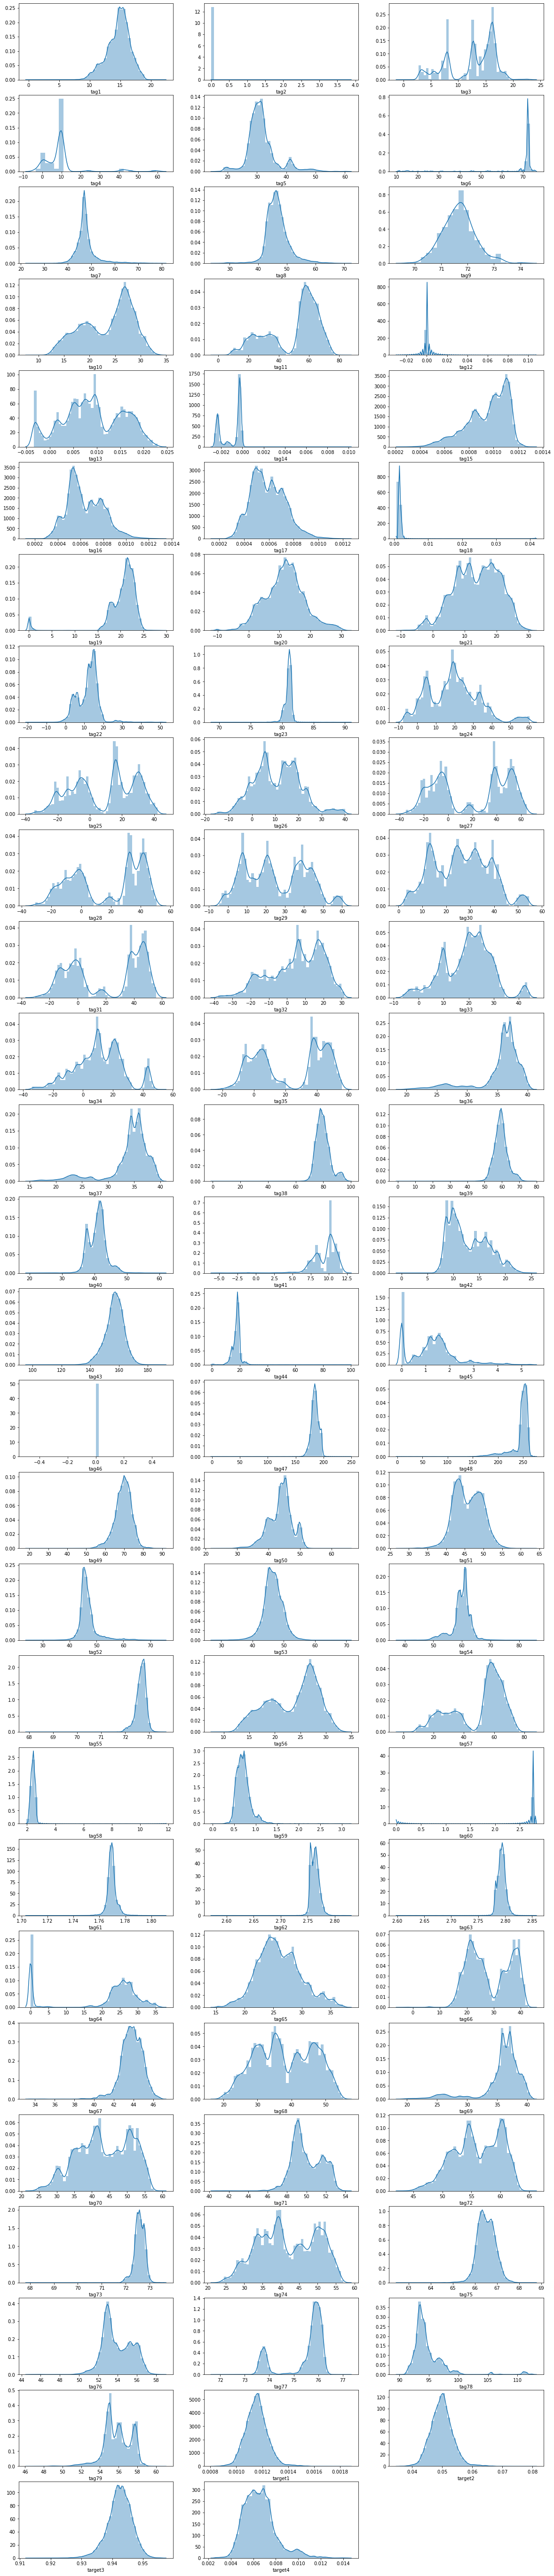

In [7]:
f = plt.figure(figsize=(20,100))

features = [df[col] for col in df.columns if col!='tag0']
for i in range(len(features)):
    f.add_subplot(28, 3, i+1)
    sns.distplot(features[i].dropna())

In [8]:
# посмотрим отдельно на tag2 и tag46, там очень узкие распределения
df[['tag2','tag46']].describe()

,tag2,tag46
count,109370.000000,98410.0
mean,0.003483,0.0
std,0.017229,0.0
min,-0.005142,0.0
25%,0.001326,0.0
50%,0.003691,0.0
75%,0.005223,0.0
max,3.886294,0.0


как и было видно на графике плотности распределения tag46 - бесполезный tag

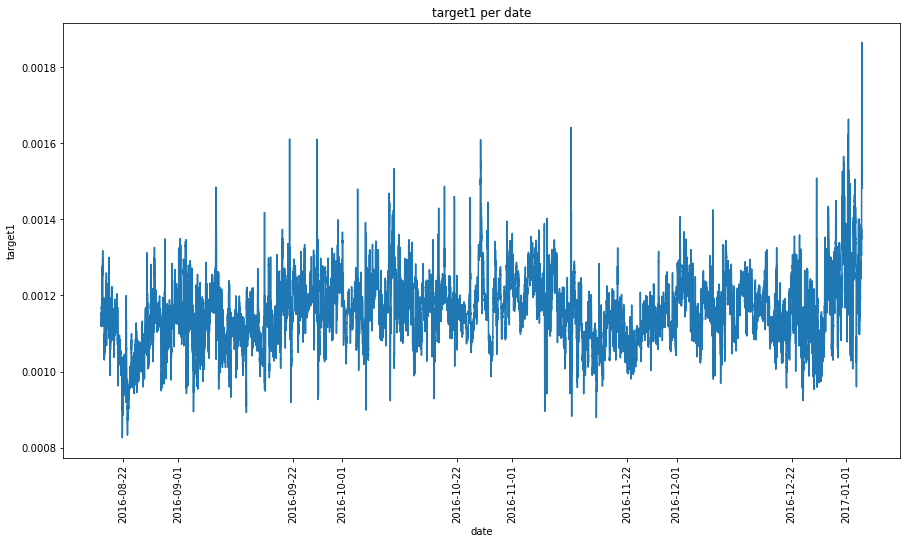

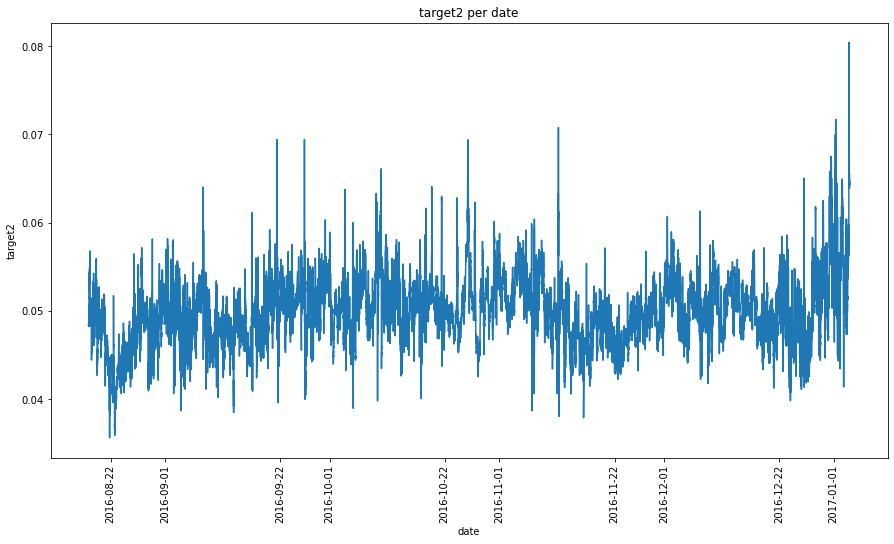

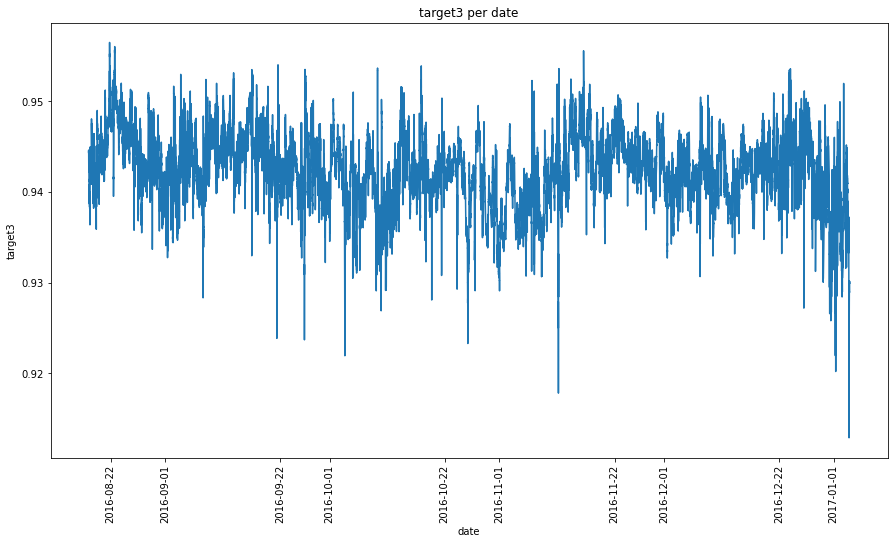

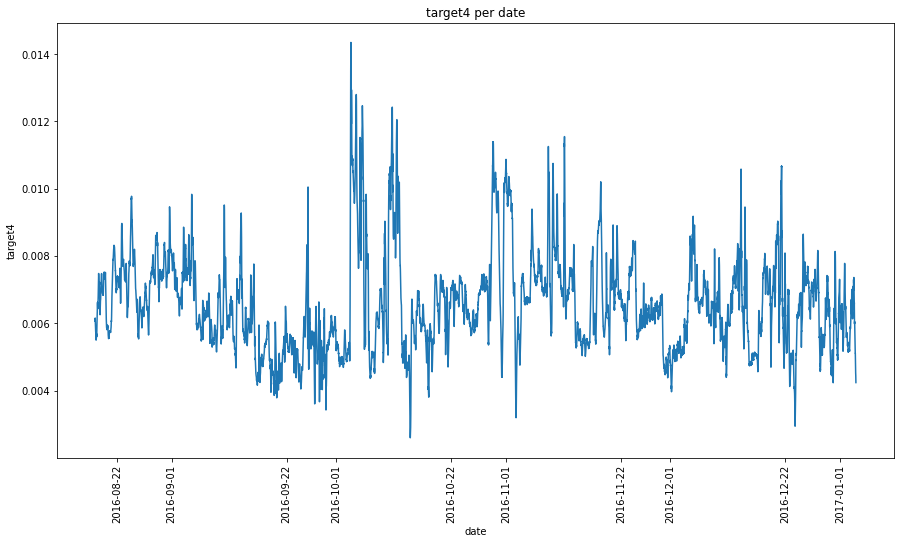

In [9]:
# посмотрим, как менялись таргеты с течением времени
for col in list(df)[-4:]:
    rcParams['figure.figsize'] = 15, 8
    plt.figure()
    plt.plot(df['tag0'],df[col])
    plt.xlabel('date')
    plt.ylabel(col)
    plt.title(col+' per date')
    plt.xticks(rotation=90)

каких-либо направленных временных тенденций не видно

# Фильтрация данных

In [10]:
# Посмотрим, как обстоят дела с пропусками данных
A=[]
for x in df.columns:
    A.append(len(df[df[x].isnull()]))
print(A)

[0, 66, 90630, 90544, 199915, 190264, 199627, 111878, 183223, 199593, 163, 133, 125, 125, 125, 125, 125, 125, 125, 99832, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 160780, 161952, 41692, 47030, 184422, 198593, 137, 133, 88275, 86200, 101590, 133, 67645, 134, 121880, 185278, 98208, 115811, 140557, 133, 163, 133, 163, 881, 125, 164190, 163274, 125, 133, 133, 133, 133, 133, 162348, 133, 133, 133, 164913, 133, 133, 133, 151197, 151327, 151442, 9, 9, 9, 9]


In [11]:
# имеет смысл избавится от строк, в которых отсутствуют целевые таргеты
df.drop(df[df['target1'].isnull() | df['target2'].isnull() | df['target3'].isnull() 
           | df['target4'].isnull()].index, inplace=True)
df = df.reset_index(drop=True)

поскольку возникает вопрос о том, какие тэги наиболее релевантны, предлагается не выкидывать столбцы,
даже если в них сплошные нули или очень много пропусков. пропуски можно заполнить средними значениями 
по столбцу. если же пропусков слишком, то это при построении модели автоматически приведёт к тому, 
что таргет станет не актуальным, так как будет иметь константное значение. Местами пропусков очень много, чтобы в таком случае не получить слишком много выбросов (если будет очень много средних значений, все остальные уйдут в выбросы - как оказалось, это половина данных), сначала уберём выбросы, а потом заполним пропуски

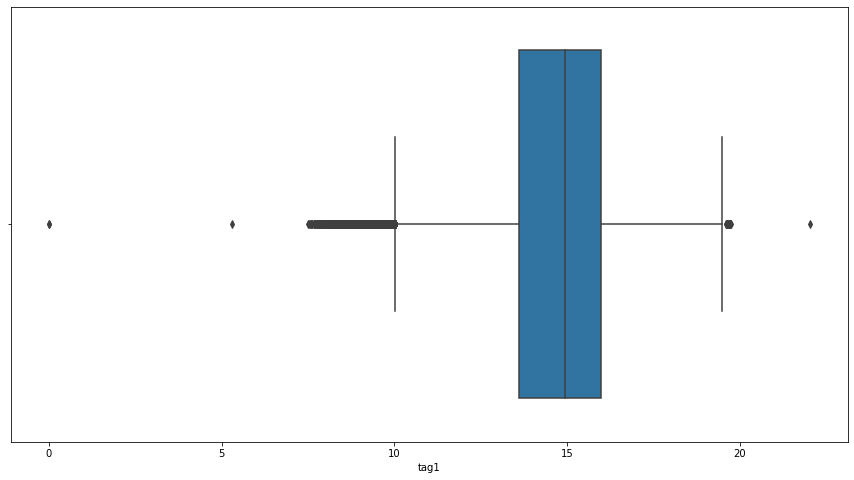

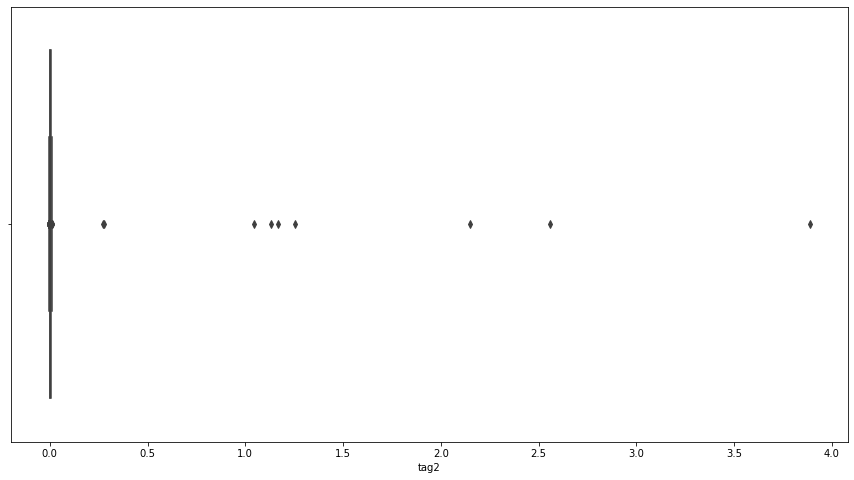

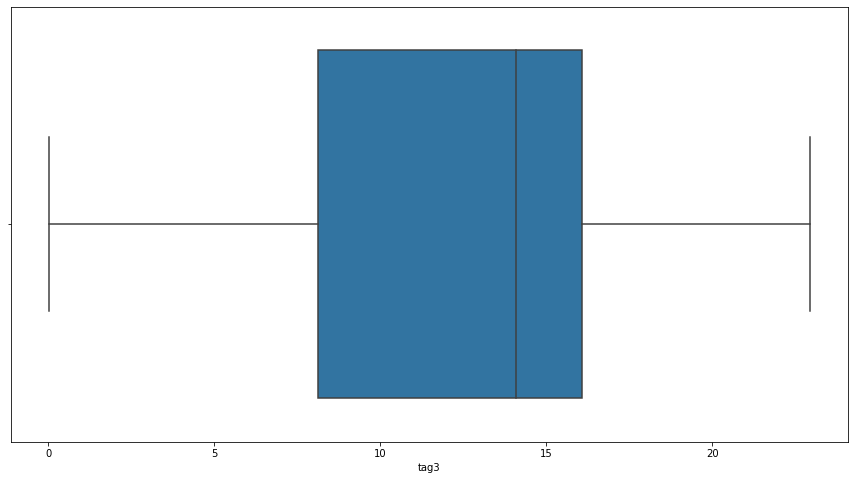

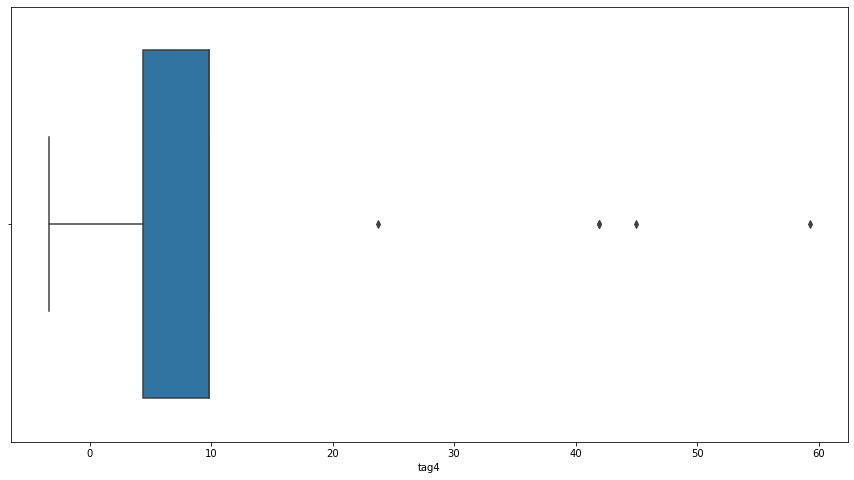

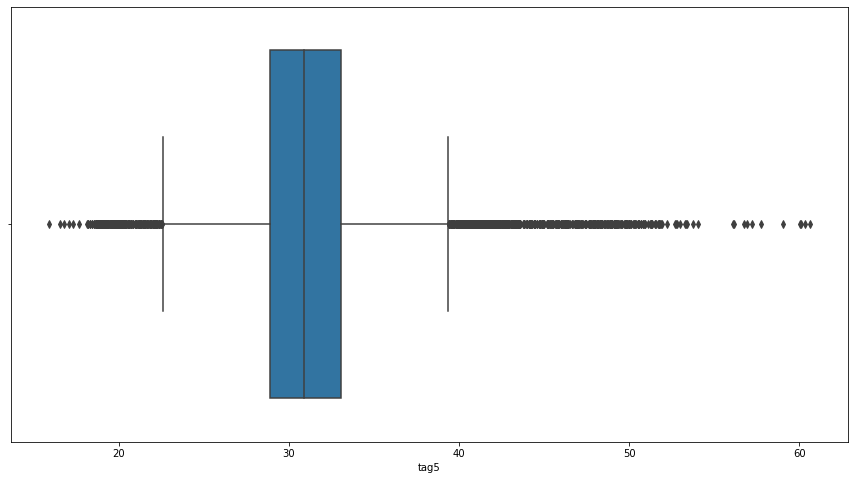

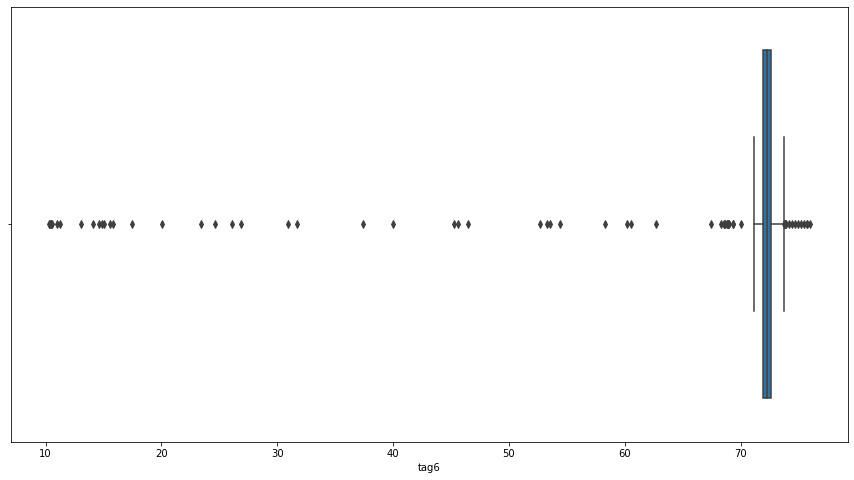

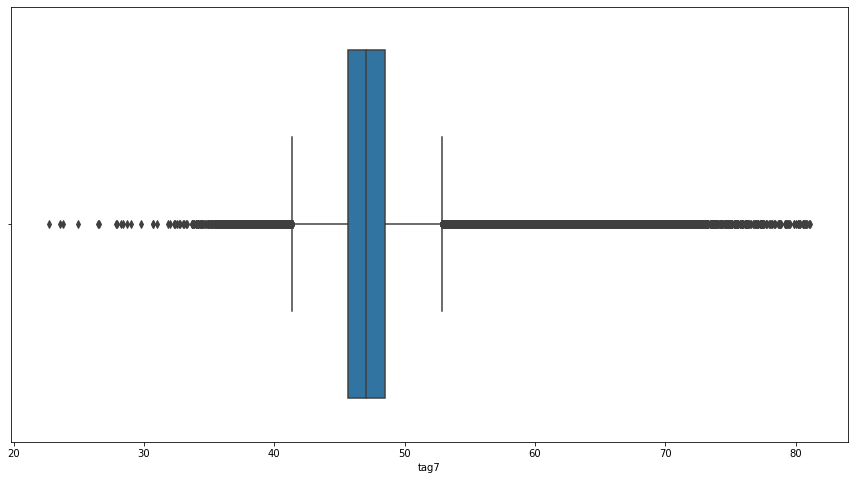

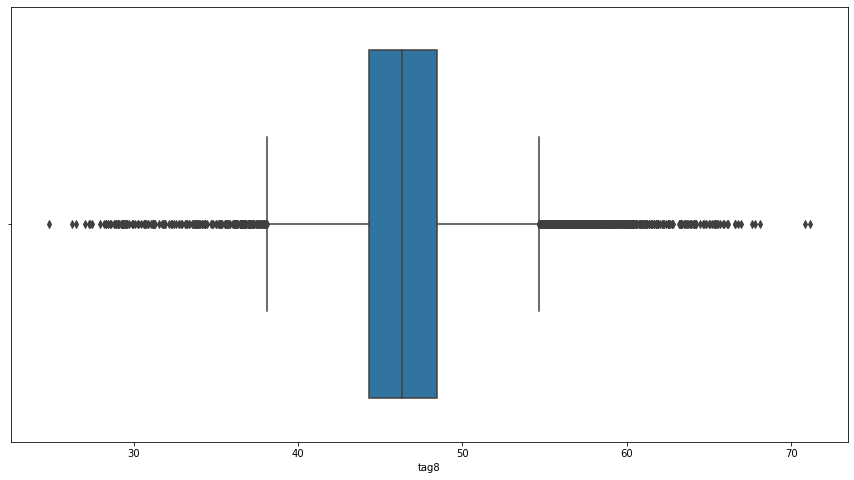

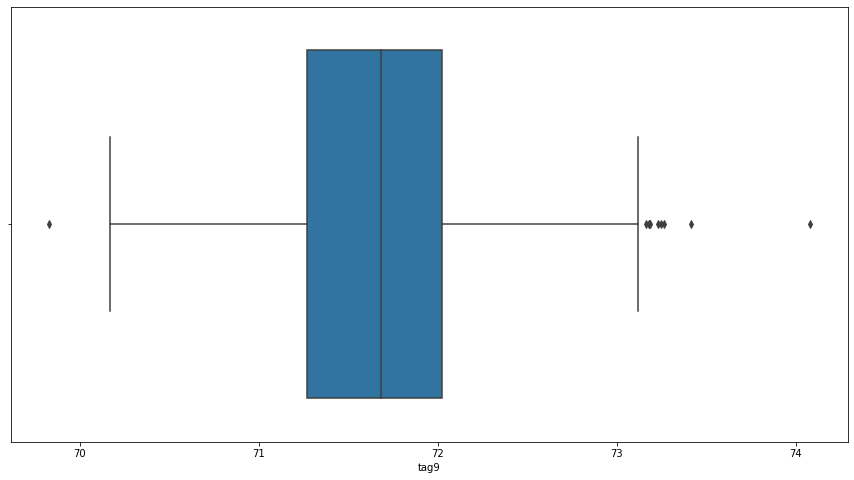

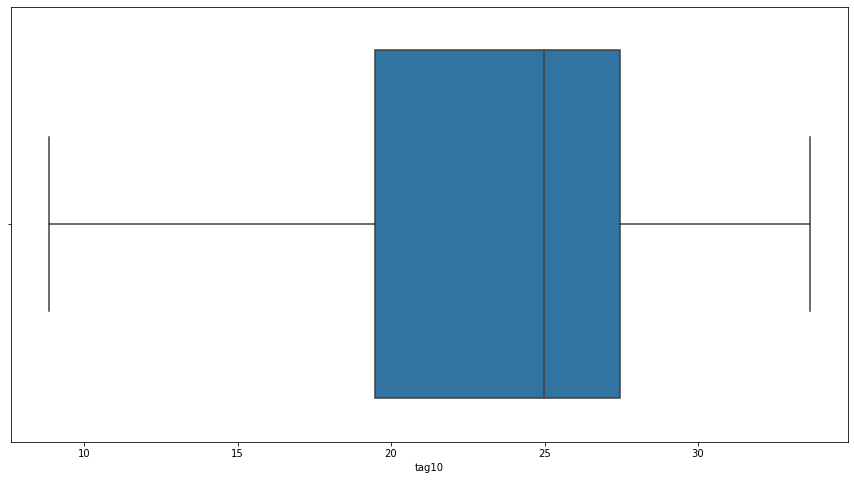

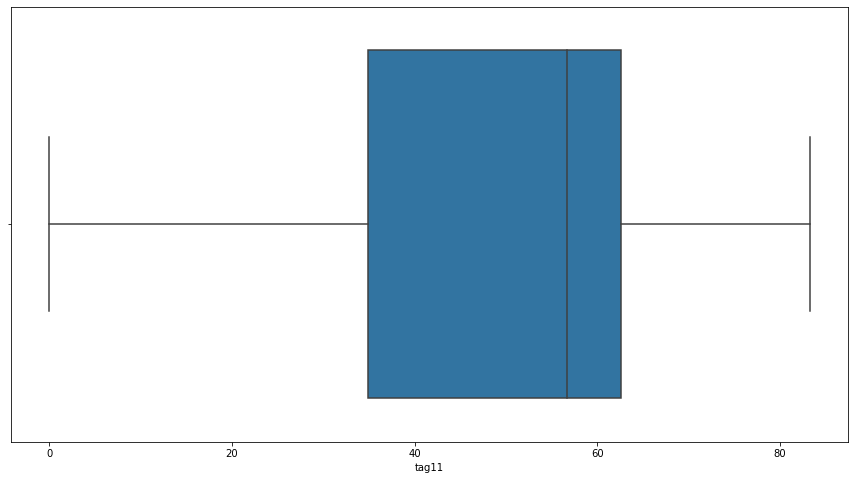

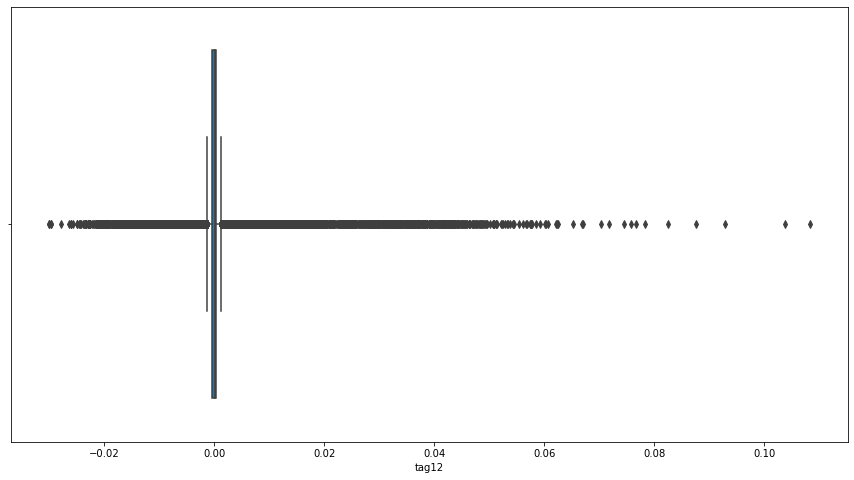

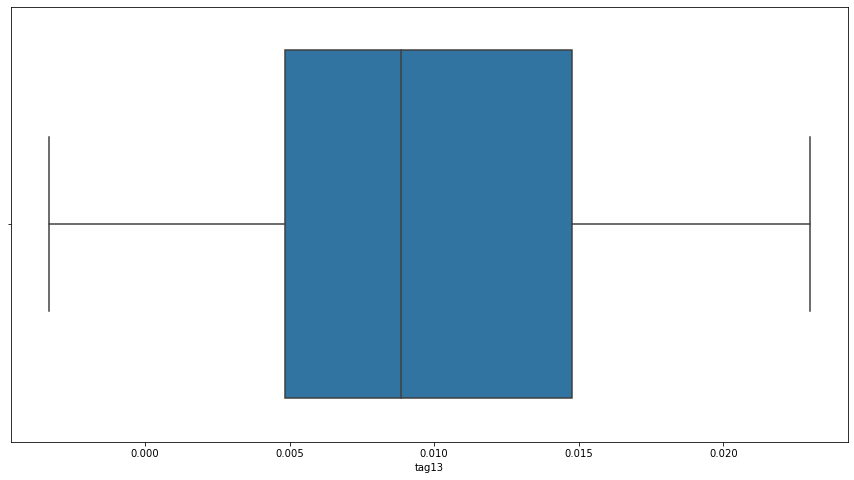

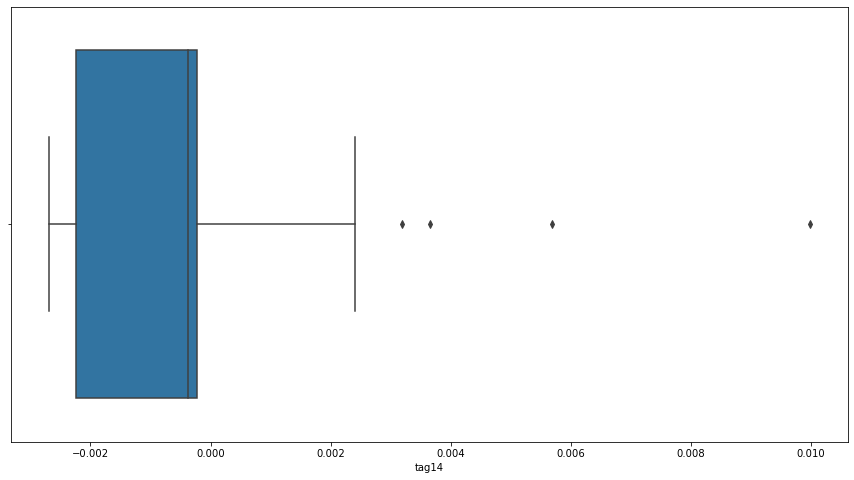

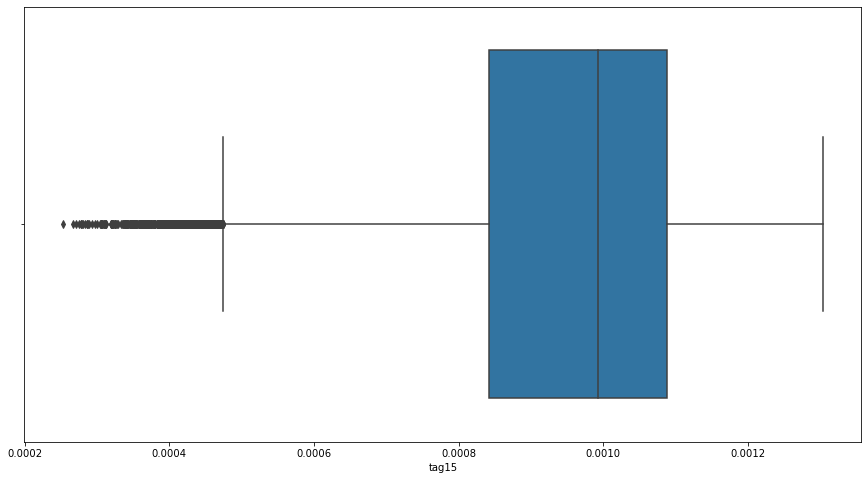

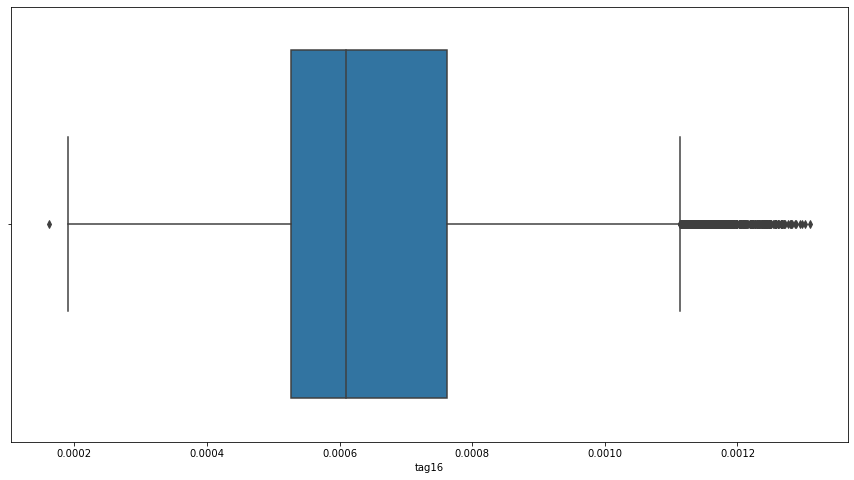

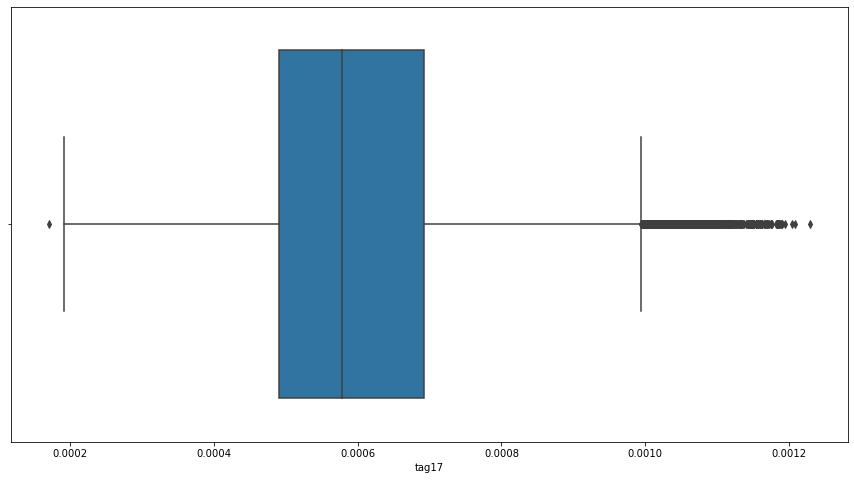

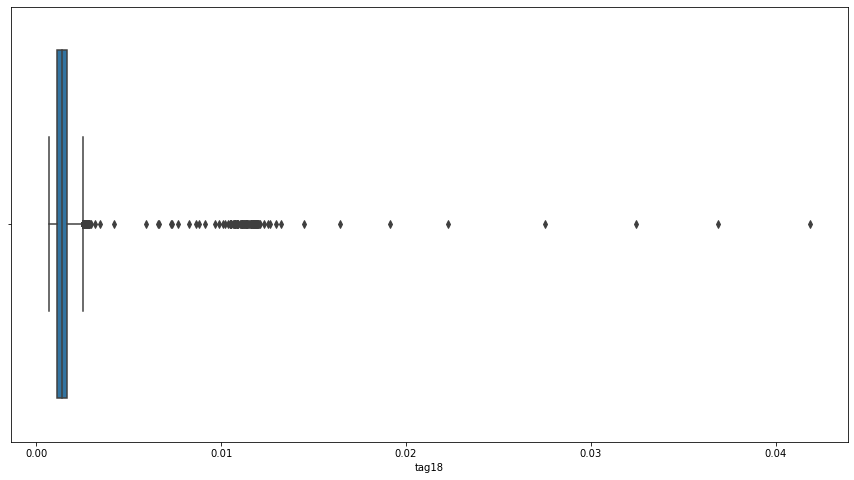

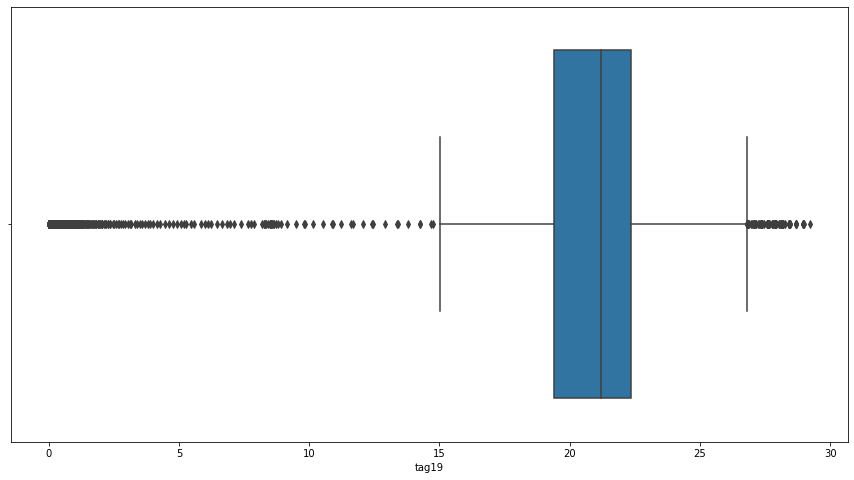

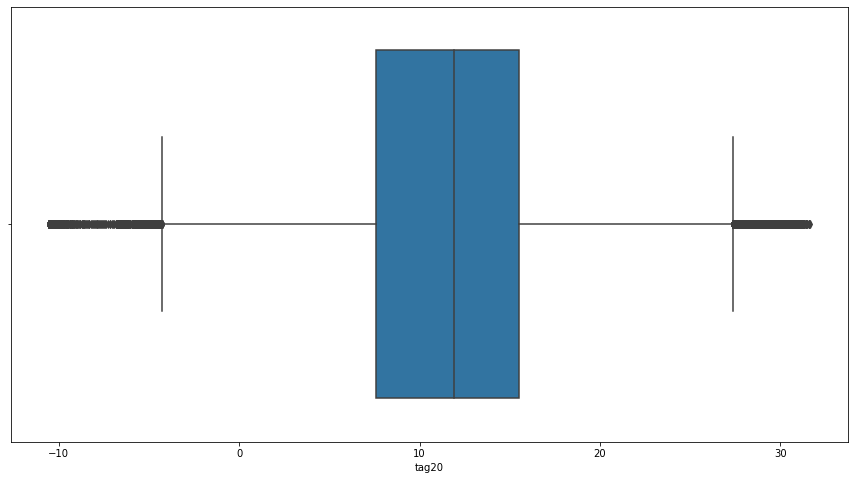

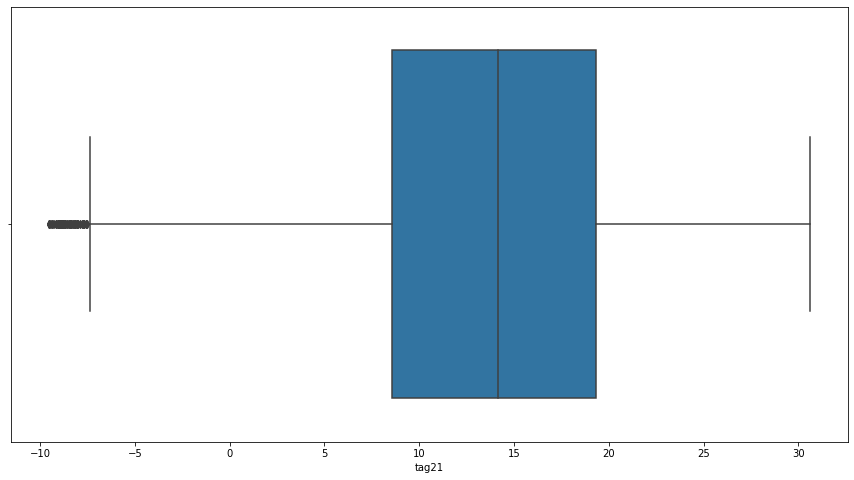

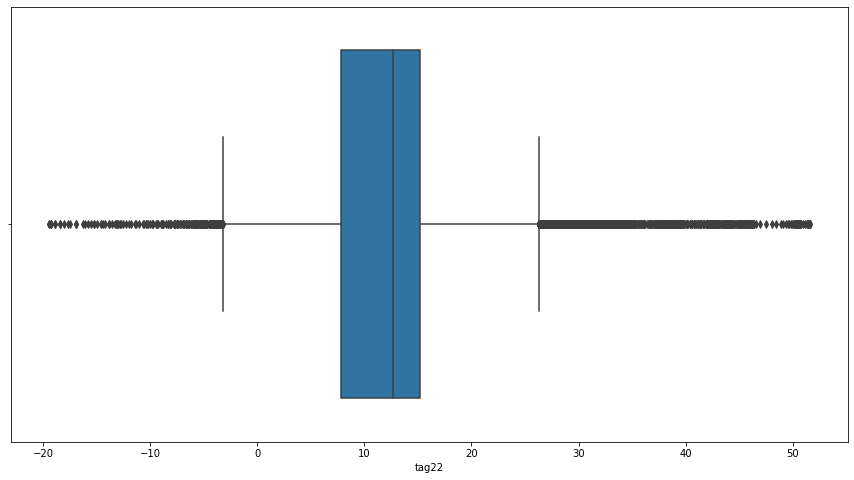

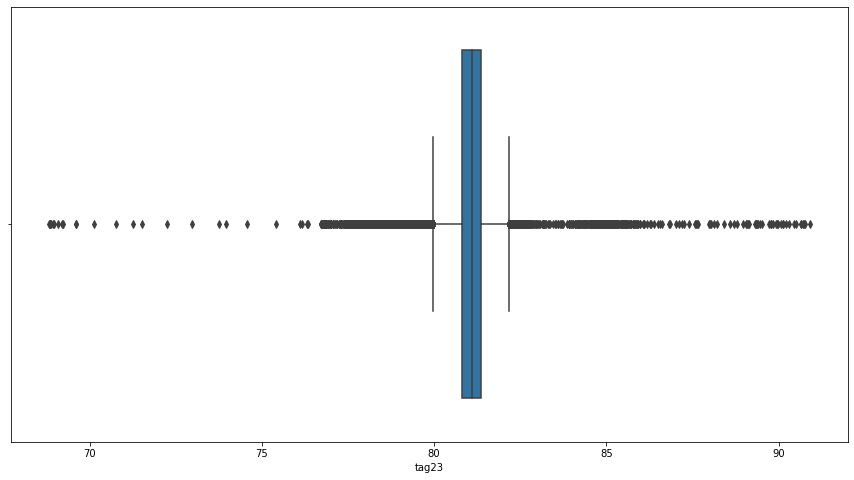

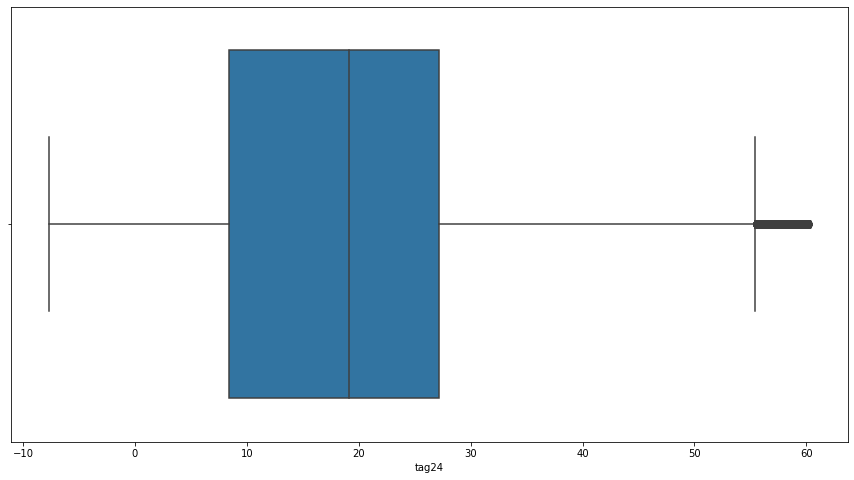

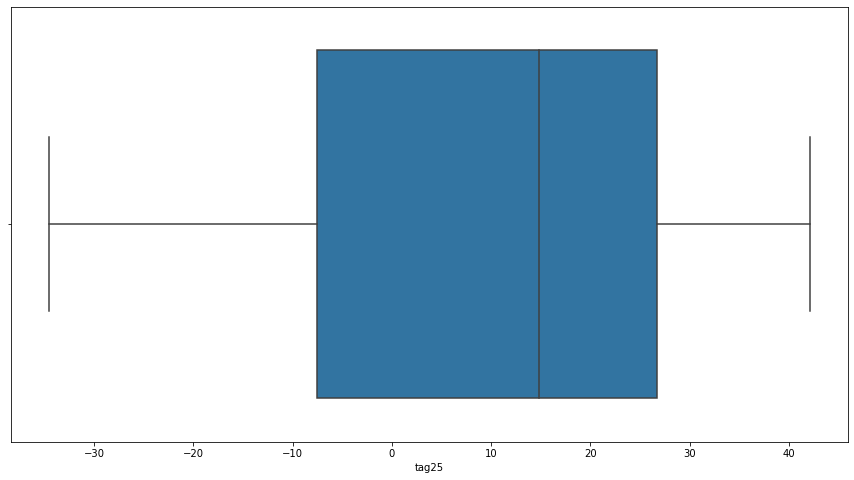

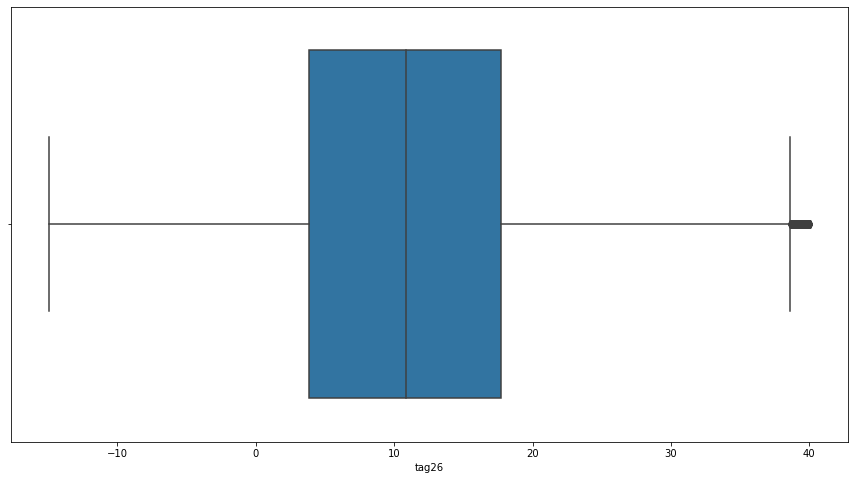

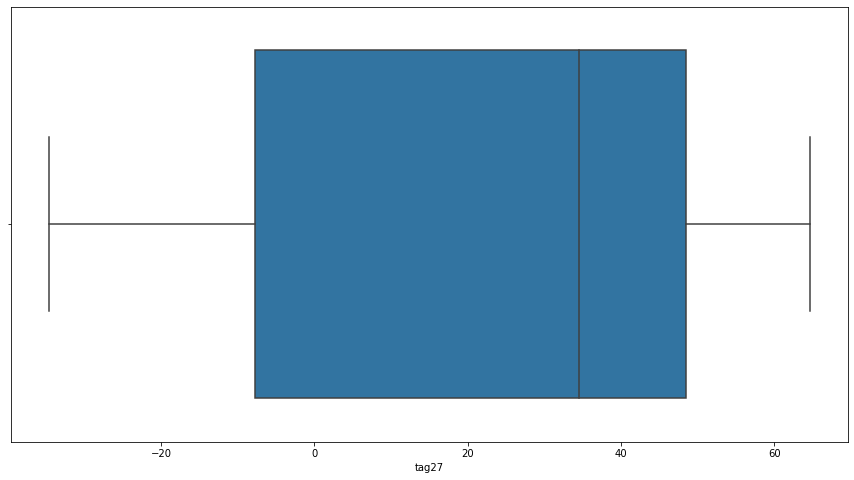

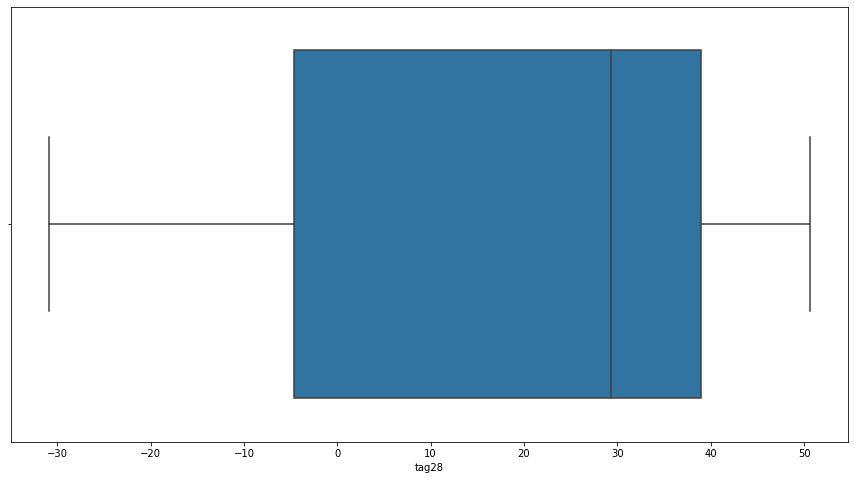

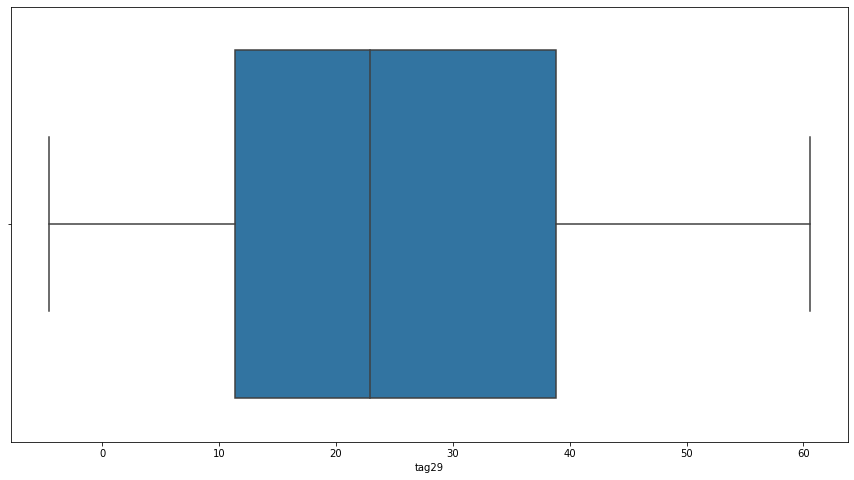

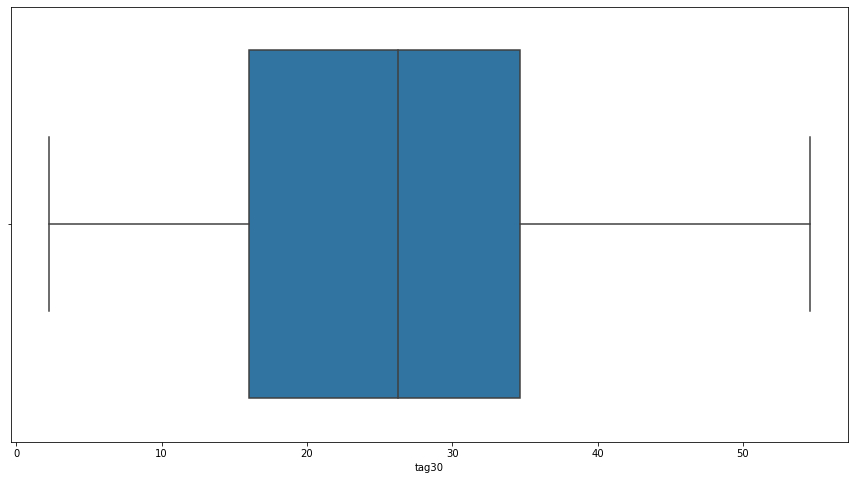

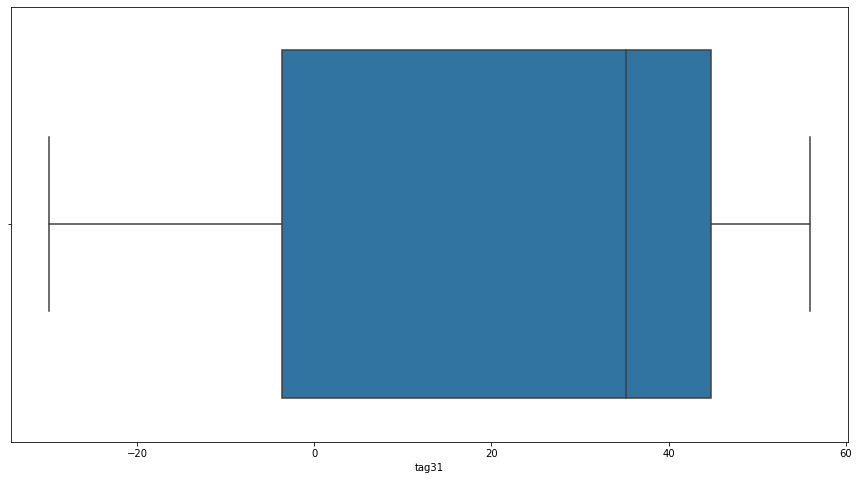

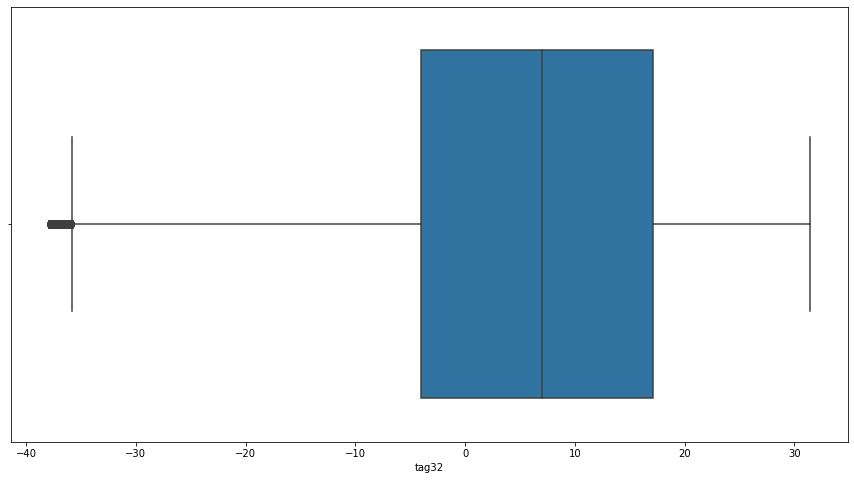

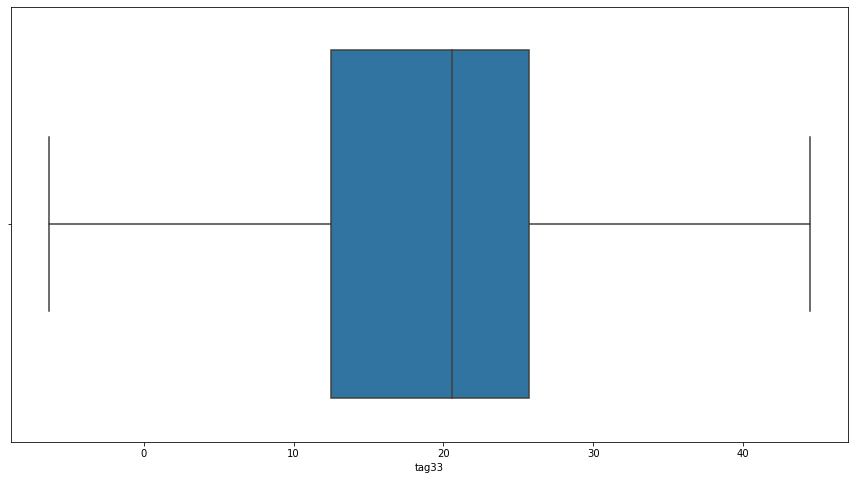

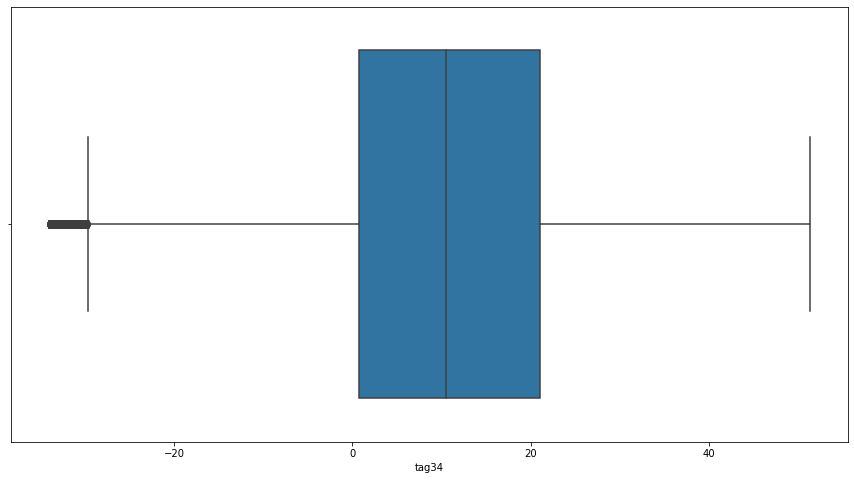

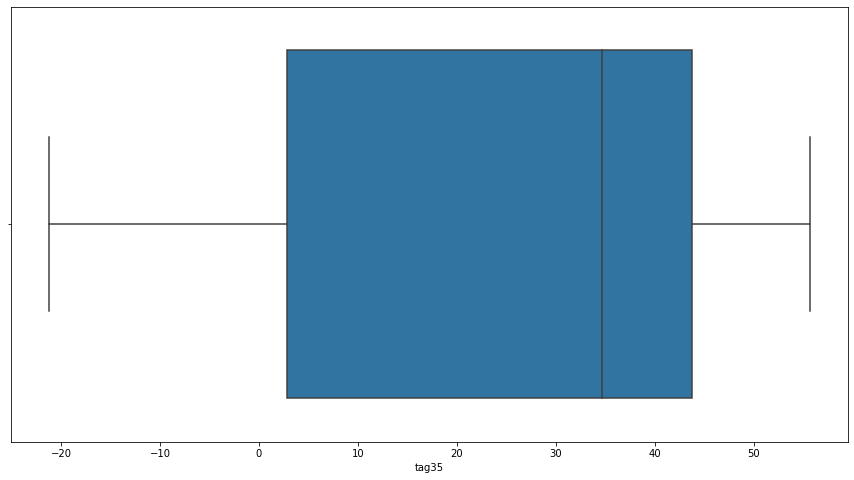

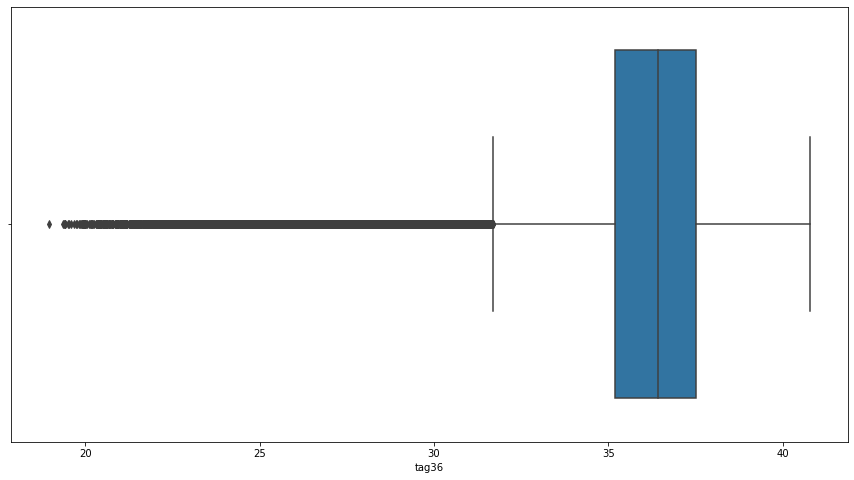

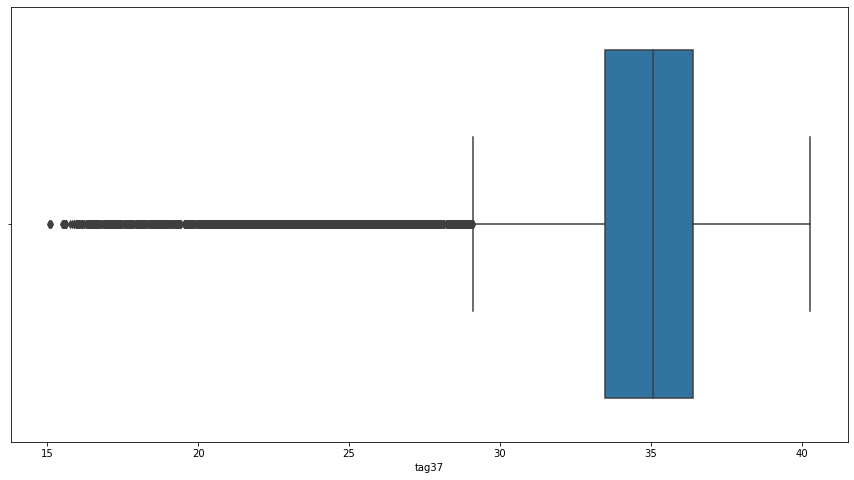

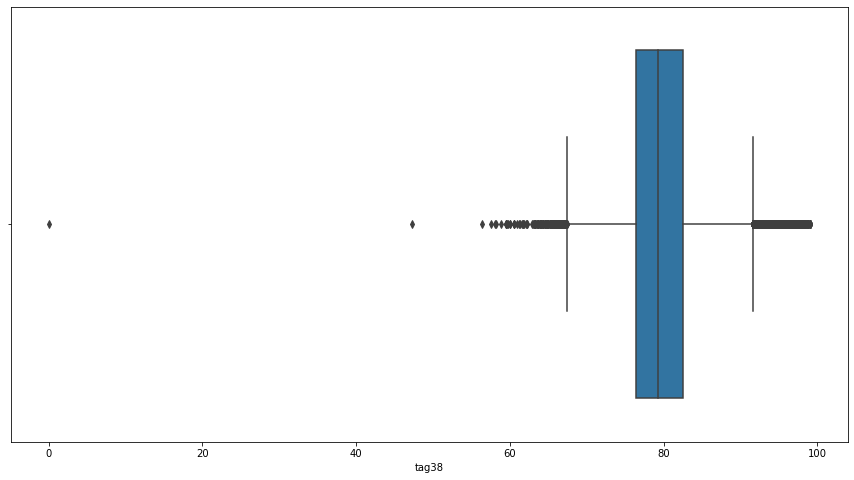

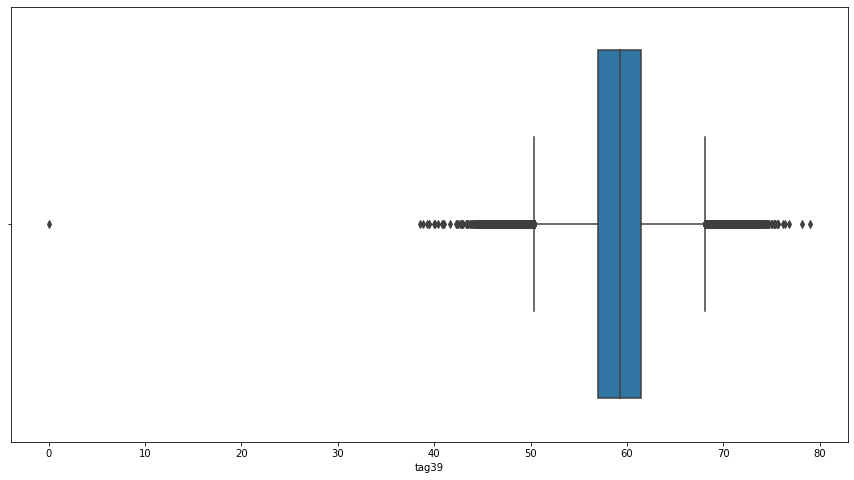

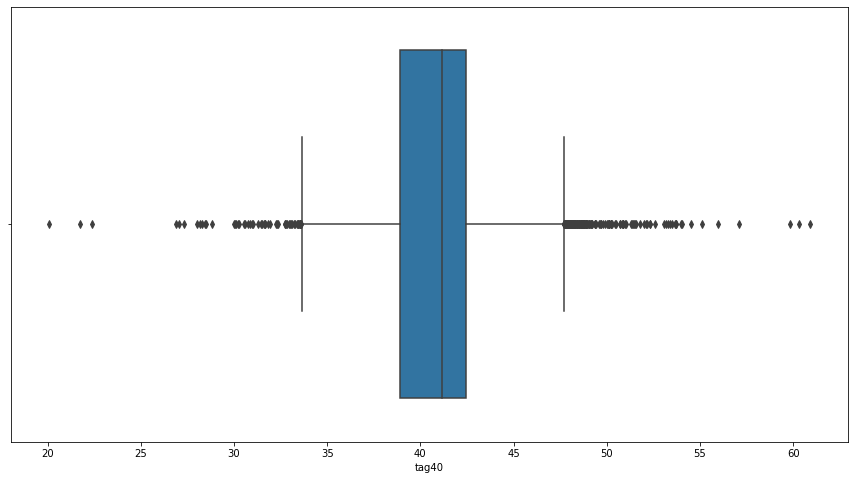

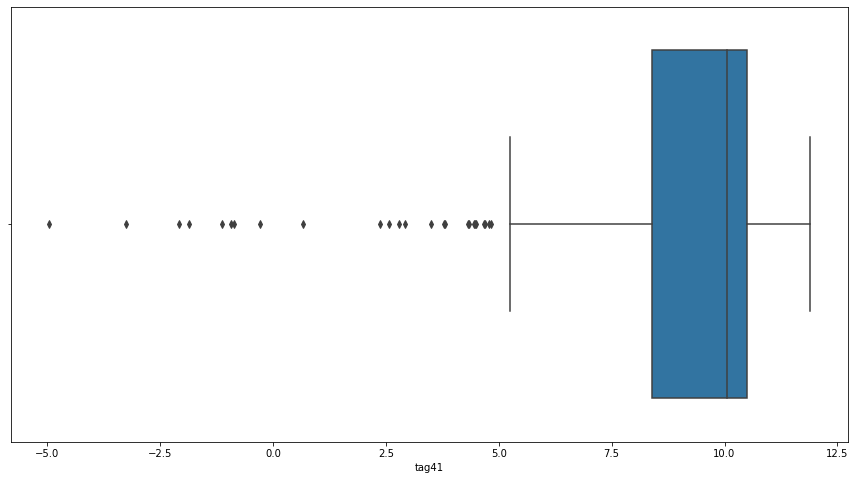

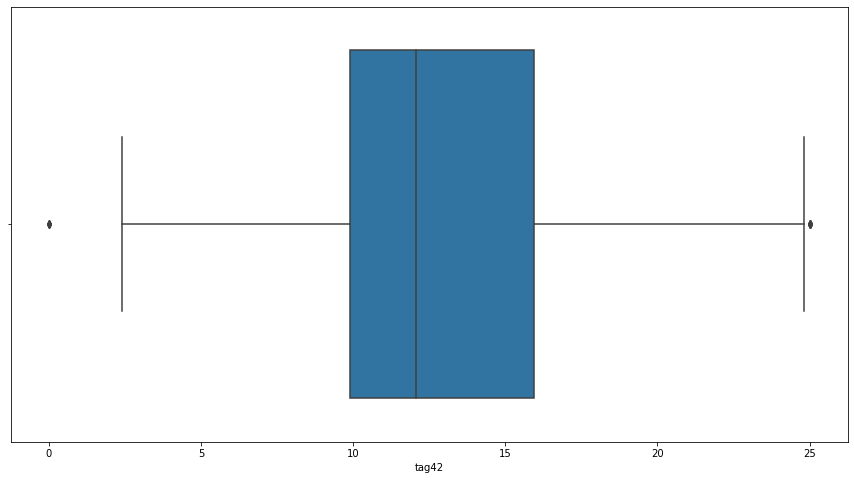

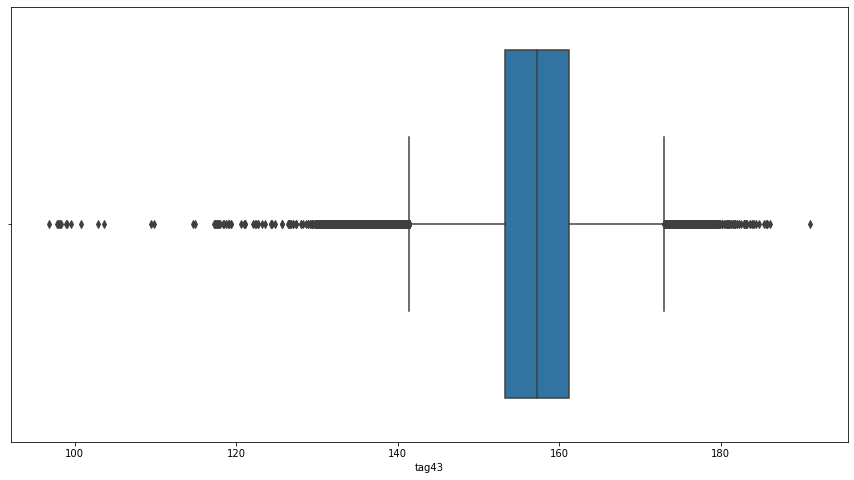

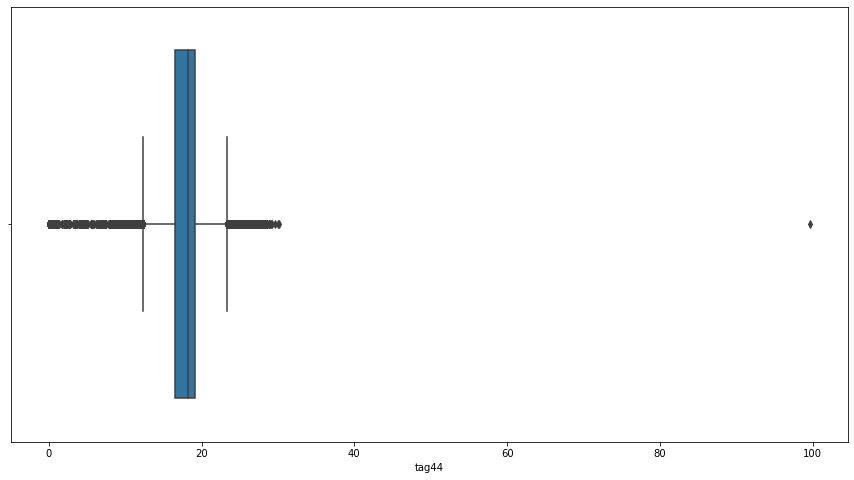

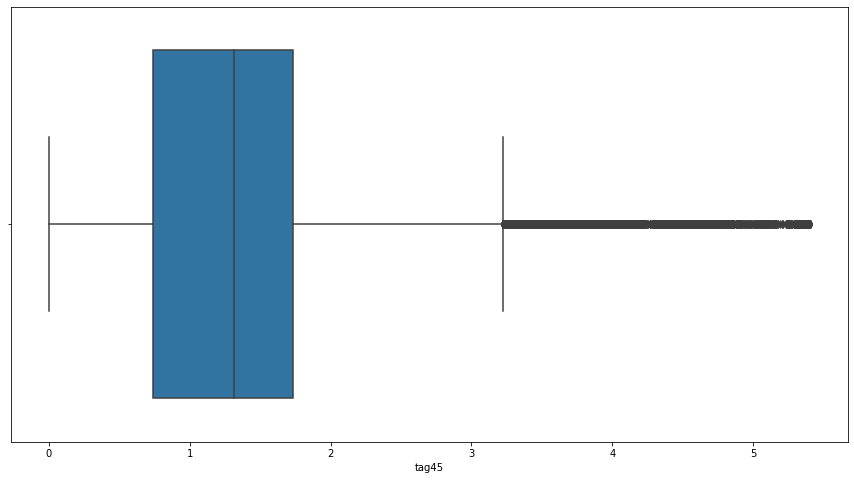

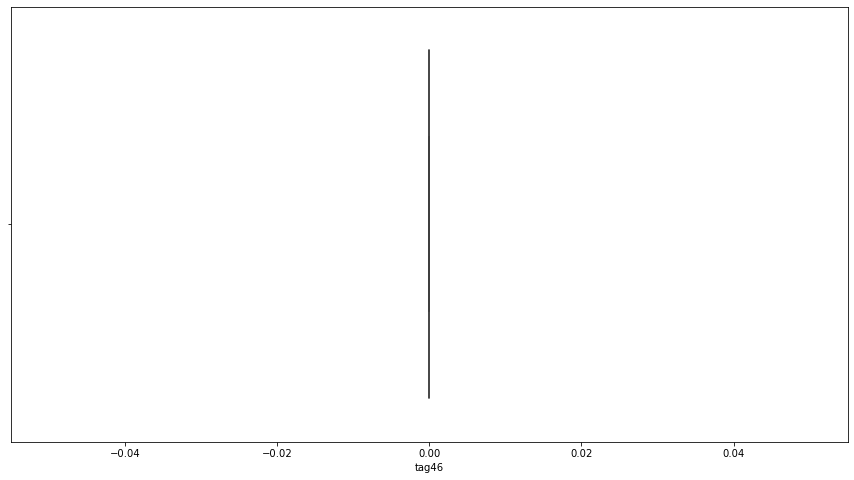

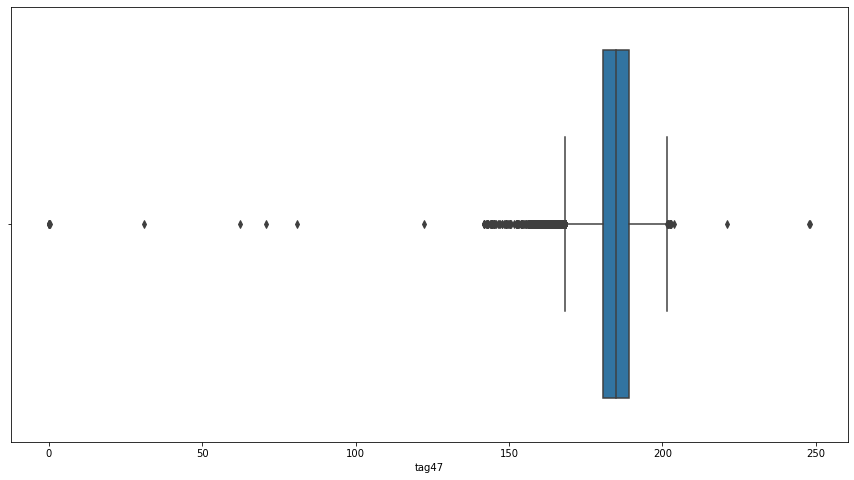

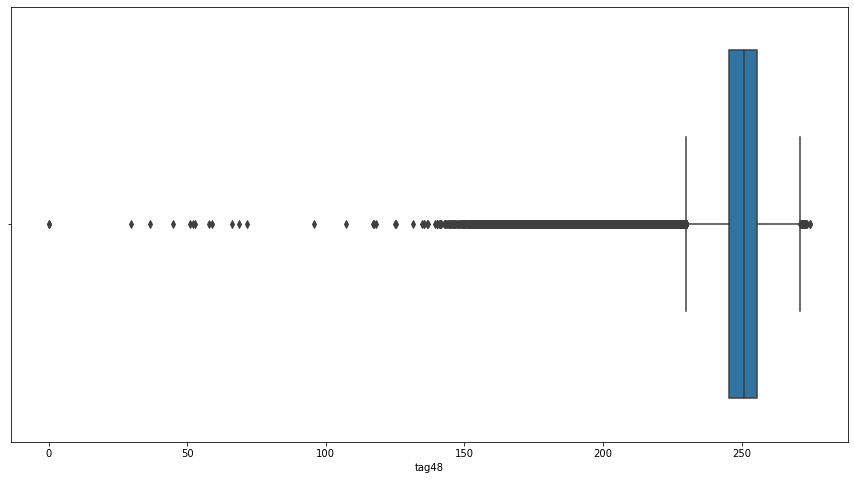

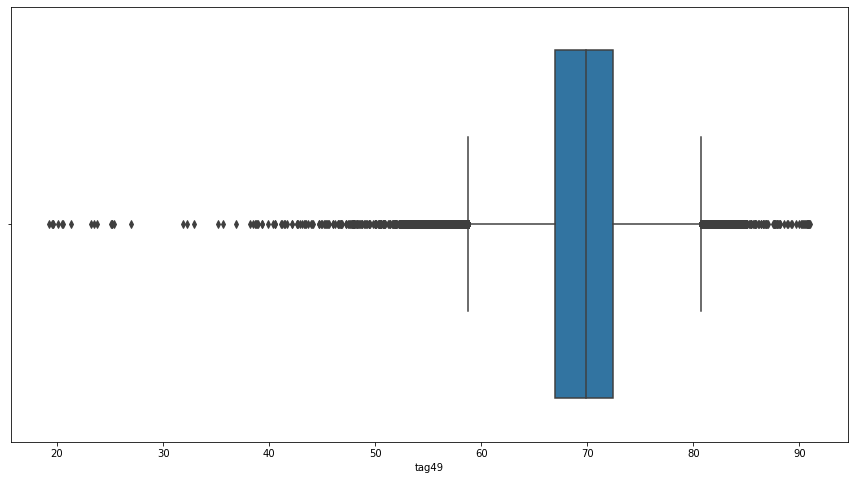

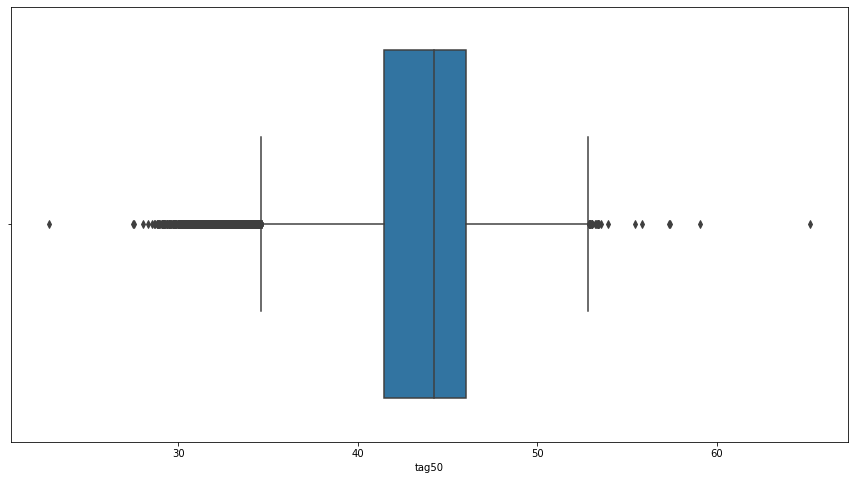

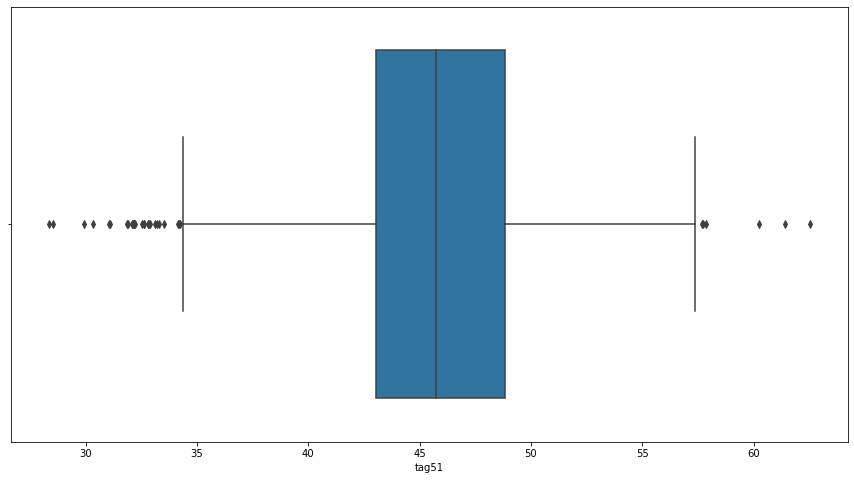

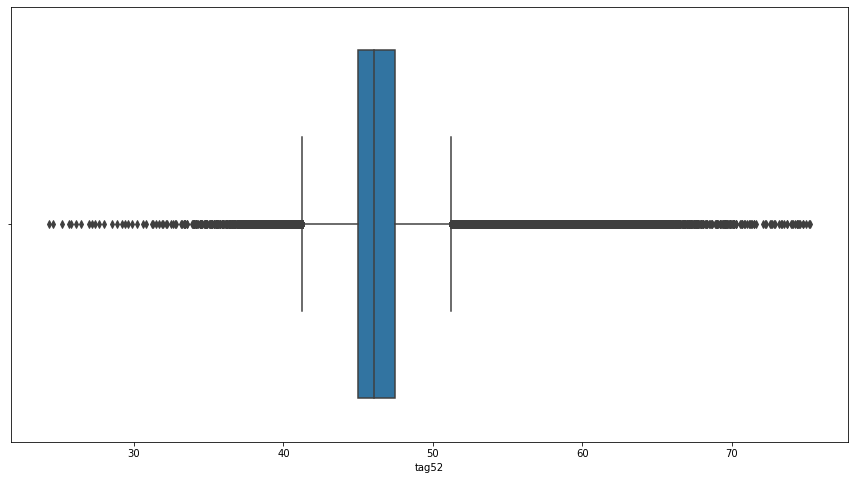

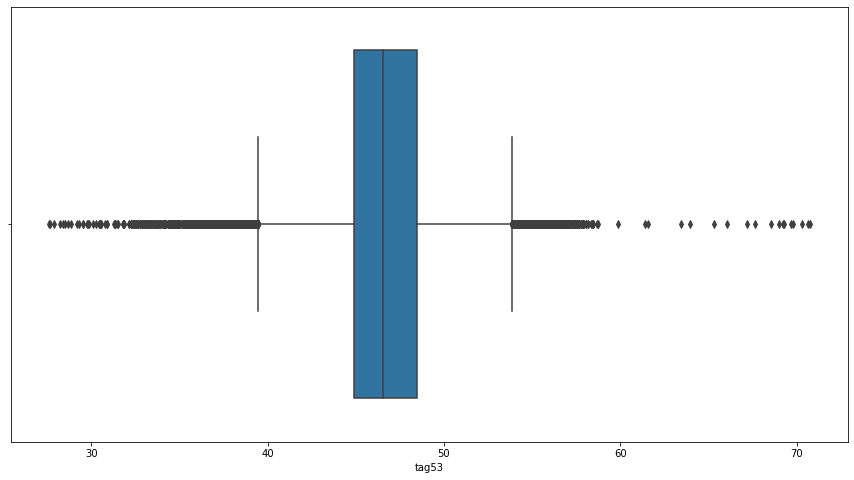

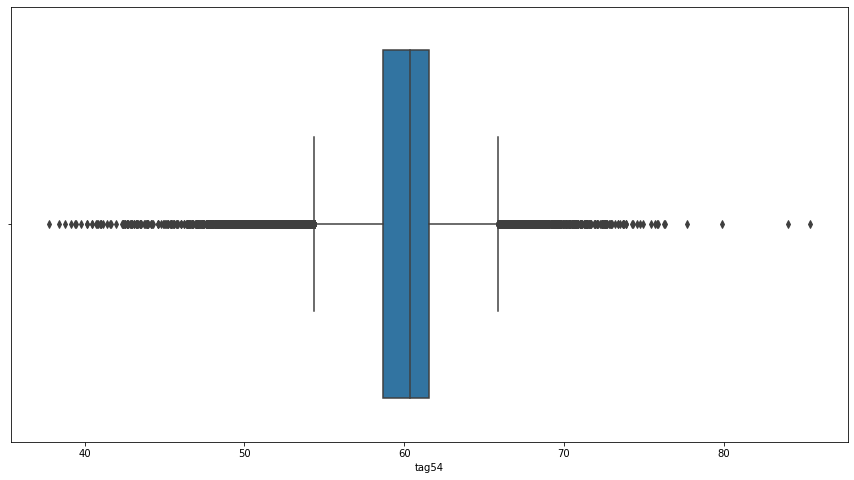

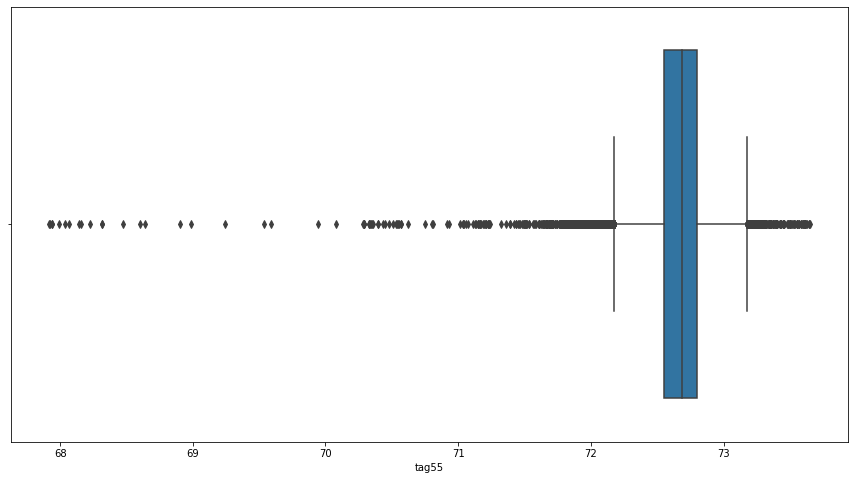

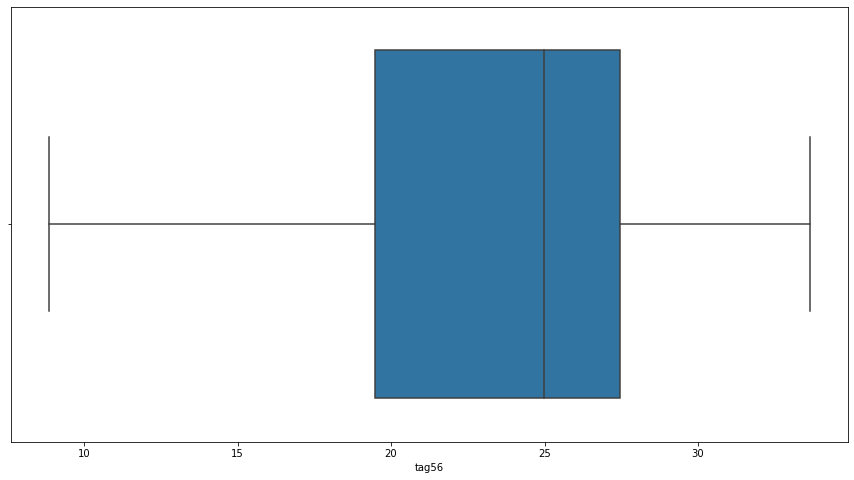

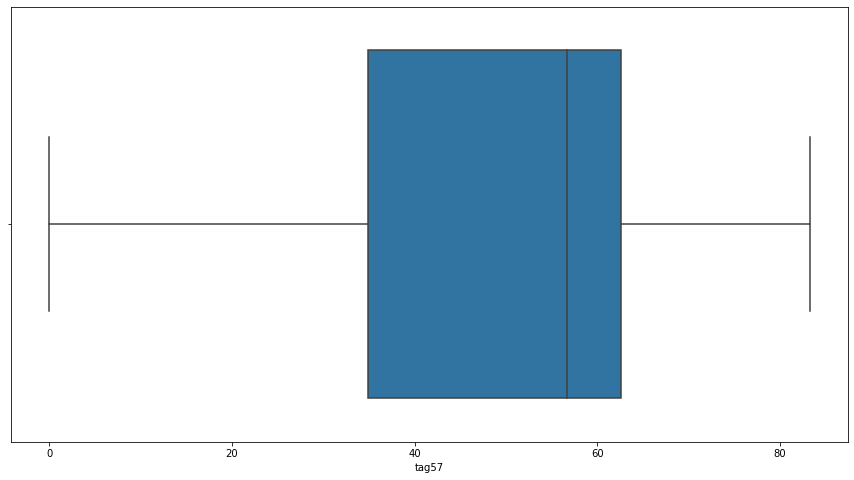

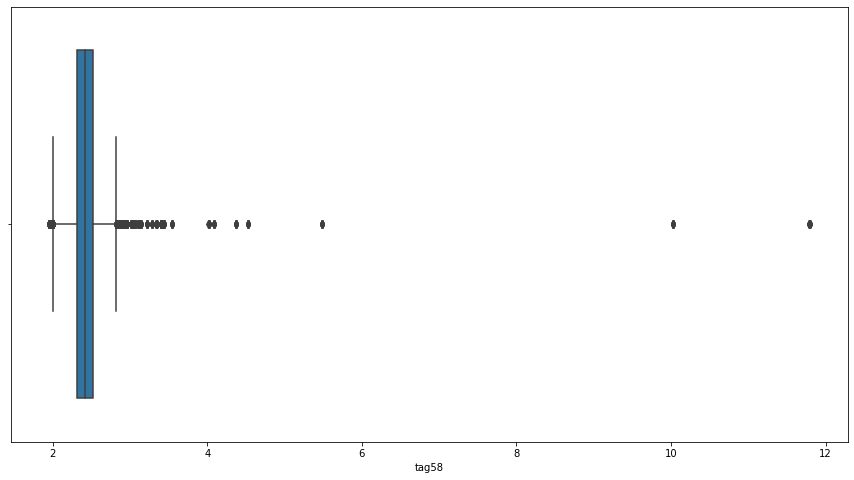

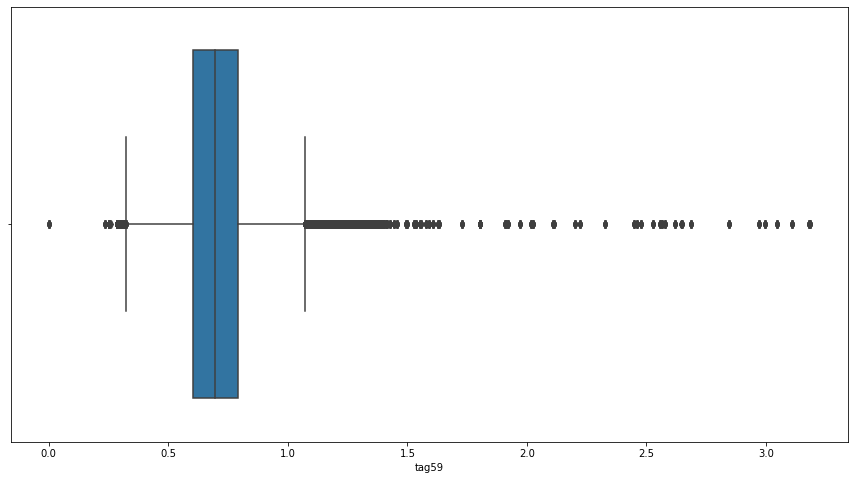

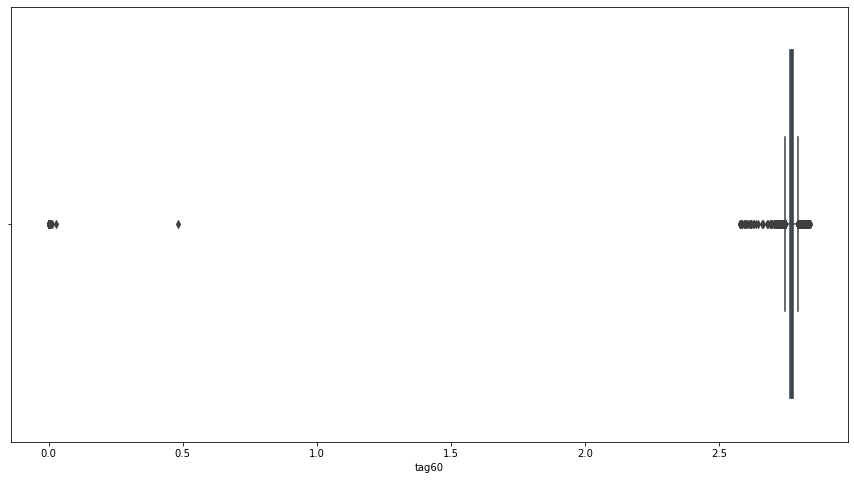

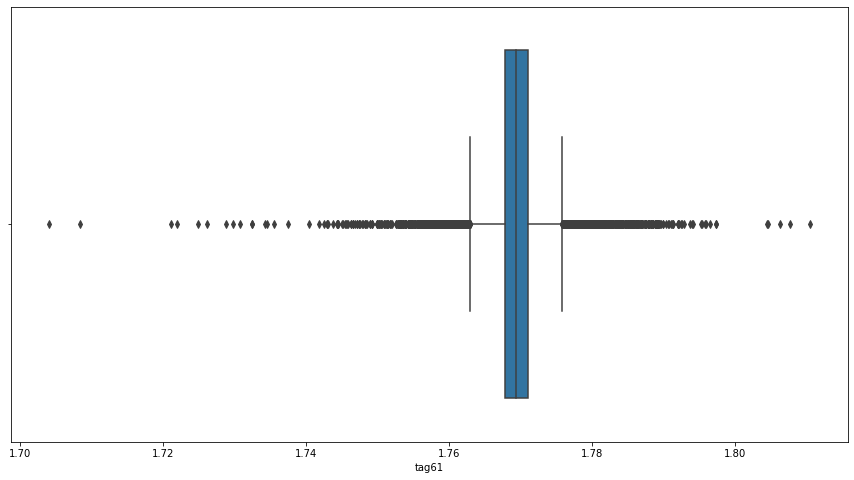

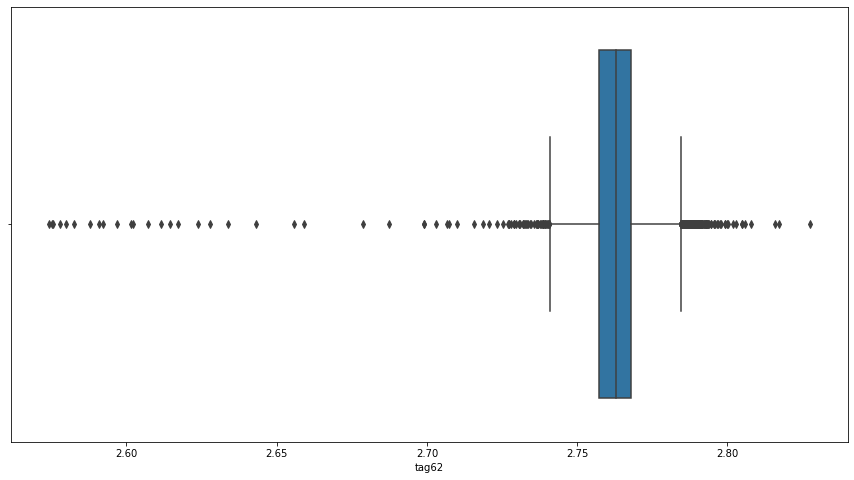

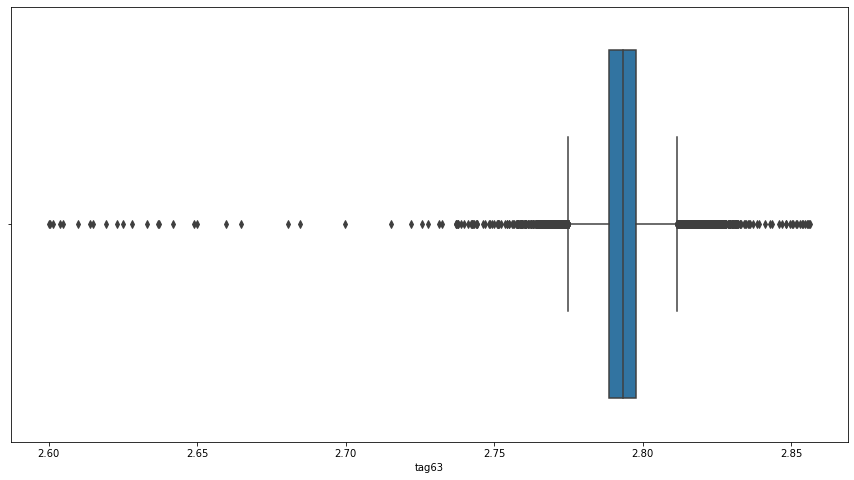

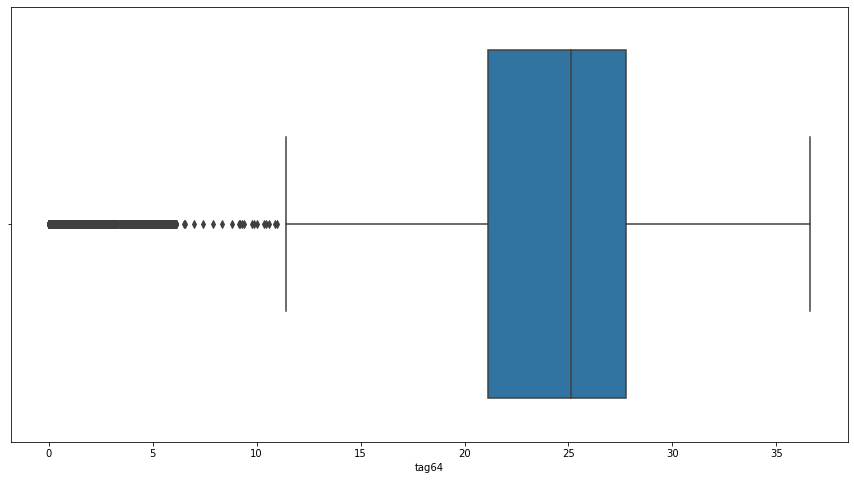

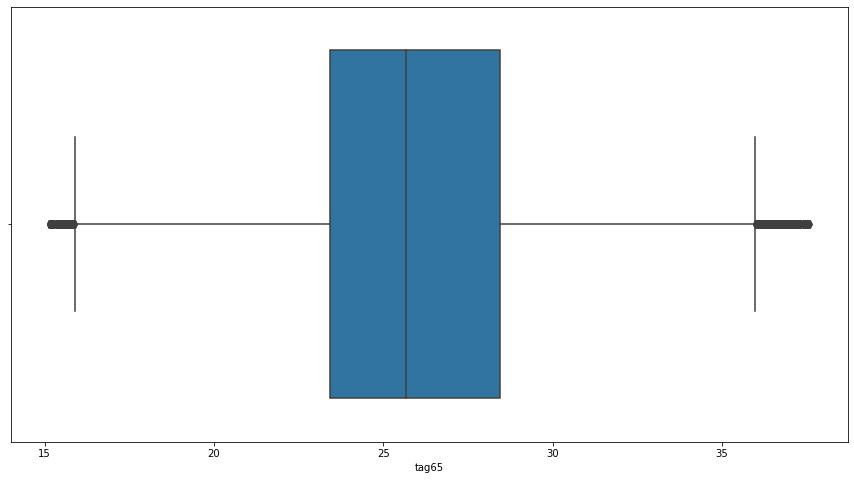

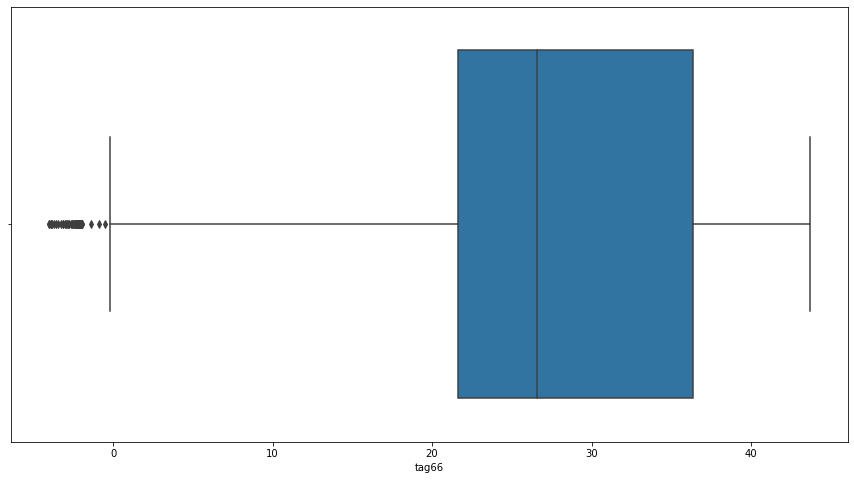

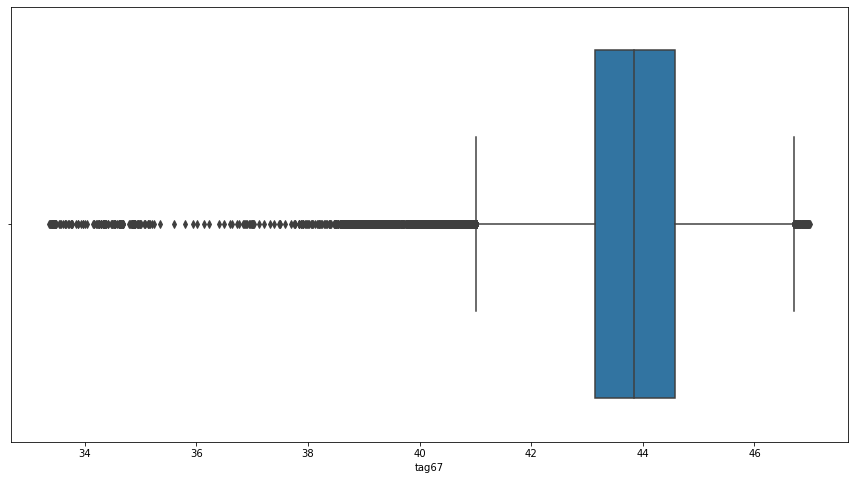

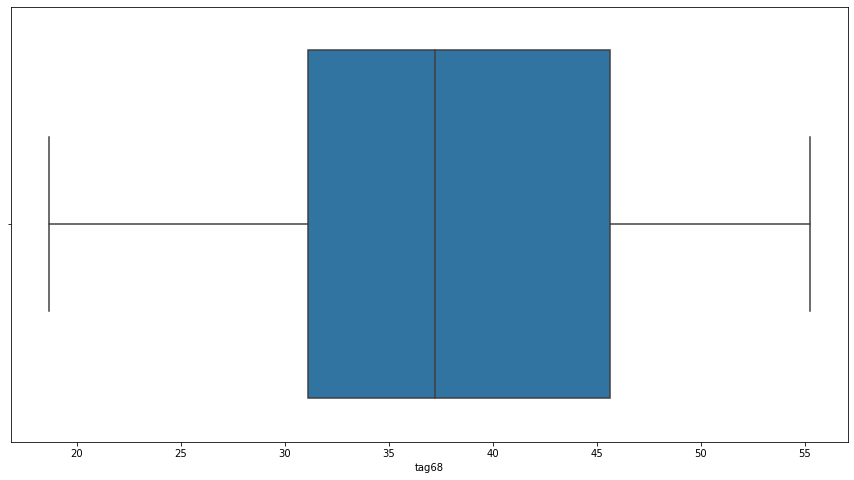

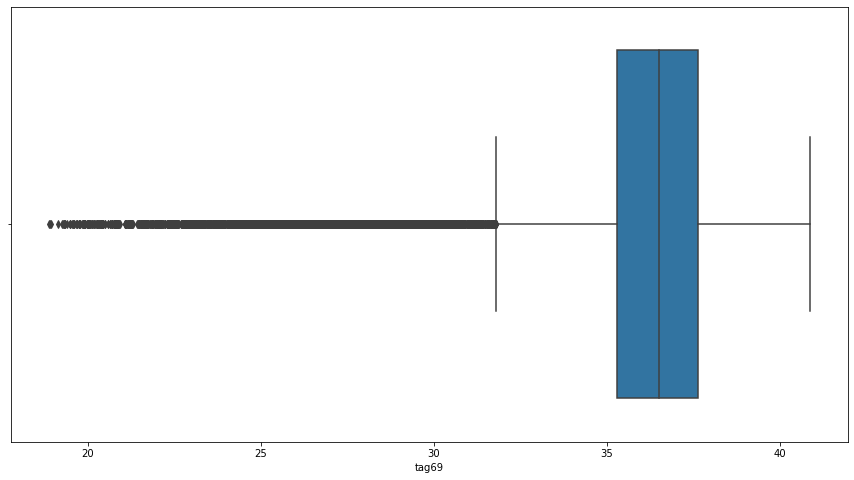

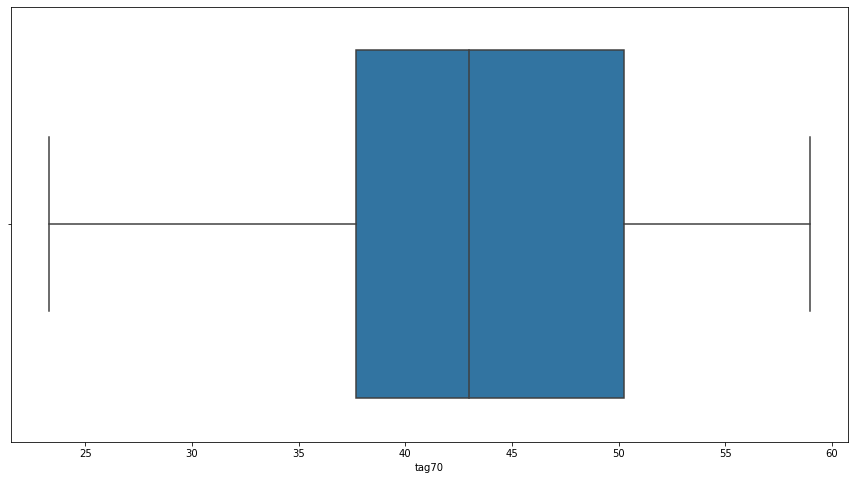

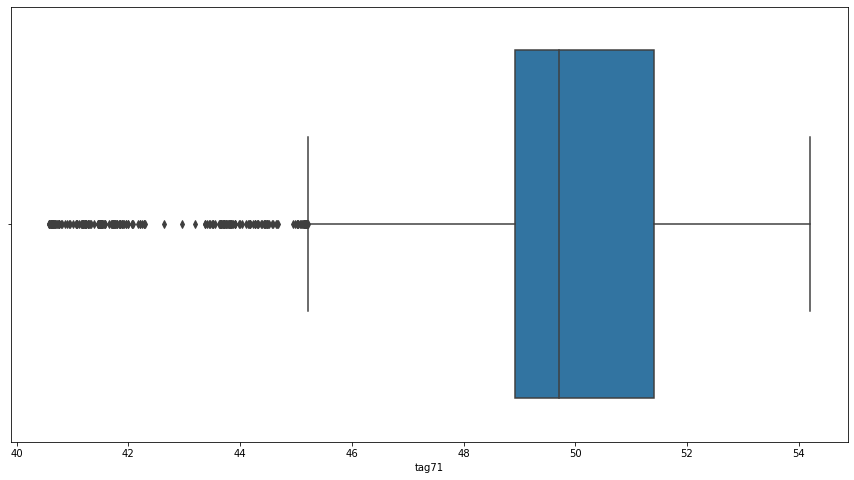

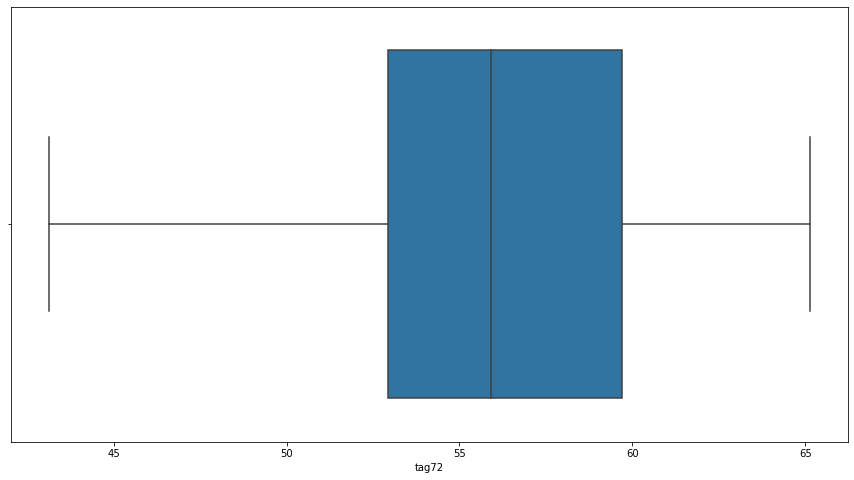

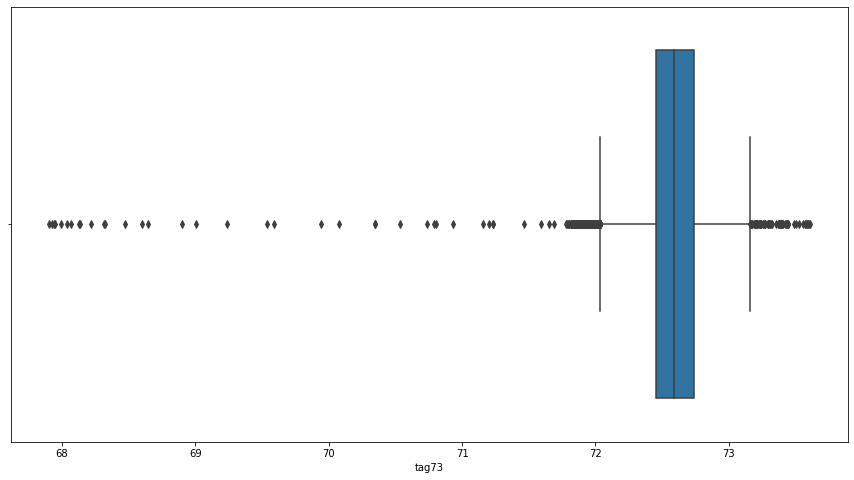

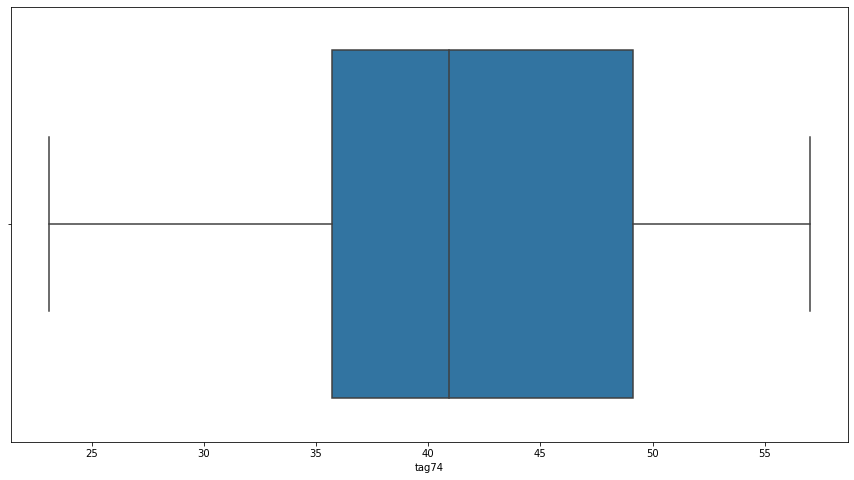

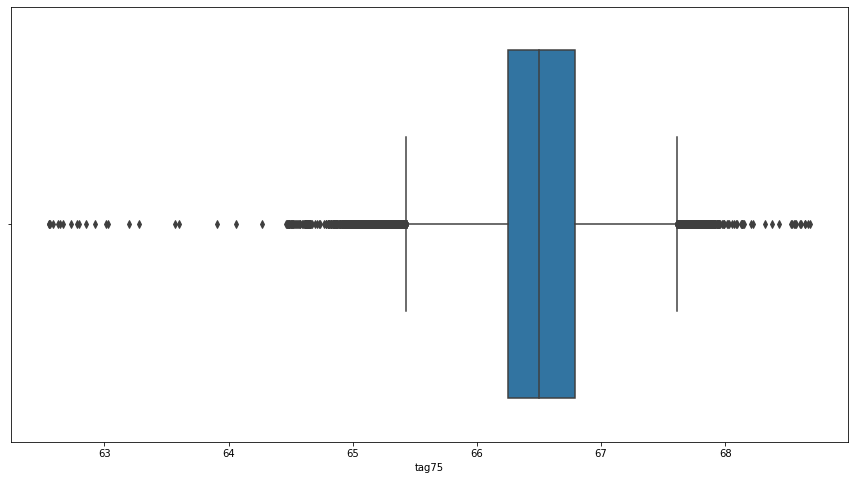

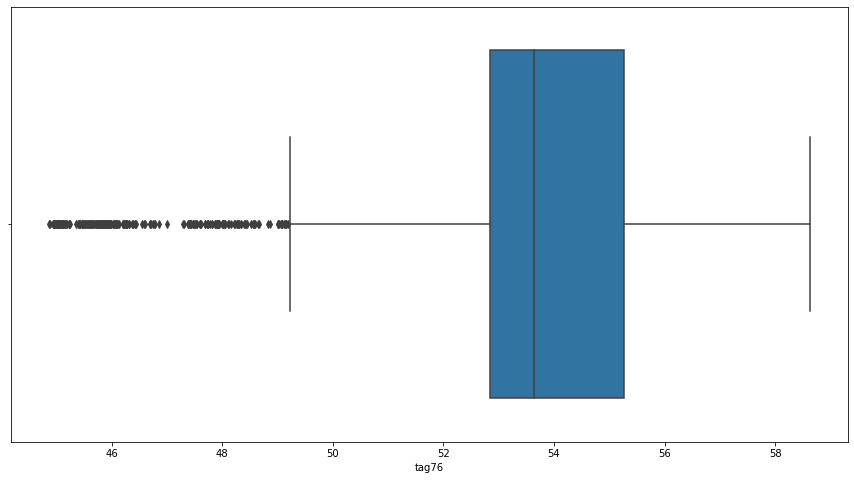

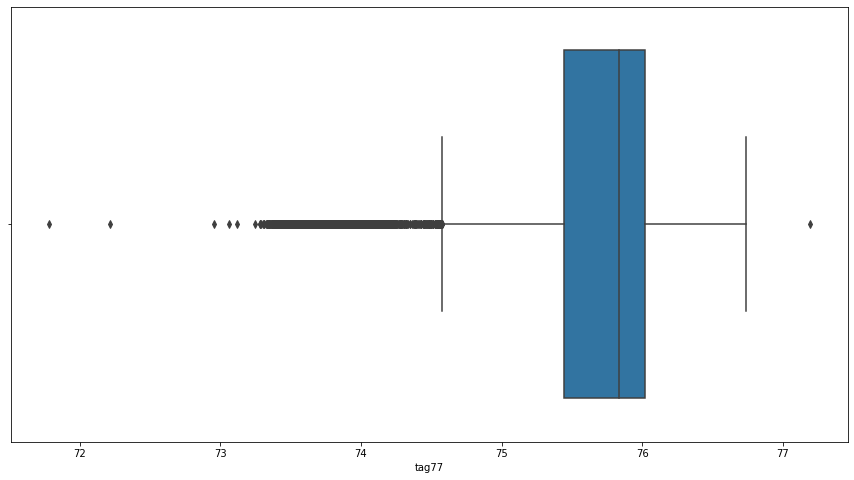

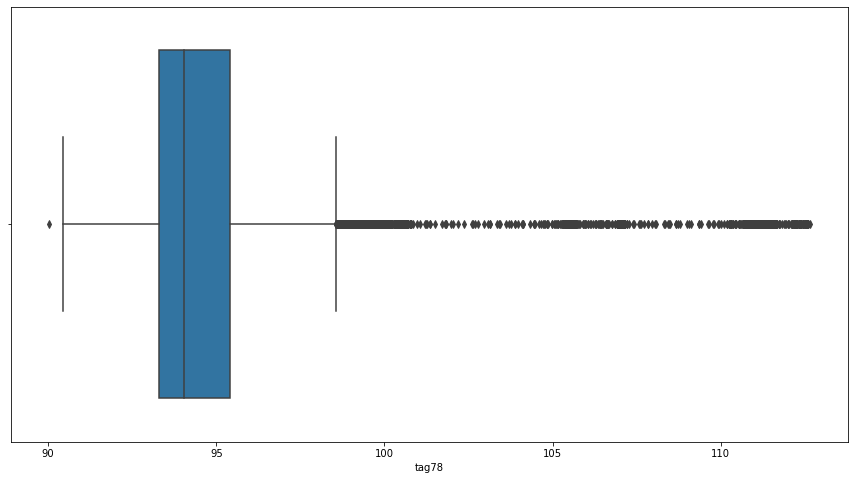

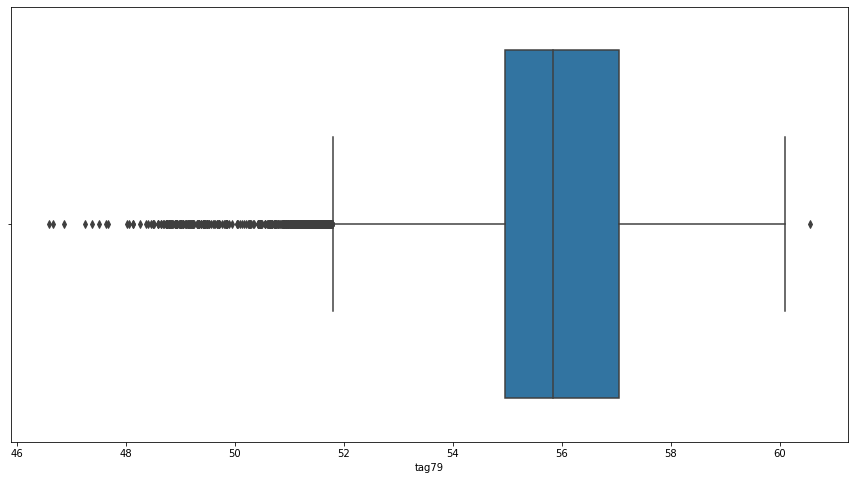

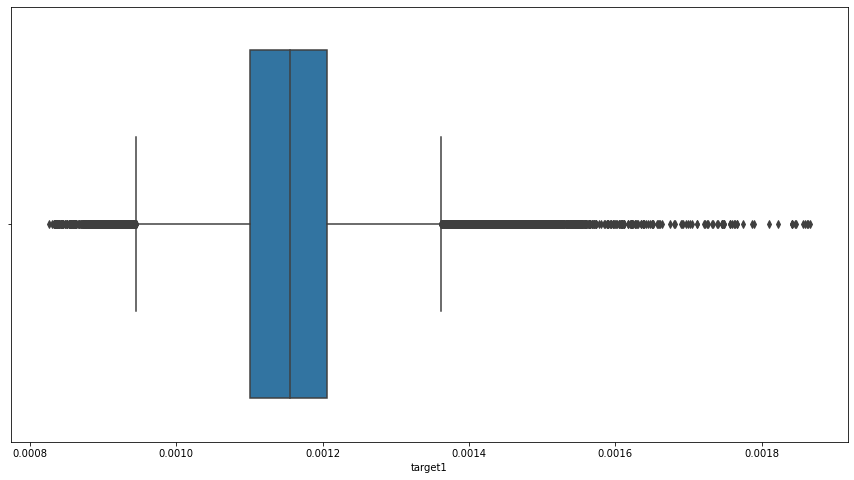

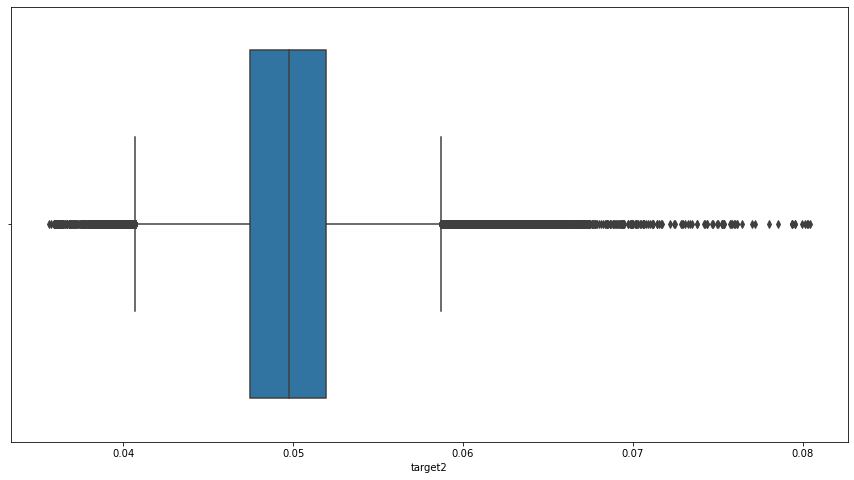

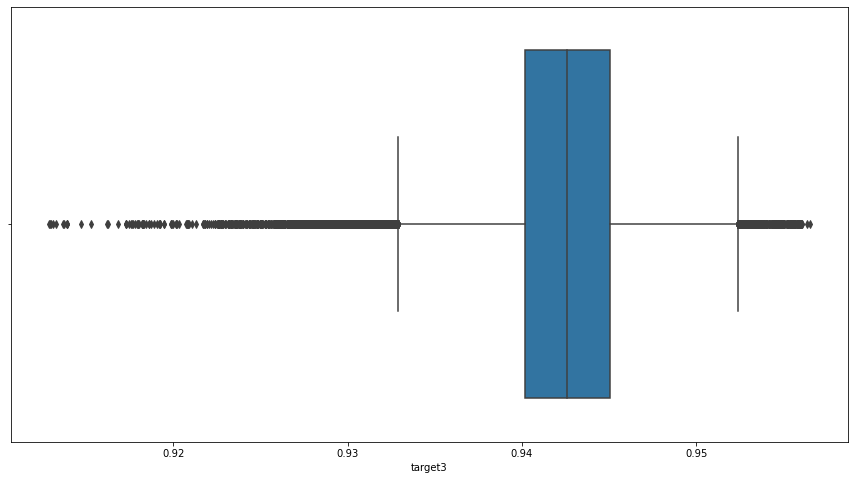

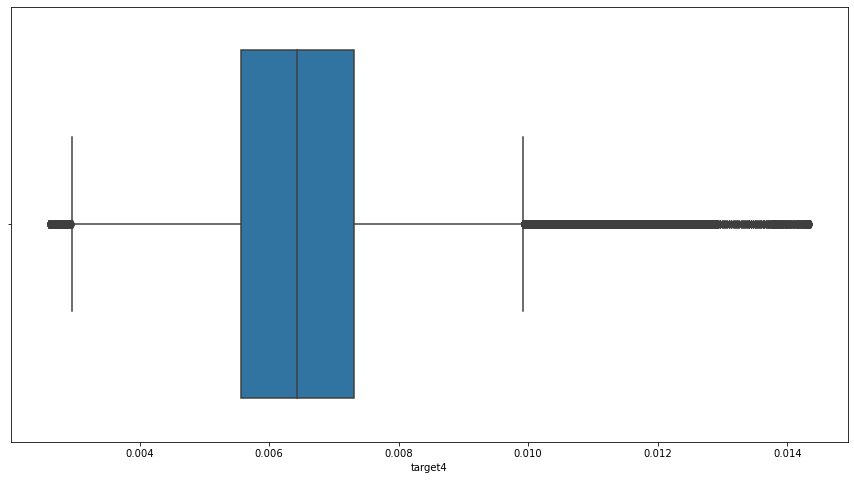

In [12]:
# займёмся выбросами. для этого построим boxplot'ы
for col in list(df)[1:]:
    plt.figure()
    sns.boxplot(x=col, data=df, orient="h")

In [13]:
# посмотрим, какой процент точек выпадает за пределы a*std для каждой из фичей
a = 4
for x in list(df)[1:]:
    print(
        x,
        '\t', 
        '{0:.2f}'.format((1 - len(df[(df[x] >= df[x].mean() - a * df[x].std()) 
                                     & (df[x] <= df[x].mean() + a * df[x].std())]) / 
                              len(df[x].dropna())) * 100)
    )

tag1 	 0.00
tag2 	 0.01
tag3 	 0.00
tag4 	 1.18
tag5 	 0.24
tag6 	 2.14
tag7 	 1.16
tag8 	 0.73
tag9 	 0.00
tag10 	 0.00
tag11 	 0.00
tag12 	 0.78
tag13 	 0.00
tag14 	 0.00
tag15 	 0.00
tag16 	 0.01
tag17 	 0.03
tag18 	 0.05
tag19 	 2.97
tag20 	 0.00
tag21 	 0.00
tag22 	 0.34
tag23 	 0.61
tag24 	 0.00
tag25 	 0.00
tag26 	 0.00
tag27 	 0.00
tag28 	 0.00
tag29 	 0.00
tag30 	 0.00
tag31 	 0.00
tag32 	 0.00
tag33 	 0.00
tag34 	 0.00
tag35 	 0.00
tag36 	 0.20
tag37 	 0.36
tag38 	 0.00
tag39 	 0.03
tag40 	 0.25
tag41 	 0.78
tag42 	 0.00
tag43 	 0.06
tag44 	 0.98
tag45 	 0.22
tag46 	 0.00
tag47 	 0.06
tag48 	 0.82
tag49 	 0.09
tag50 	 0.02
tag51 	 0.05
tag52 	 1.34
tag53 	 0.21
tag54 	 0.23
tag55 	 0.11
tag56 	 0.00
tag57 	 0.00
tag58 	 0.12
tag59 	 0.35
tag60 	 0.02
tag61 	 0.74
tag62 	 0.16
tag63 	 0.13
tag64 	 0.00
tag65 	 0.00
tag66 	 0.01
tag67 	 0.29
tag68 	 0.00
tag69 	 0.46
tag70 	 0.00
tag71 	 0.08
tag72 	 0.00
tag73 	 0.12
tag74 	 0.00
tag75 	 0.09
tag76 	 0.09
tag77 	 0.00
tag78 	 

In [14]:
# попробуем выкинуть точки за пределами интервала a*std, посмотрим, сколько строк на этом будет потеряно
L = len(df)
Li = L
for x in list(df)[1:]:
#    df.drop(df[(df[x].notnull()) & ((df[x] < df[x].quantile(q=0.25) - 1.5 * (df[x].quantile(q=0.75) - df[x].quantile(q=0.25))) | (df[x] > df[x].quantile(q=0.75) + 1.5 * (df[x].quantile(q=0.75) - df[x].quantile(q=0.25))))].index, inplace=True)
    df.drop(df[
        (df[x].notnull()) & 
        ((df[x] < df[x].mean() - a * df[x].std()) | 
         (df[x] > df[x].mean() + a * df[x].std())
        )].index, inplace=True)
    df = df.reset_index(drop=True)
#    df = df[(df[x] >= df[x].mean() - 3 * df[x].std()) & (df[x] <= df[x].mean() + 3 * df[x].std())]
    print(x+':\t дропнуто ', L - len(df),' строк')
    L = len(df)
print('всего дропнуто строк ', Li - L ,' из ', Li)

tag1:	 дропнуто  3  строк
tag2:	 дропнуто  9  строк
tag3:	 дропнуто  0  строк
tag4:	 дропнуто  1  строк
tag5:	 дропнуто  23  строк
tag6:	 дропнуто  8  строк
tag7:	 дропнуто  1024  строк
tag8:	 дропнуто  118  строк
tag9:	 дропнуто  0  строк
tag10:	 дропнуто  0  строк
tag11:	 дропнуто  0  строк
tag12:	 дропнуто  1543  строк
tag13:	 дропнуто  0  строк
tag14:	 дропнуто  4  строк
tag15:	 дропнуто  11  строк
tag16:	 дропнуто  19  строк
tag17:	 дропнуто  50  строк
tag18:	 дропнуто  102  строк
tag19:	 дропнуто  2973  строк
tag20:	 дропнуто  0  строк
tag21:	 дропнуто  0  строк
tag22:	 дропнуто  660  строк
tag23:	 дропнуто  1212  строк
tag24:	 дропнуто  0  строк
tag25:	 дропнуто  0  строк
tag26:	 дропнуто  0  строк
tag27:	 дропнуто  0  строк
tag28:	 дропнуто  0  строк
tag29:	 дропнуто  0  строк
tag30:	 дропнуто  0  строк
tag31:	 дропнуто  0  строк
tag32:	 дропнуто  0  строк
tag33:	 дропнуто  0  строк
tag34:	 дропнуто  0  строк
tag35:	 дропнуто  0  строк
tag36:	 дропнуто  67  строк
tag37:	 дропну

In [15]:
# я решил оставить 4std, так как распределения не нормальные, 
# 3std приводит к потере четверти данных
# закоменченный перцентильный критерий убирает более половины
# при 4std уходит 8%, будем считать, что это приемлемо
# по-хорошему, надо каждый признак по-отдельности рассматривать

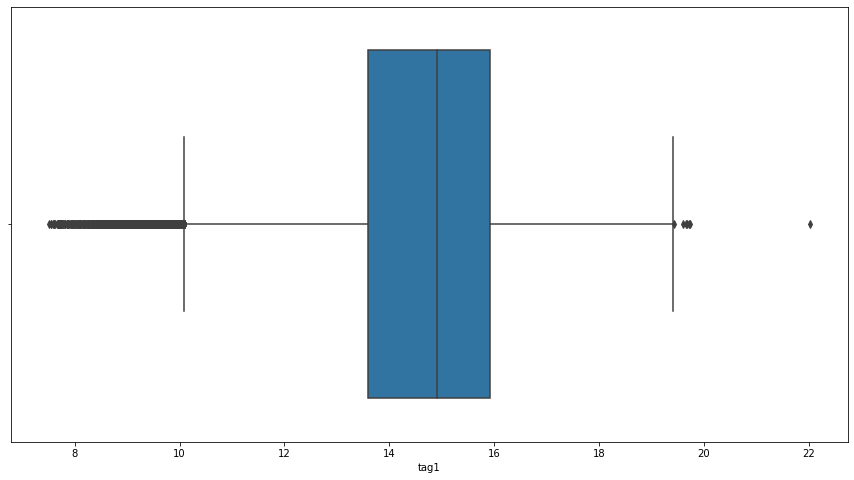

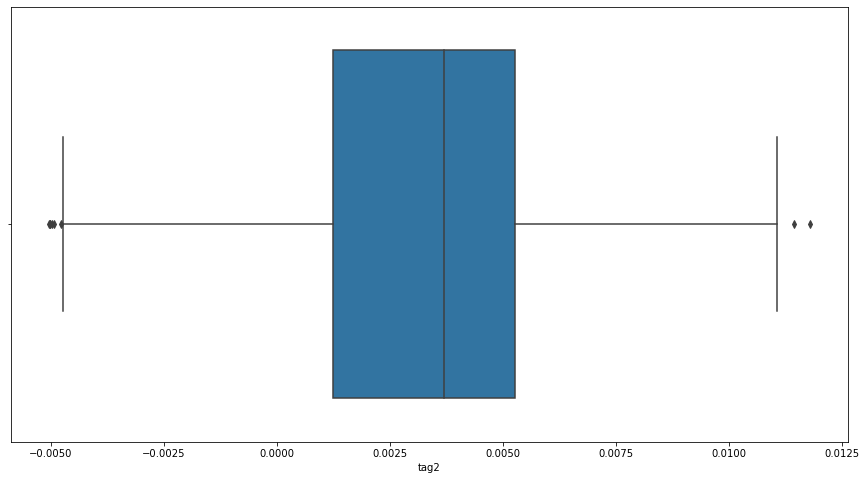

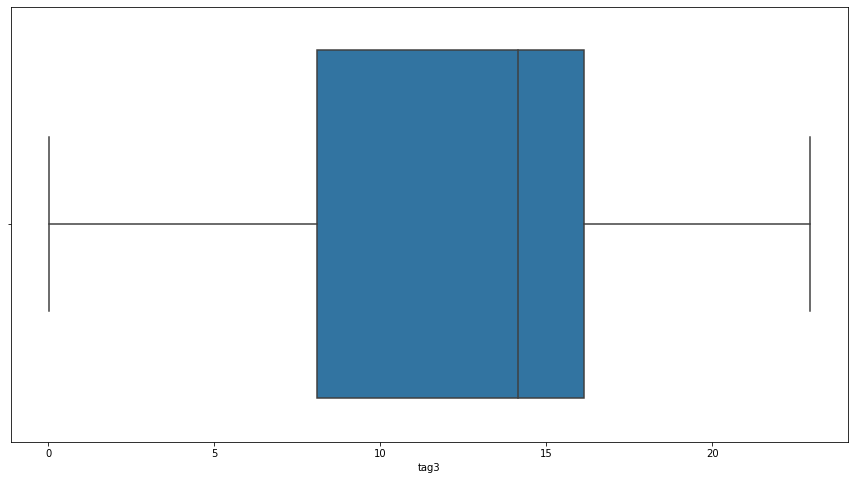

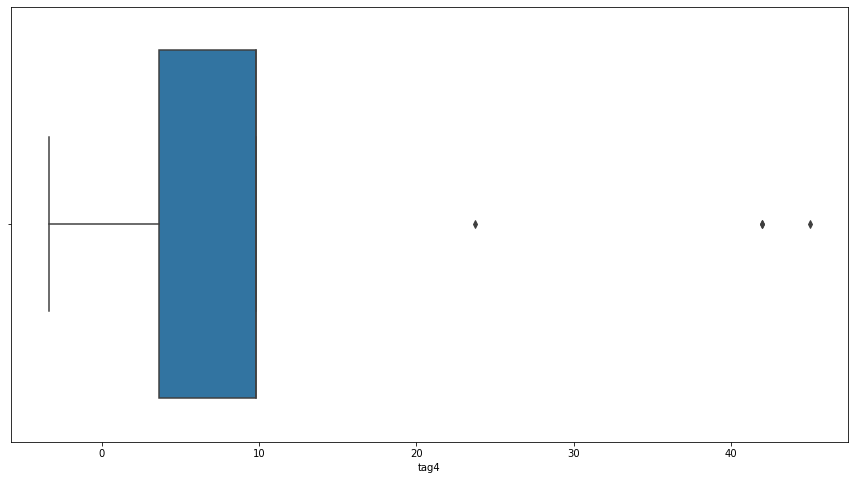

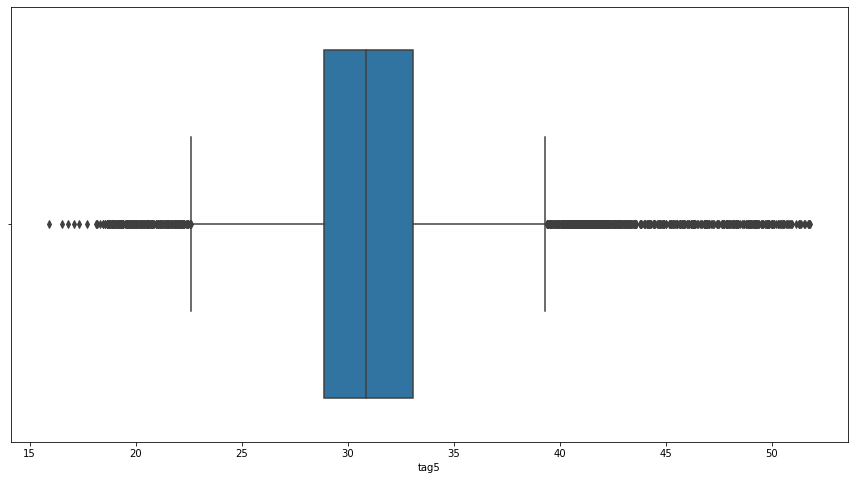

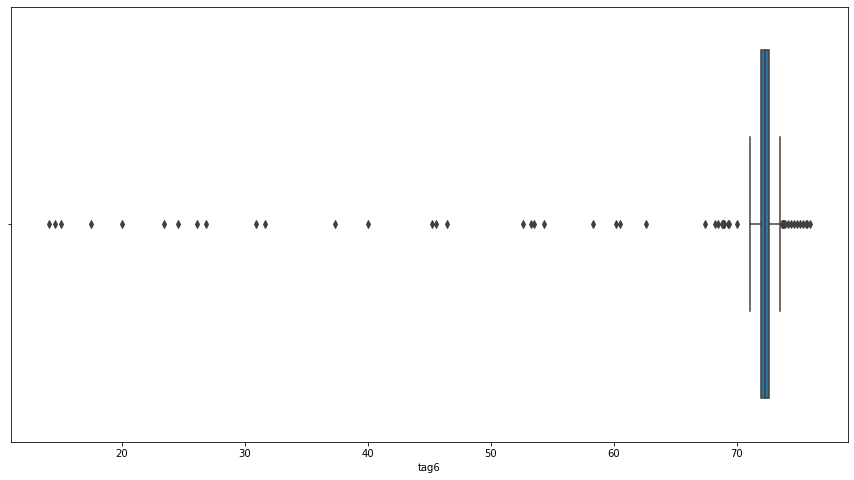

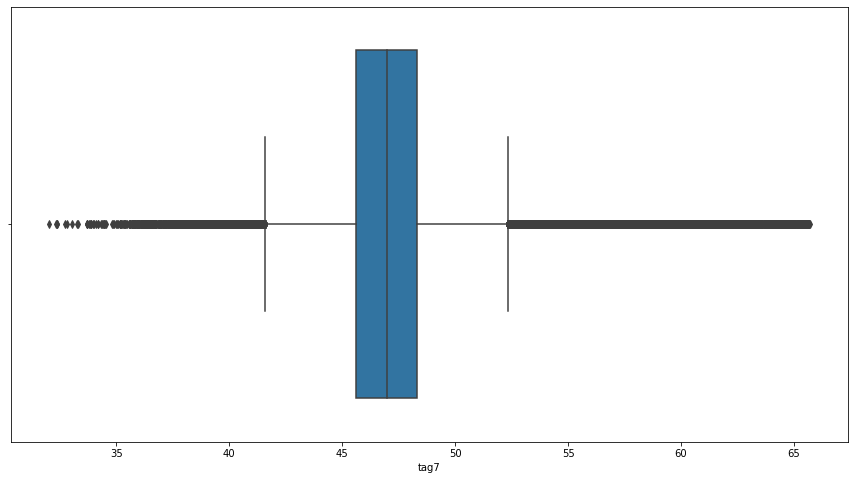

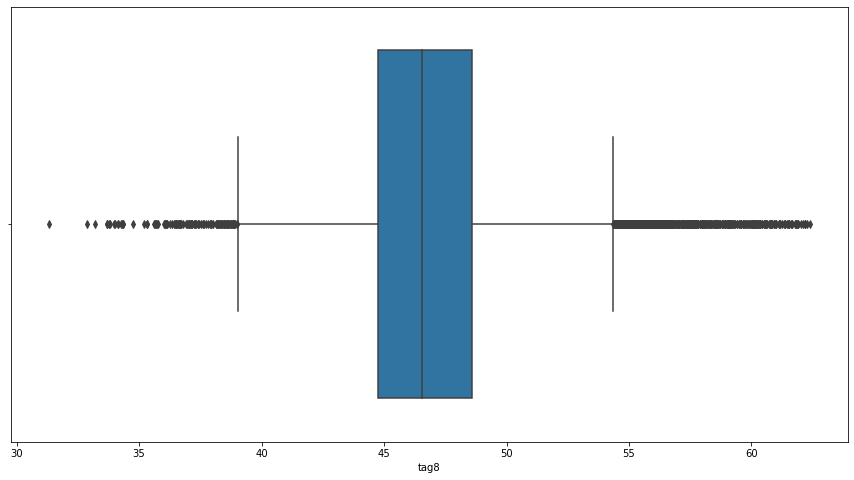

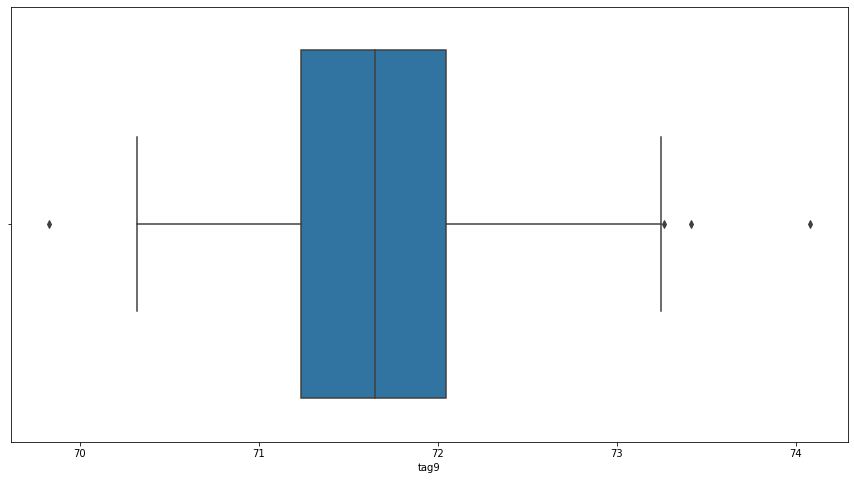

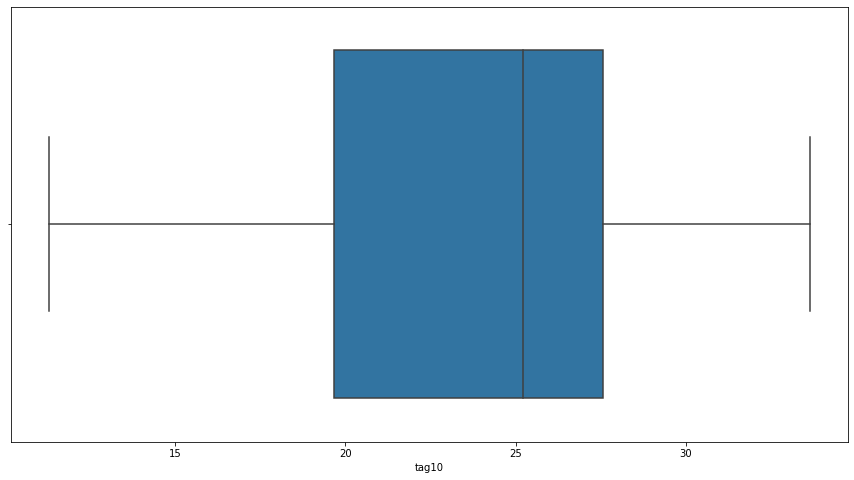

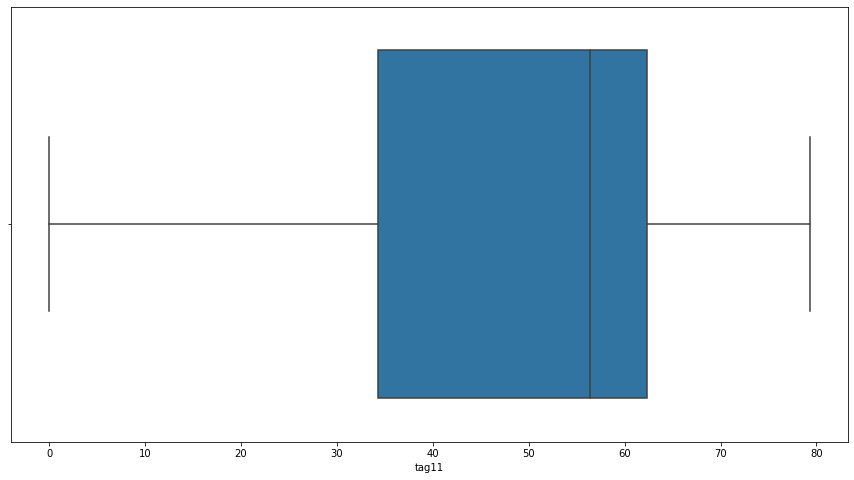

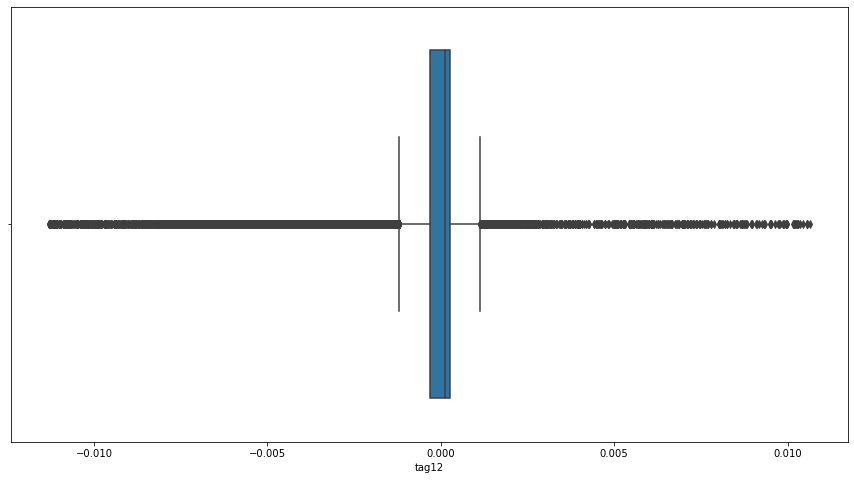

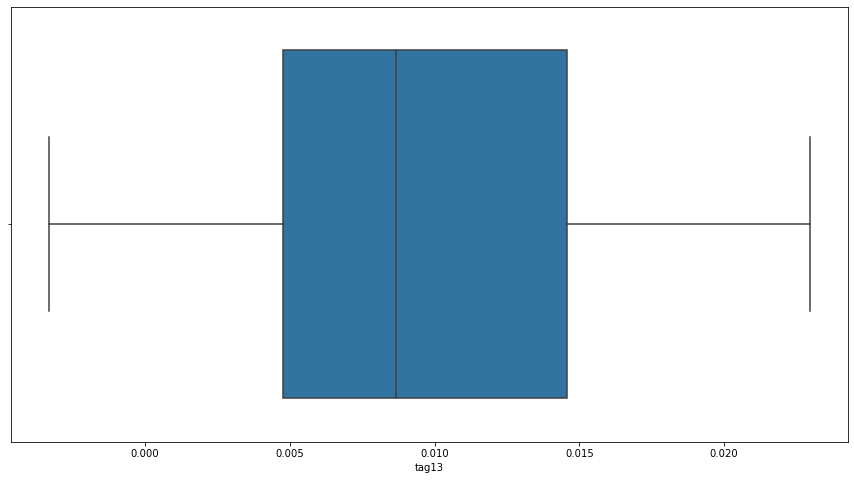

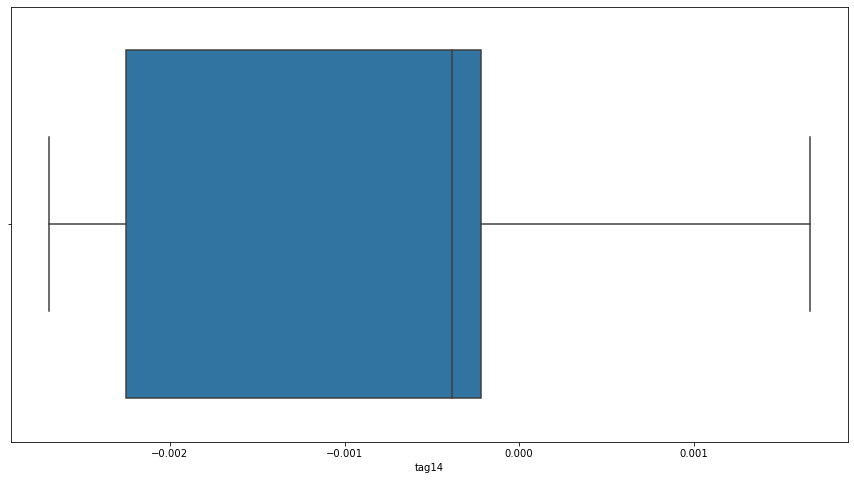

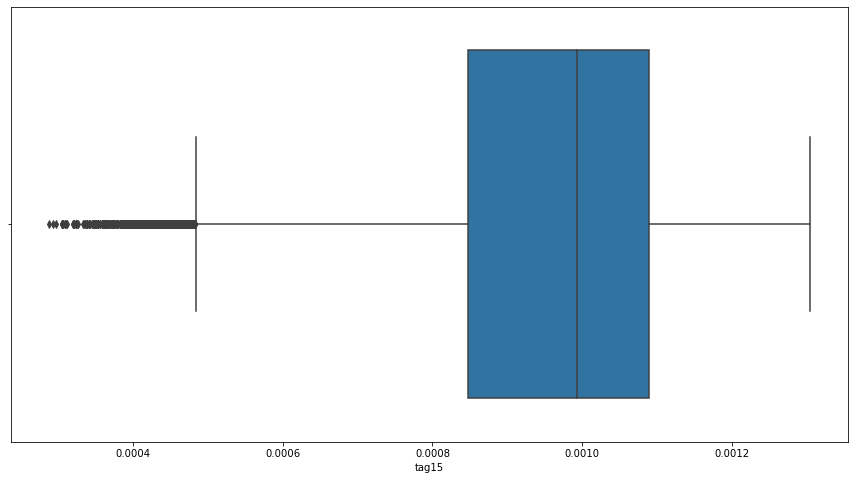

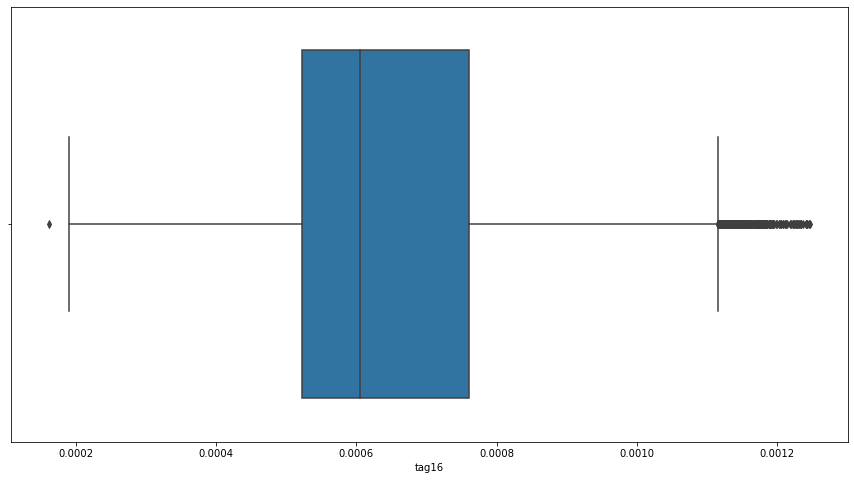

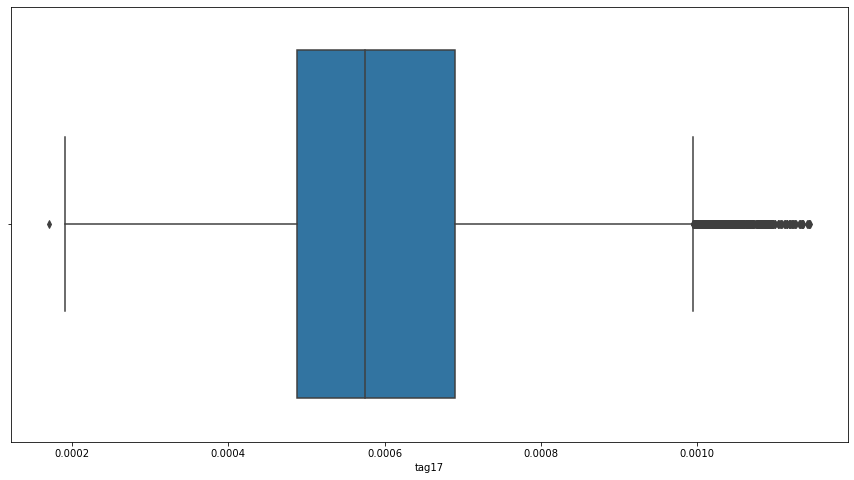

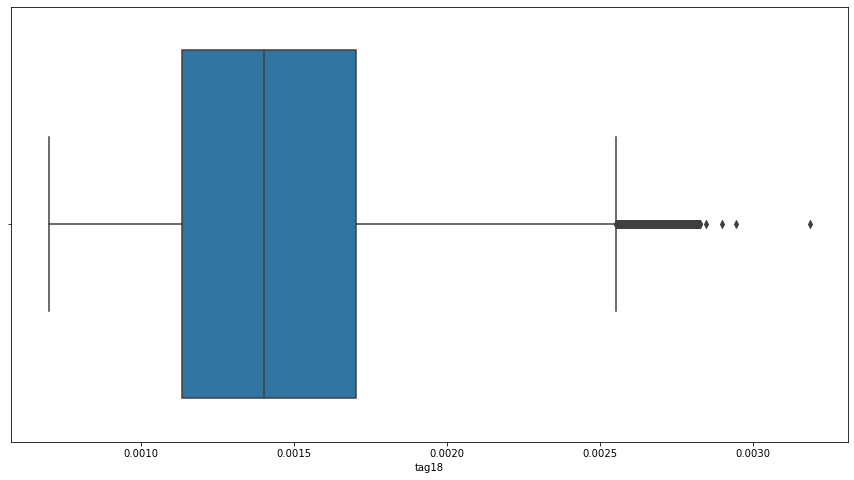

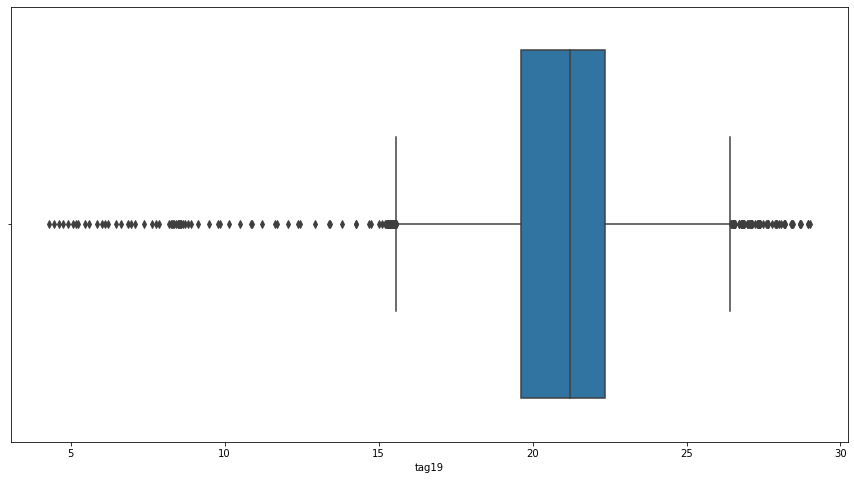

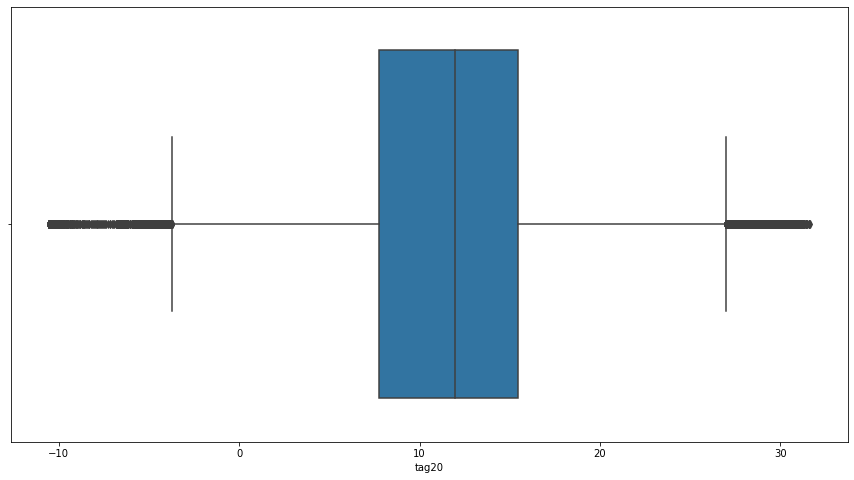

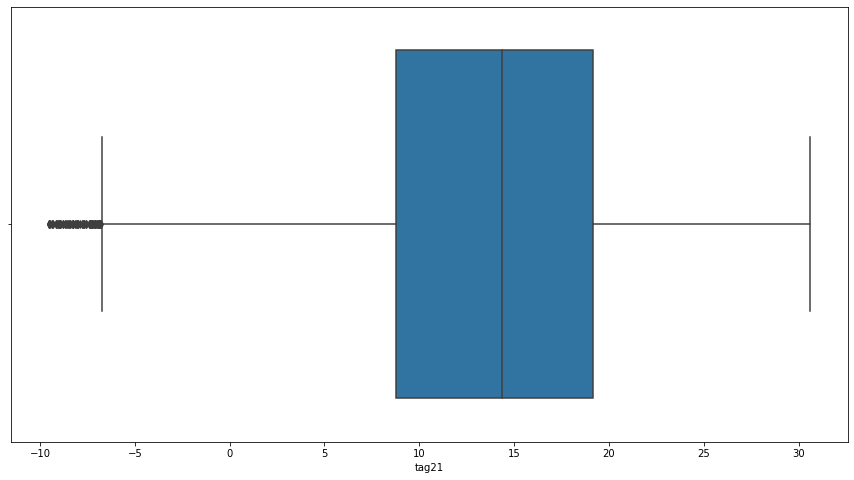

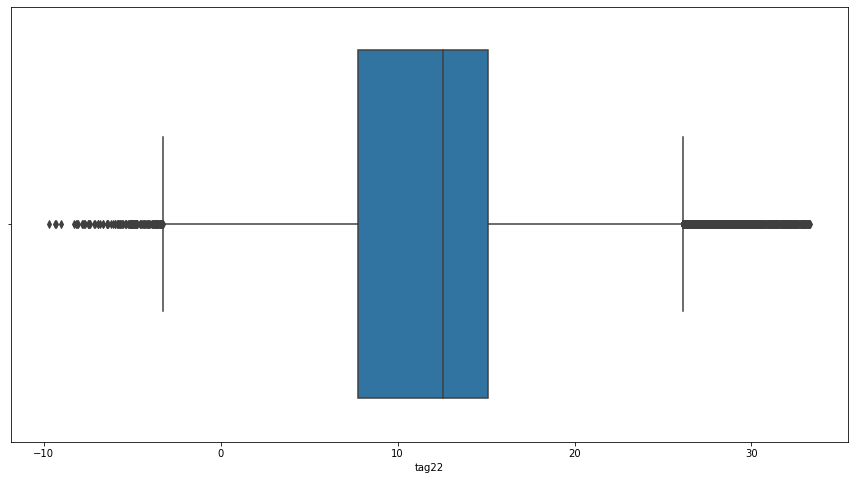

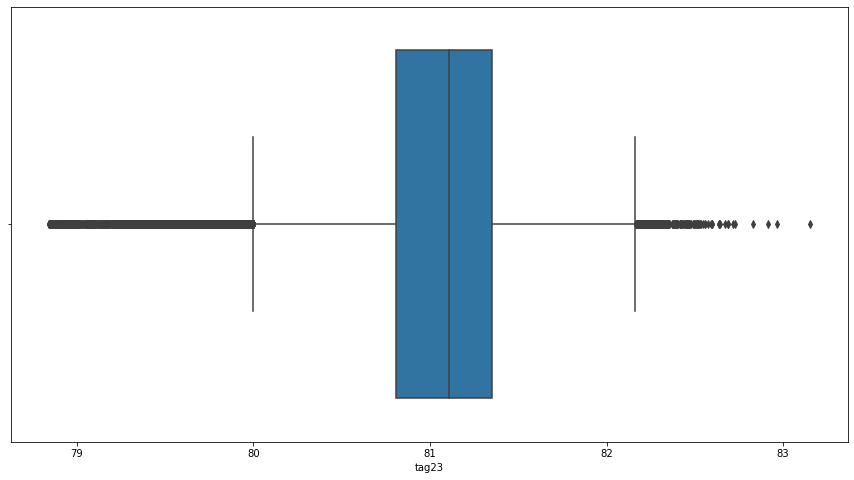

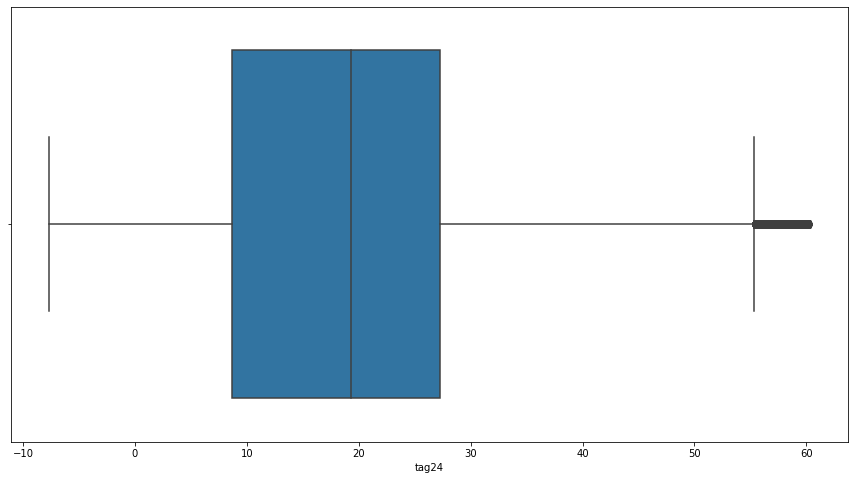

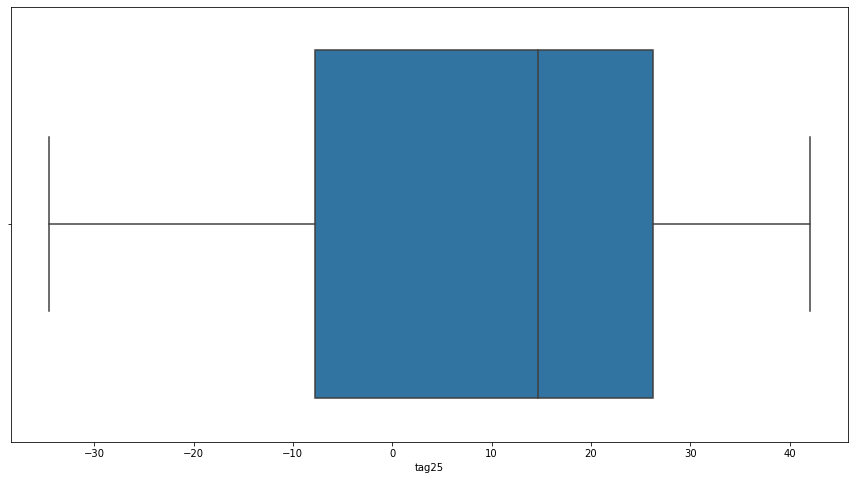

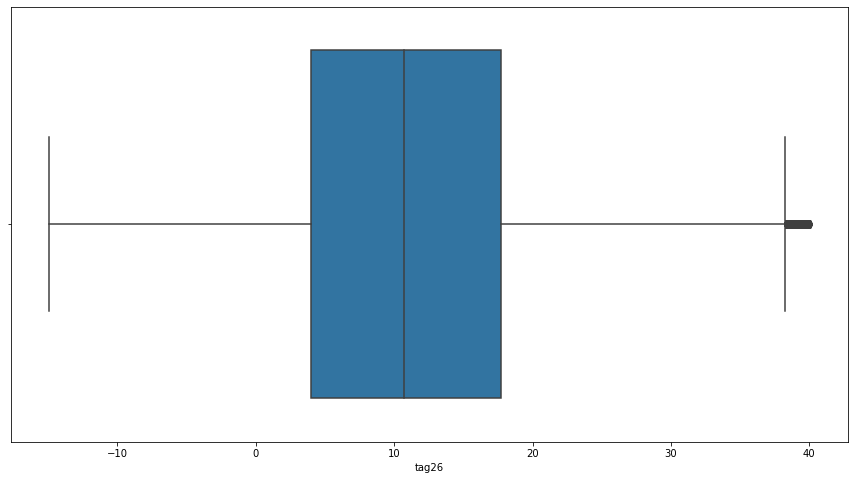

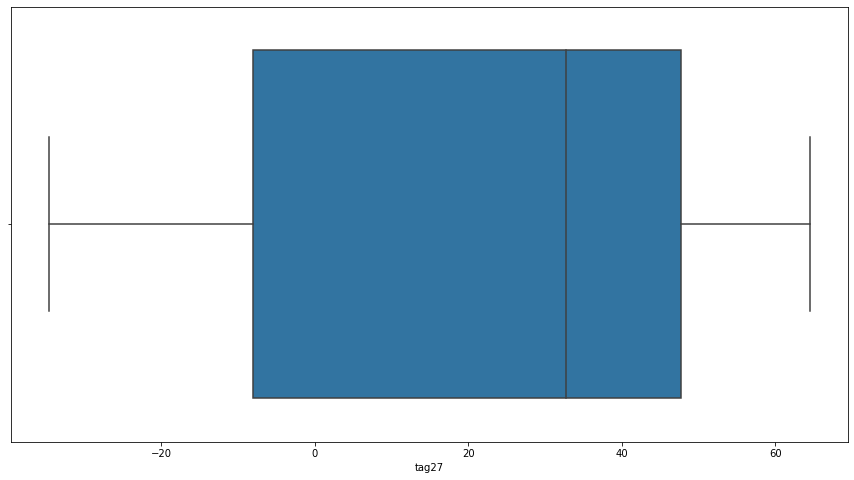

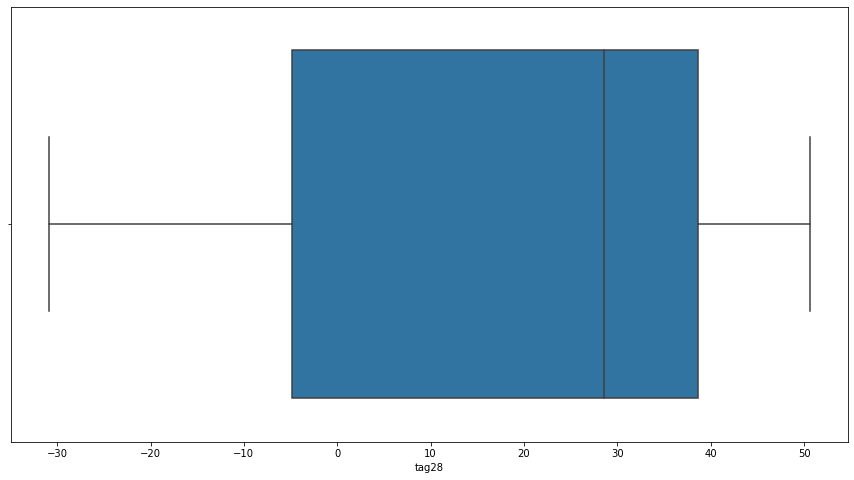

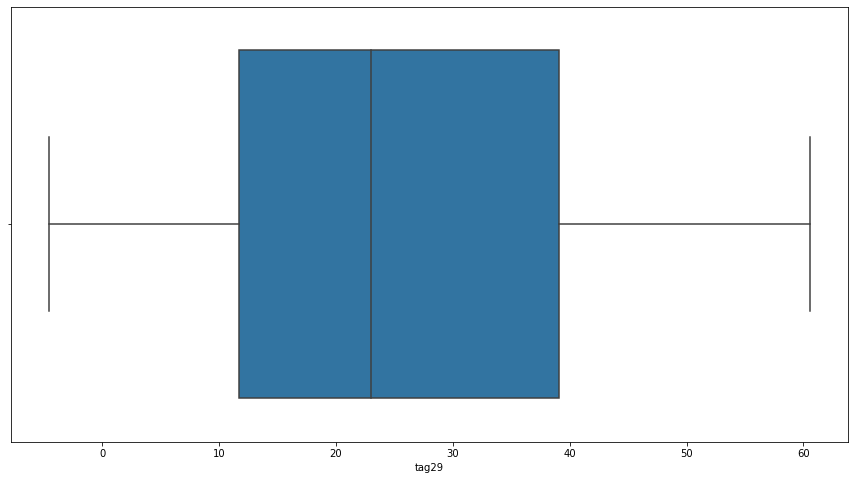

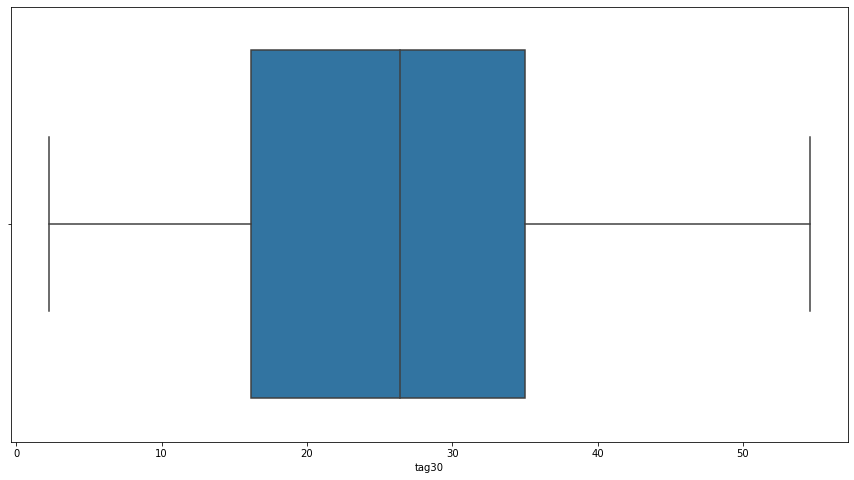

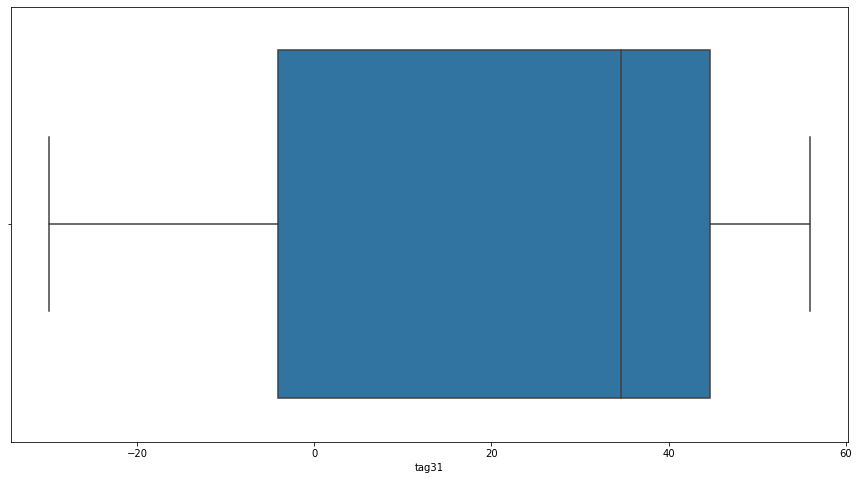

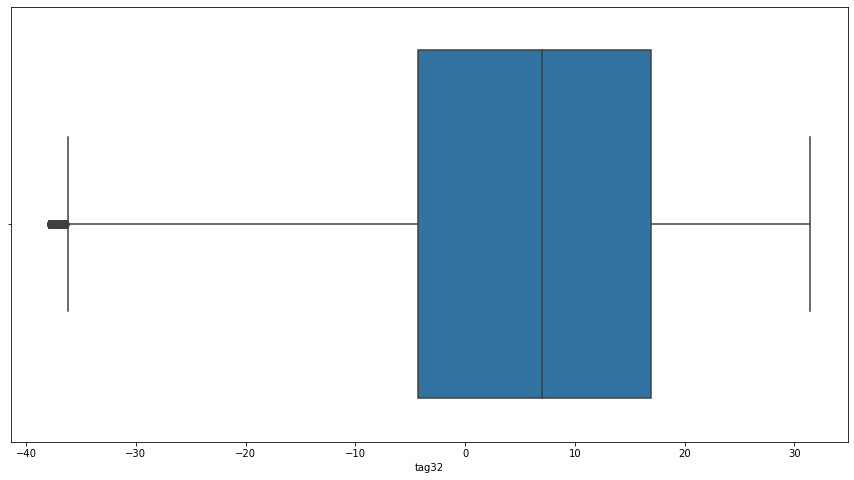

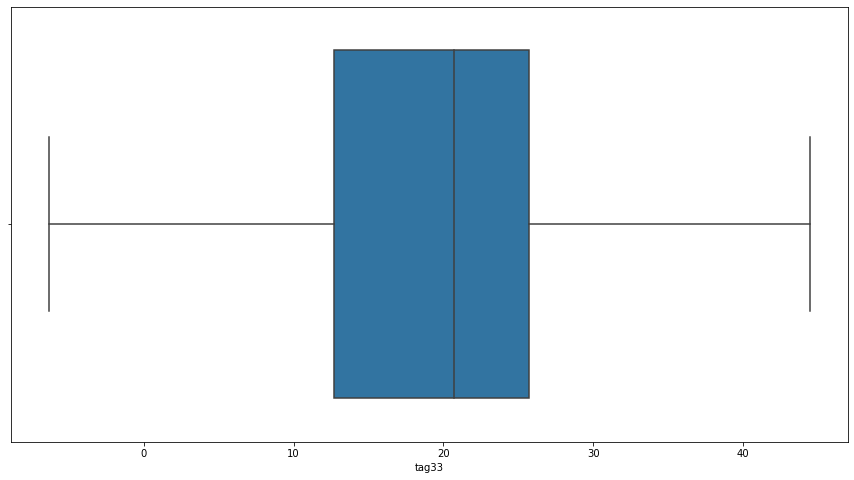

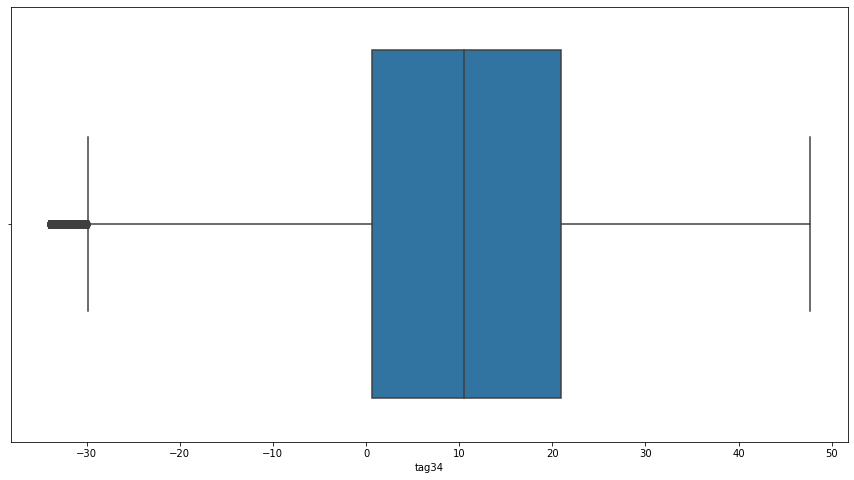

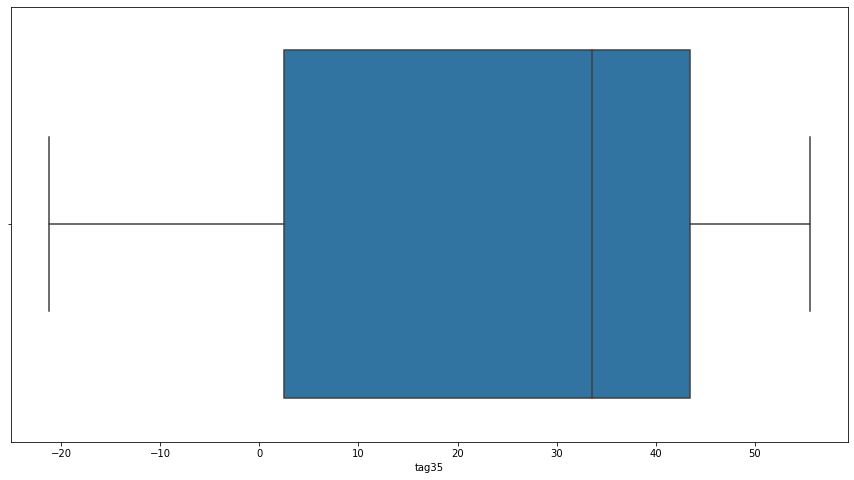

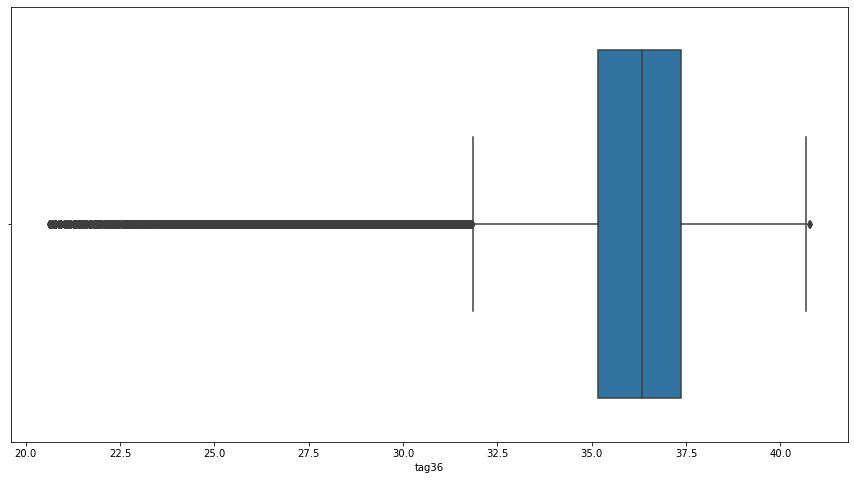

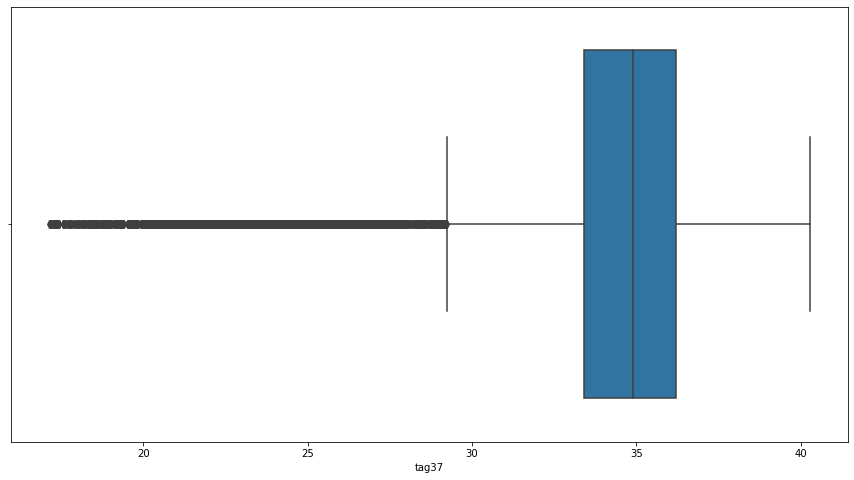

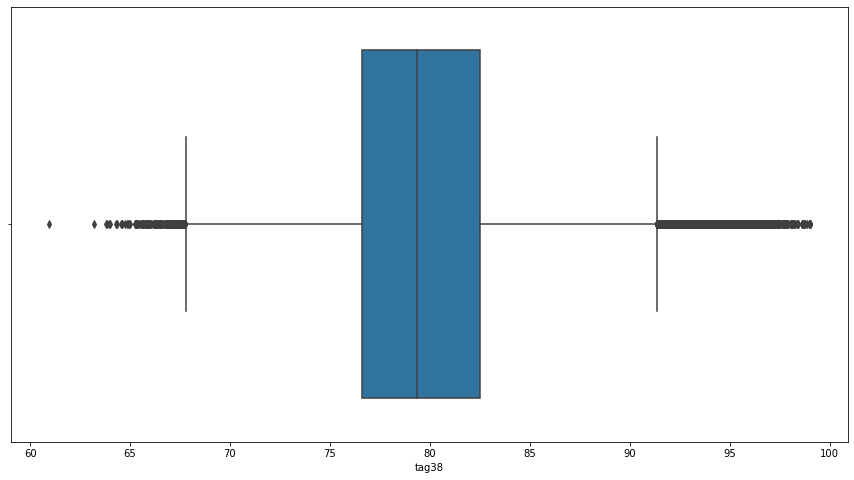

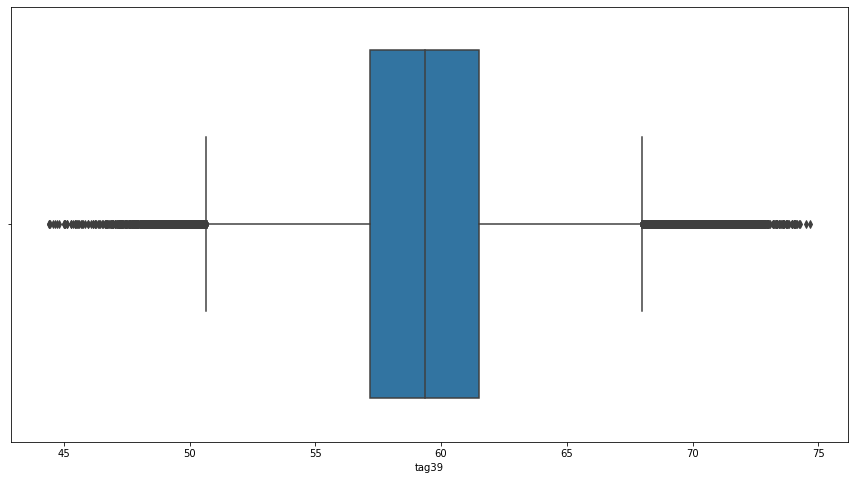

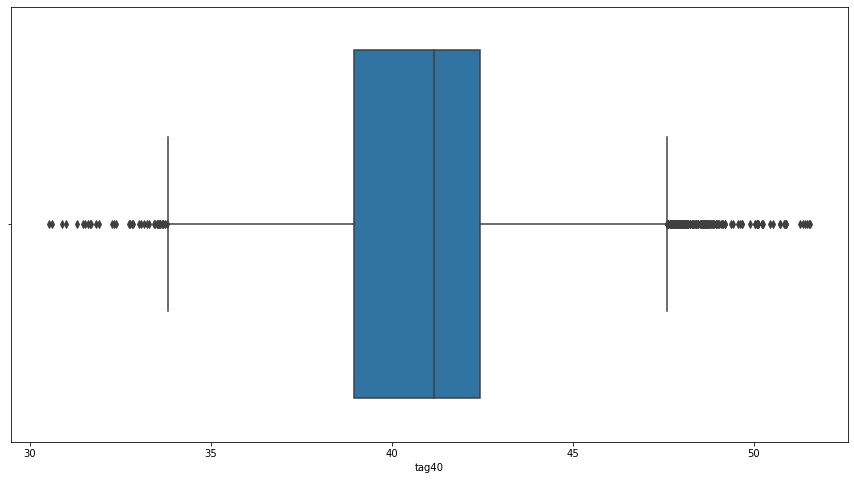

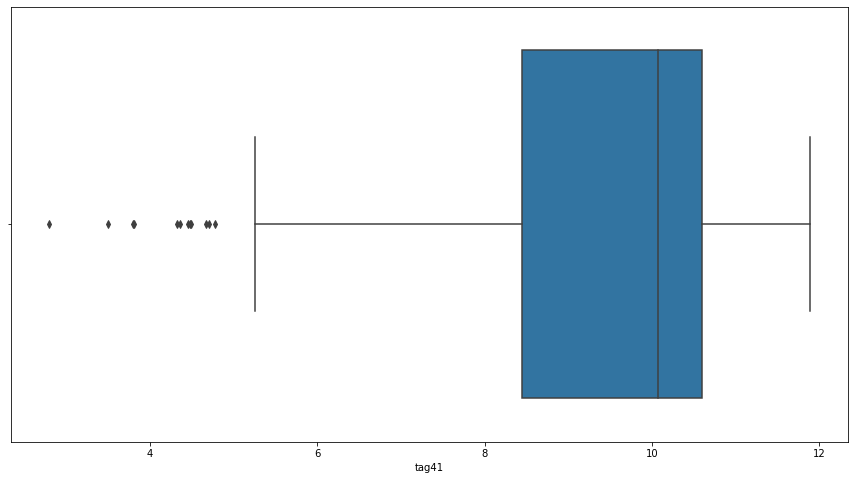

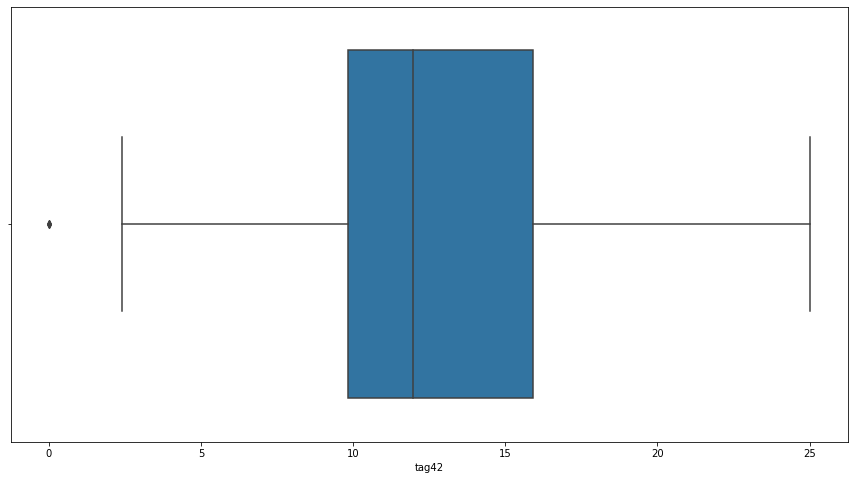

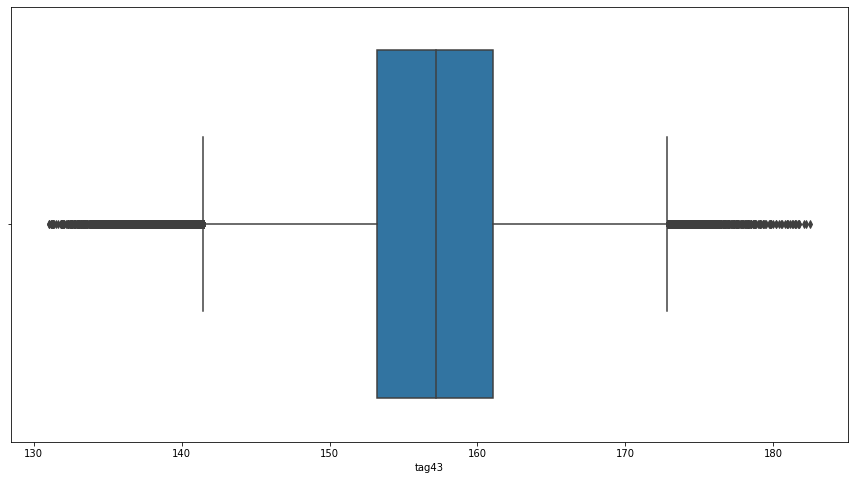

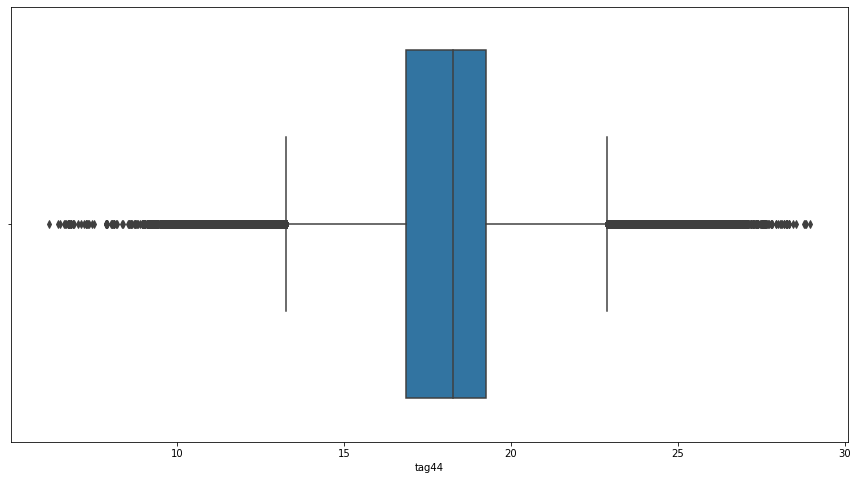

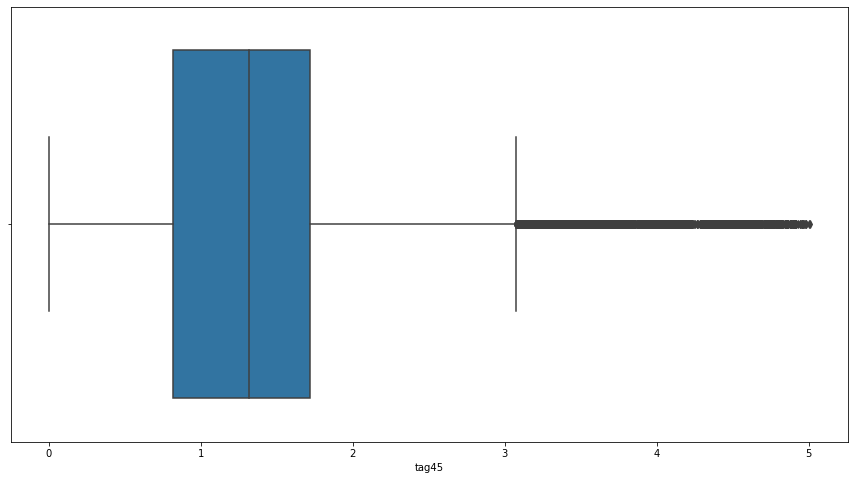

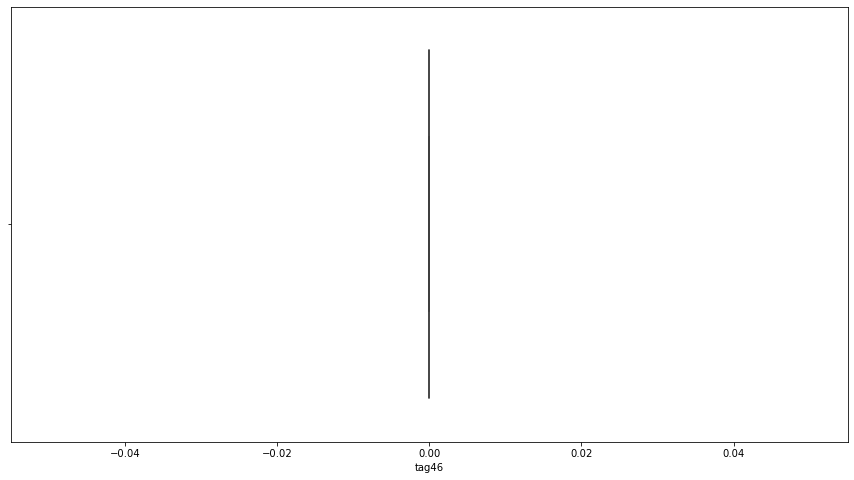

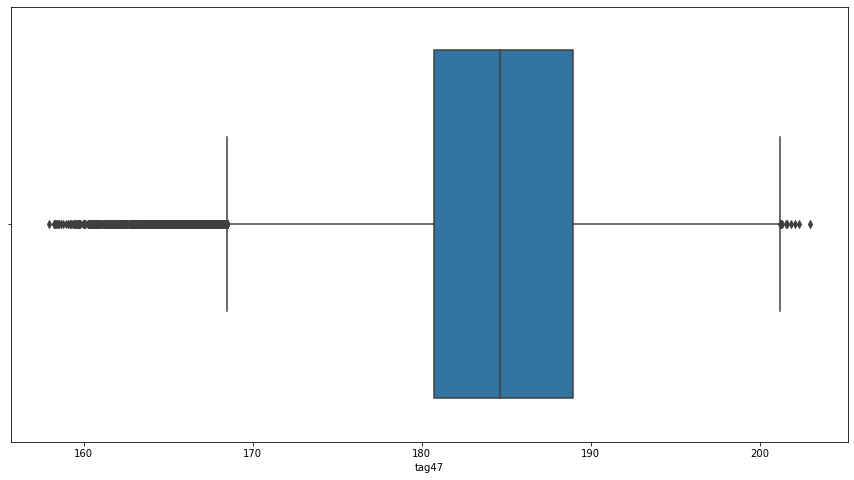

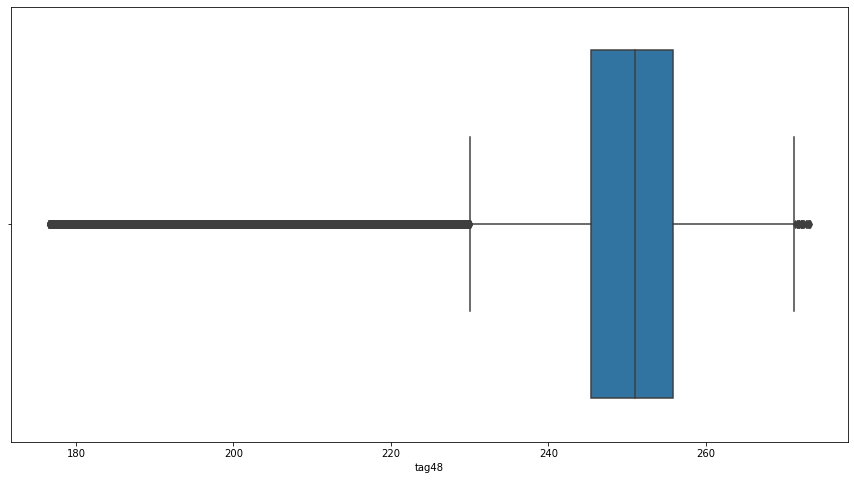

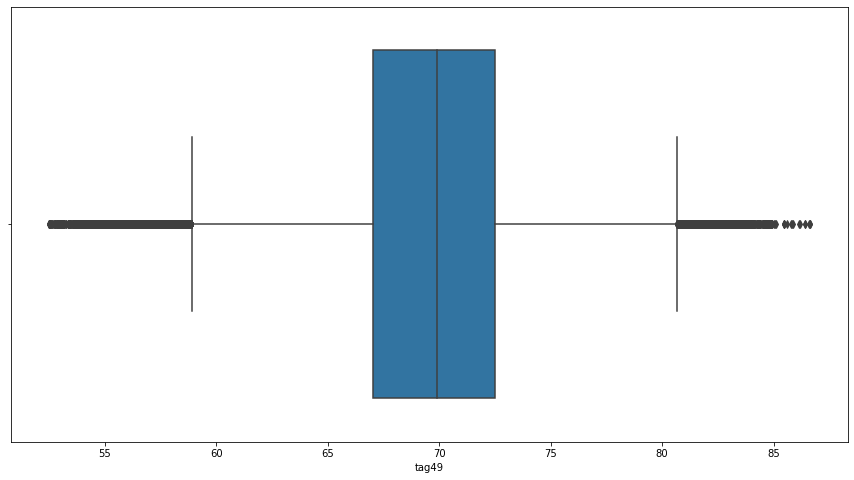

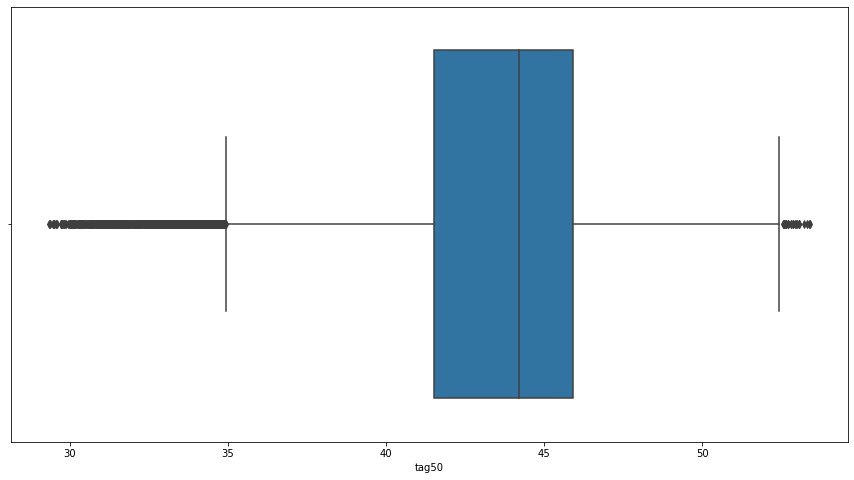

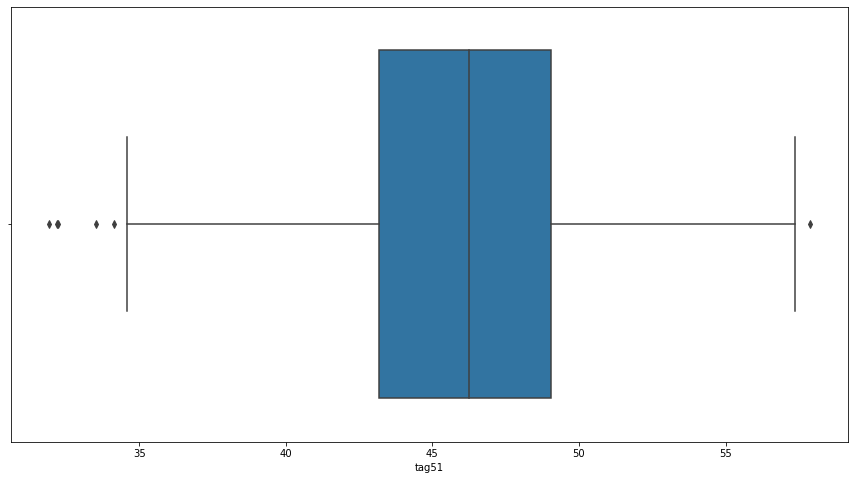

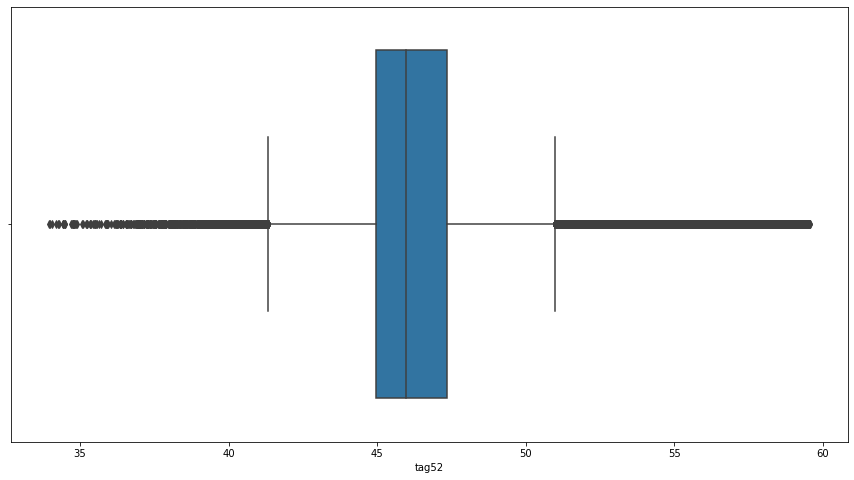

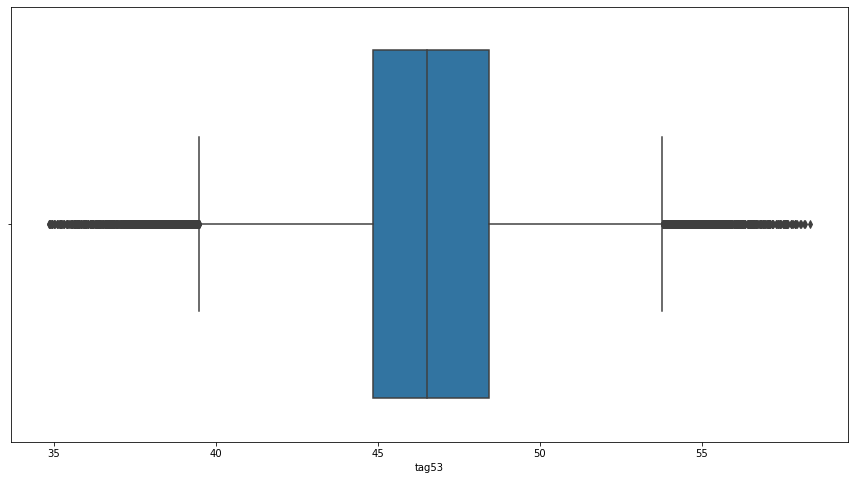

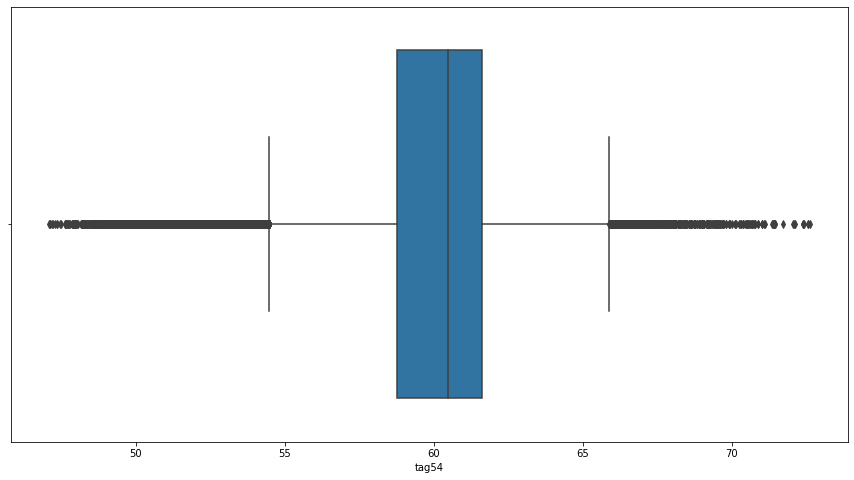

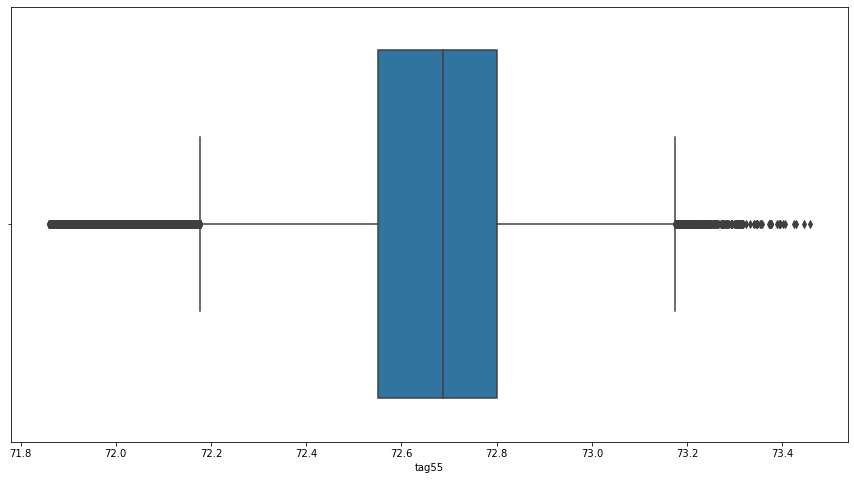

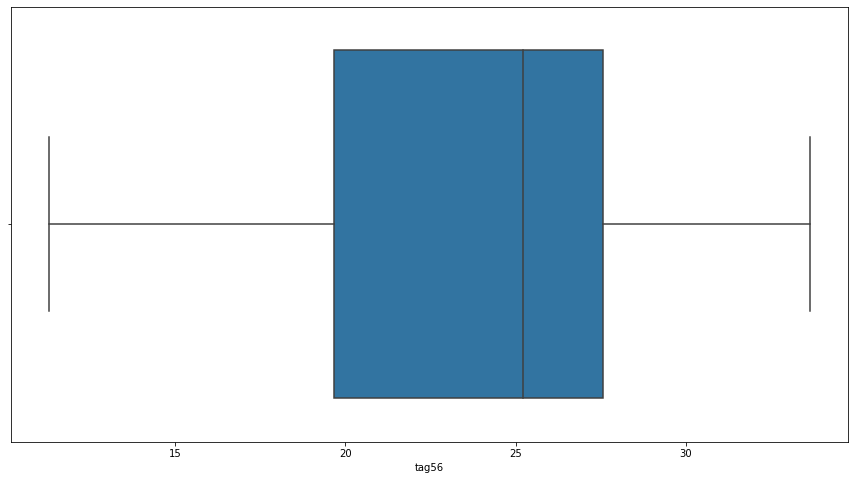

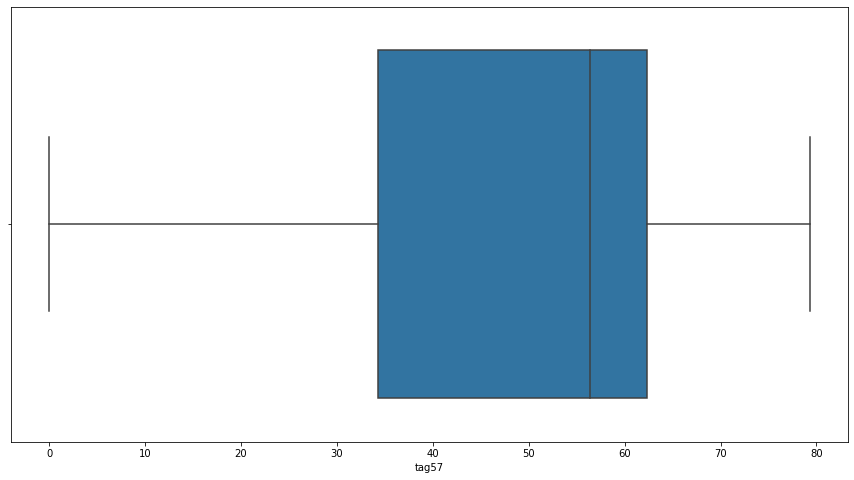

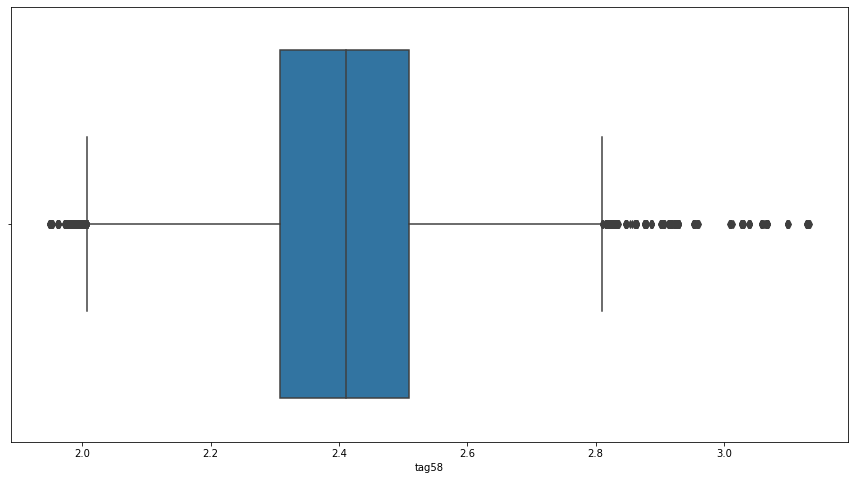

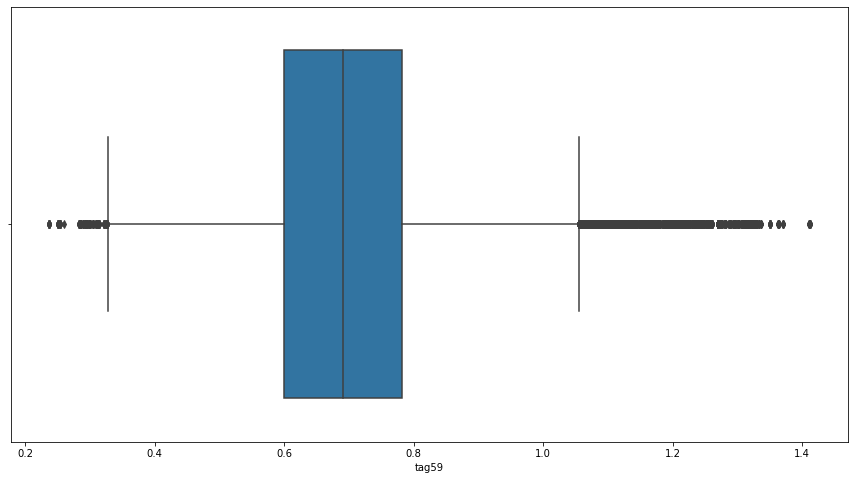

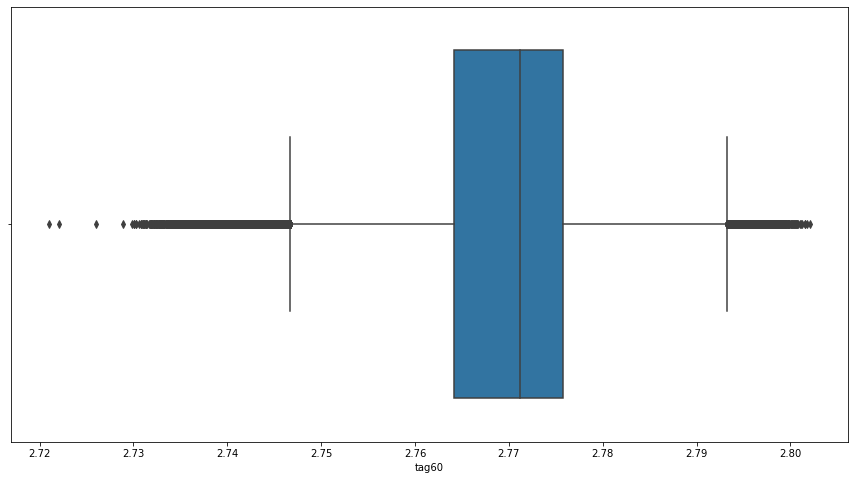

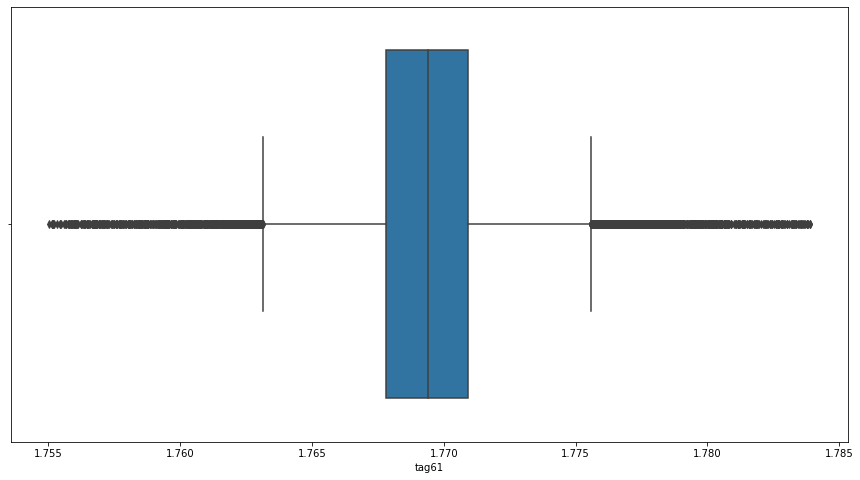

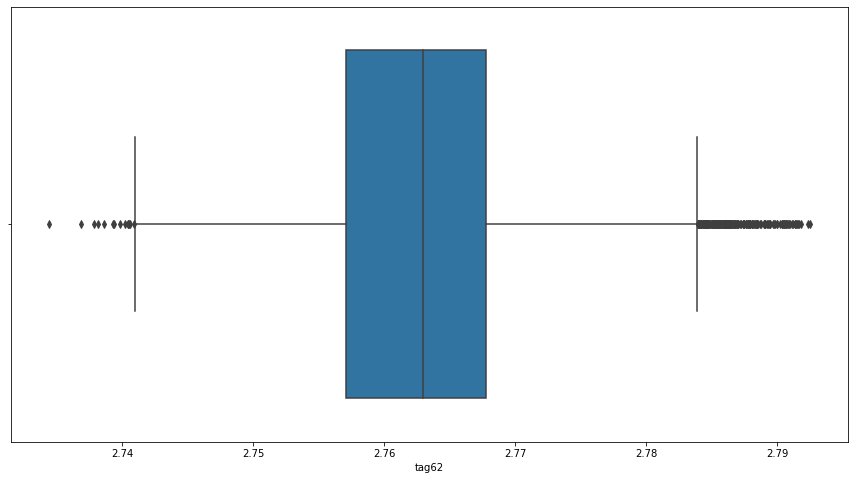

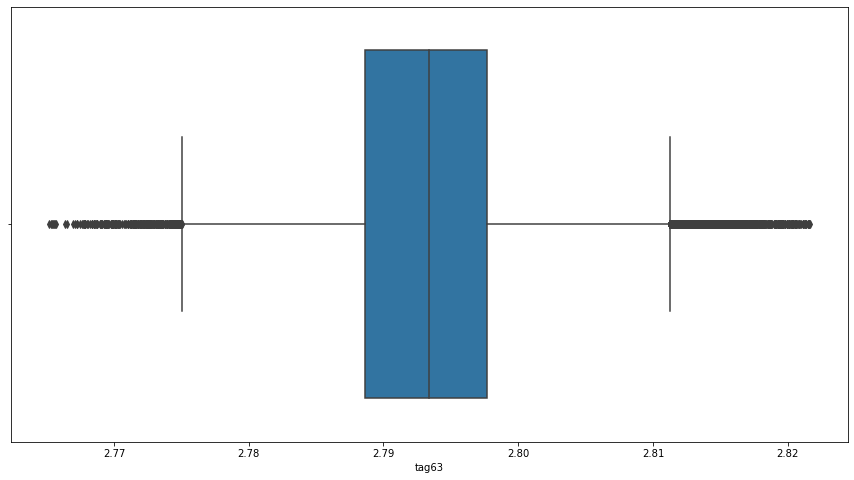

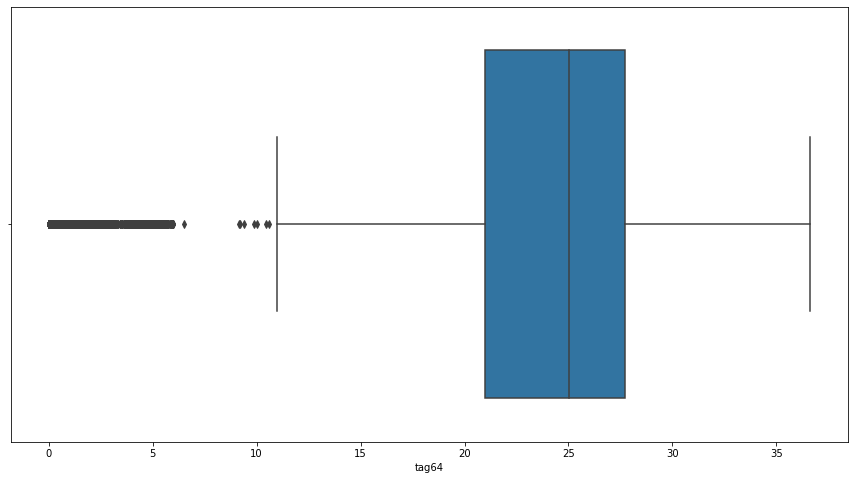

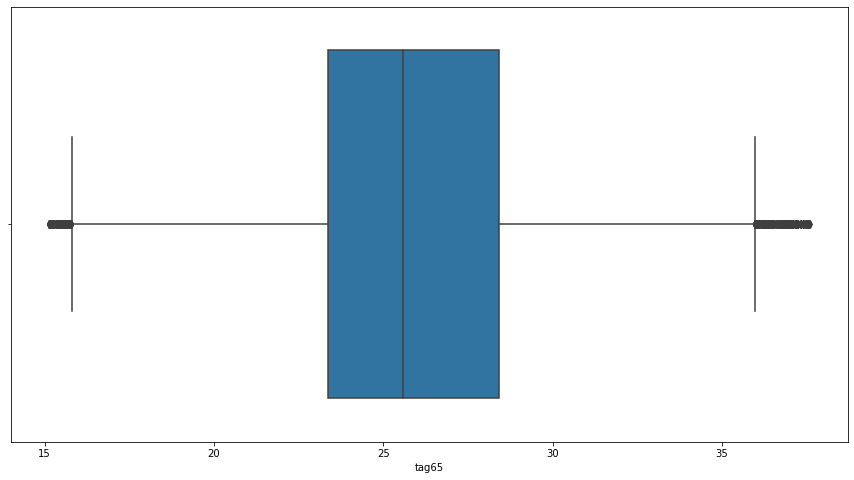

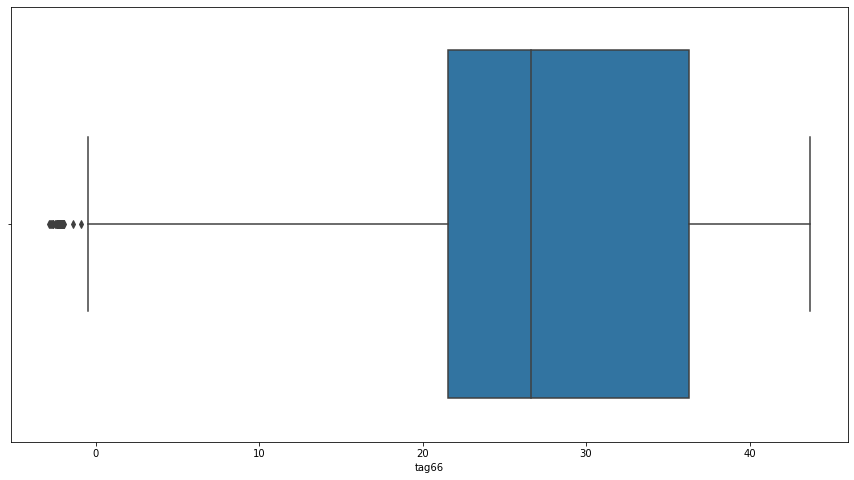

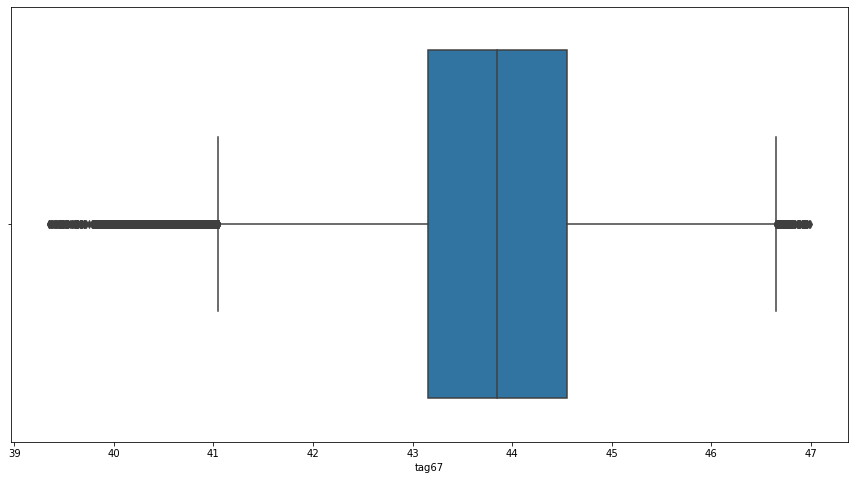

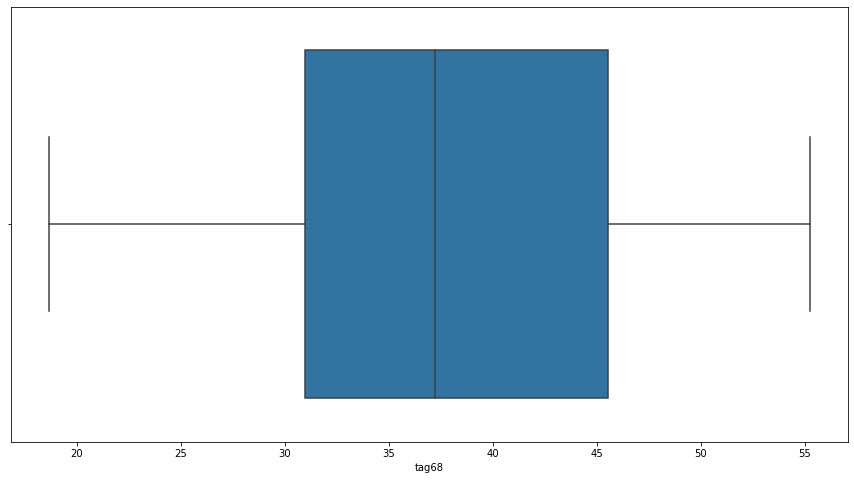

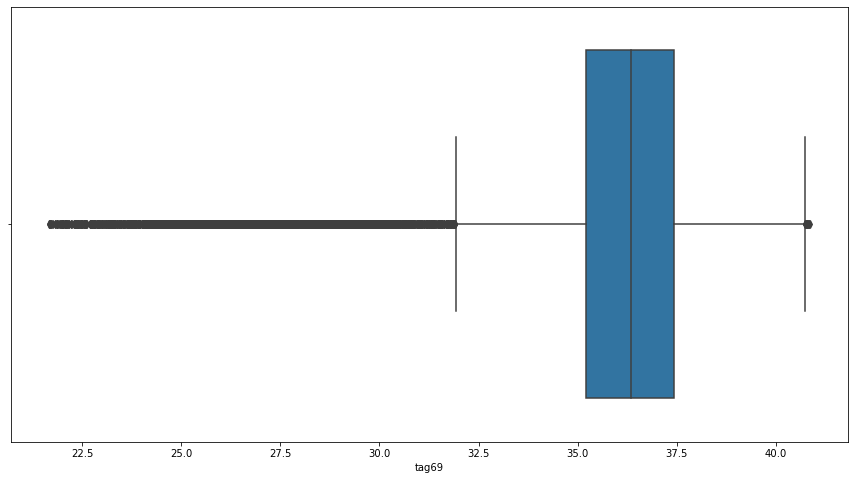

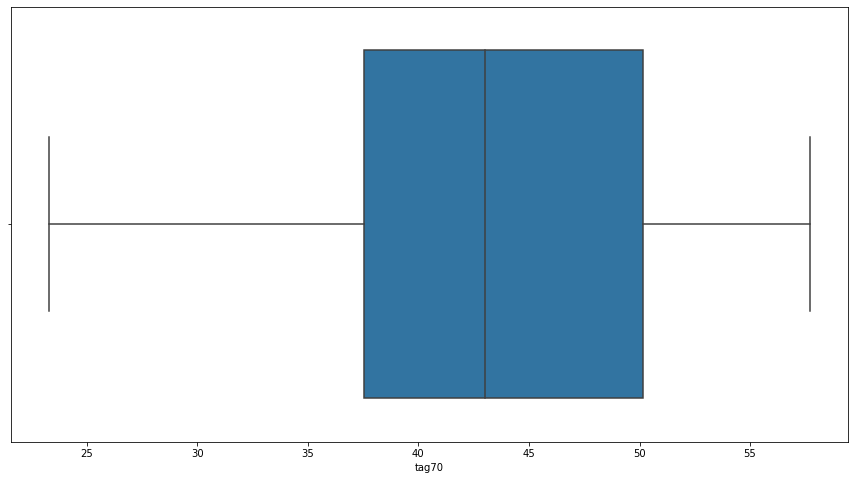

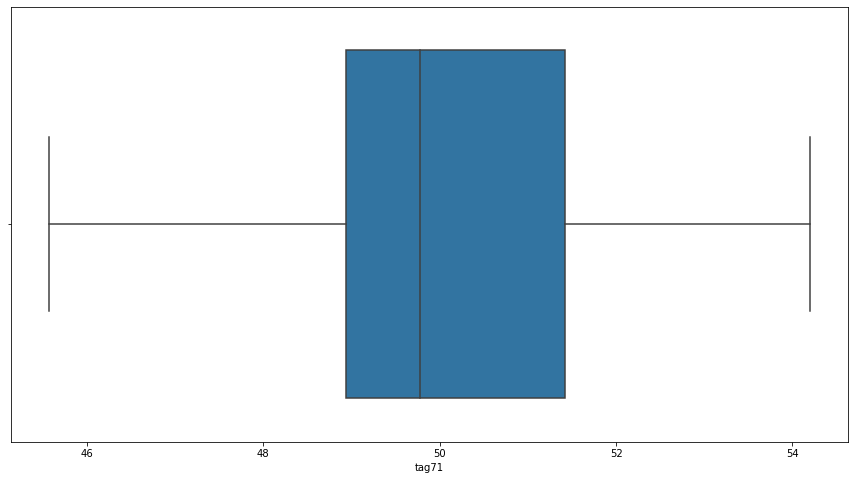

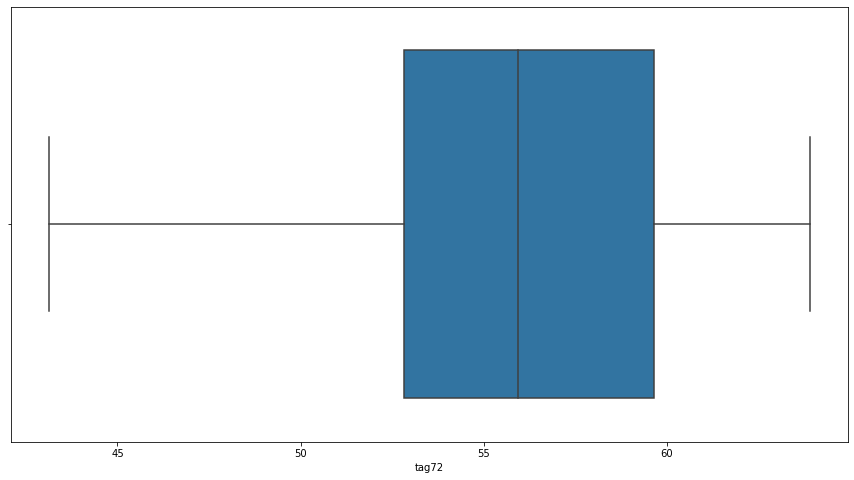

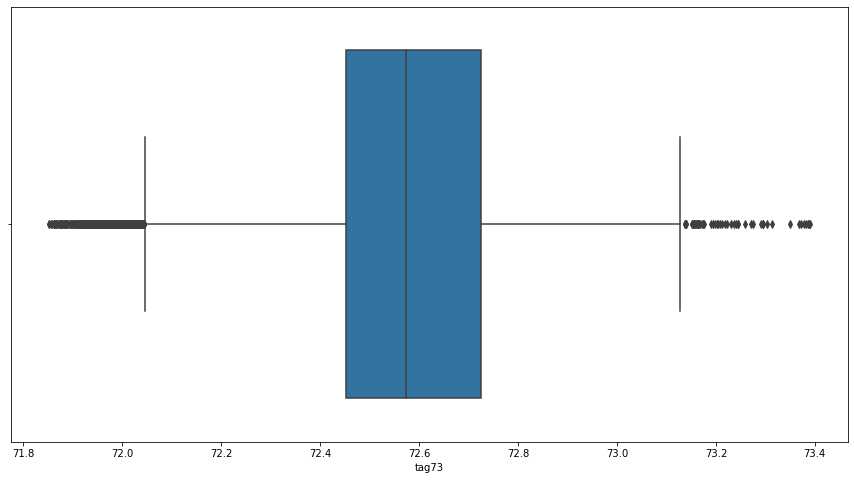

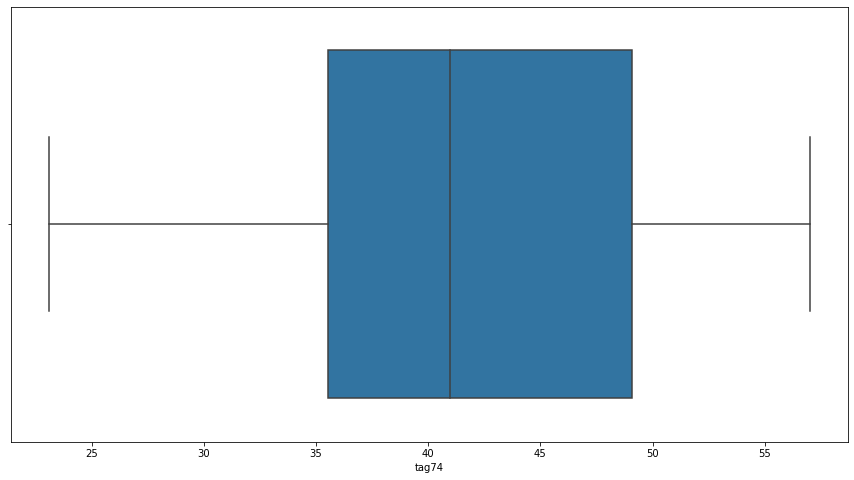

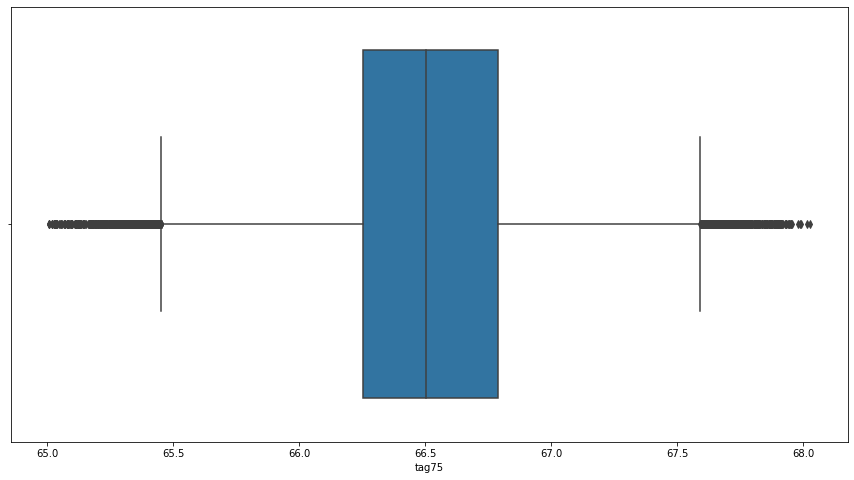

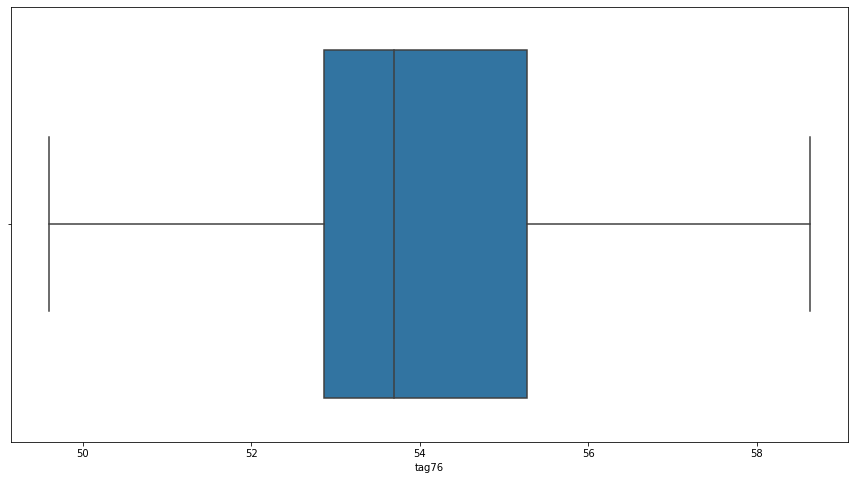

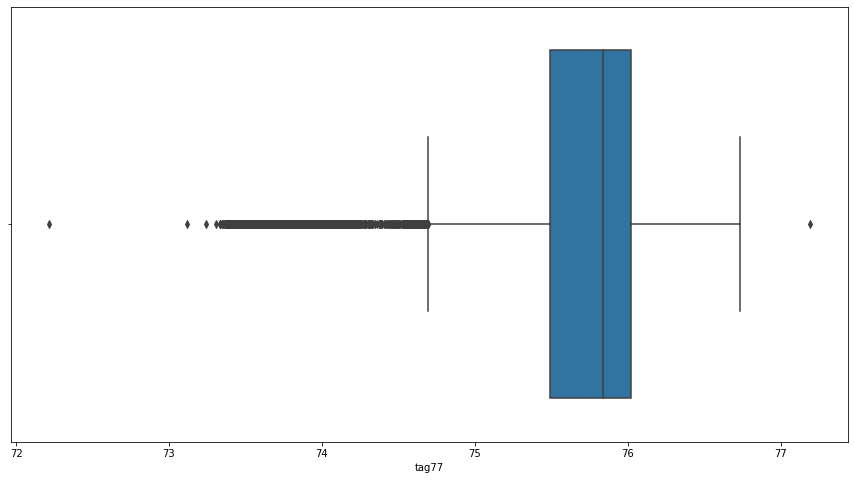

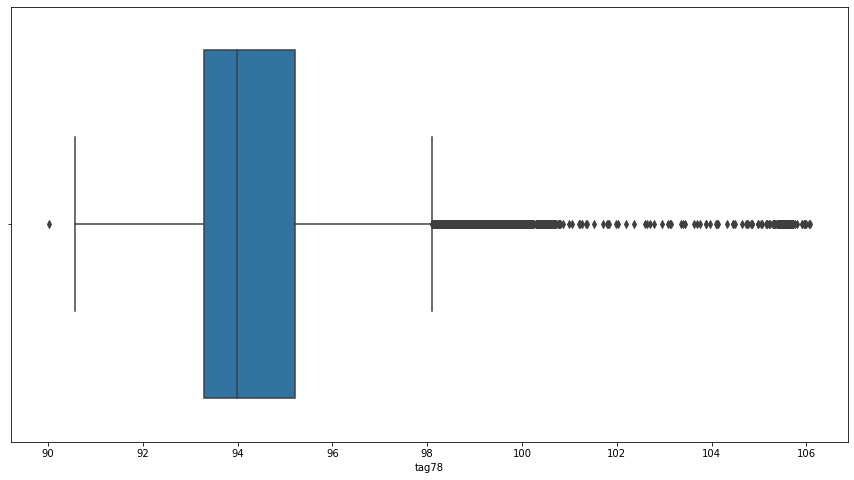

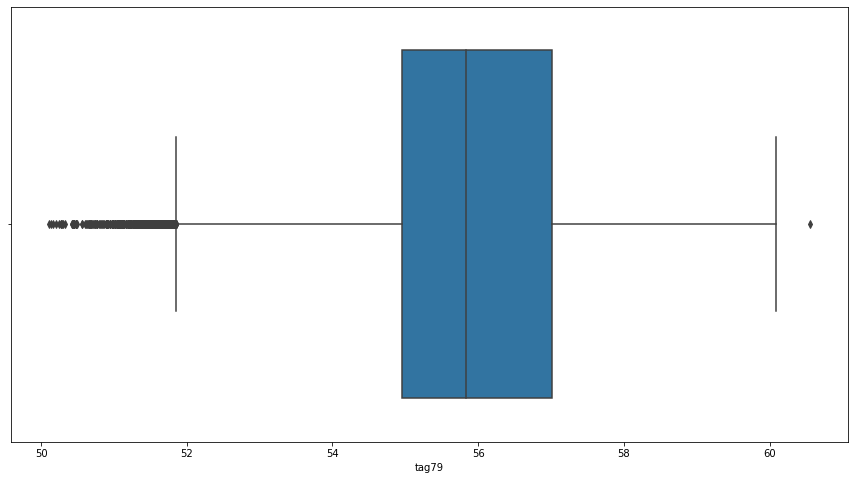

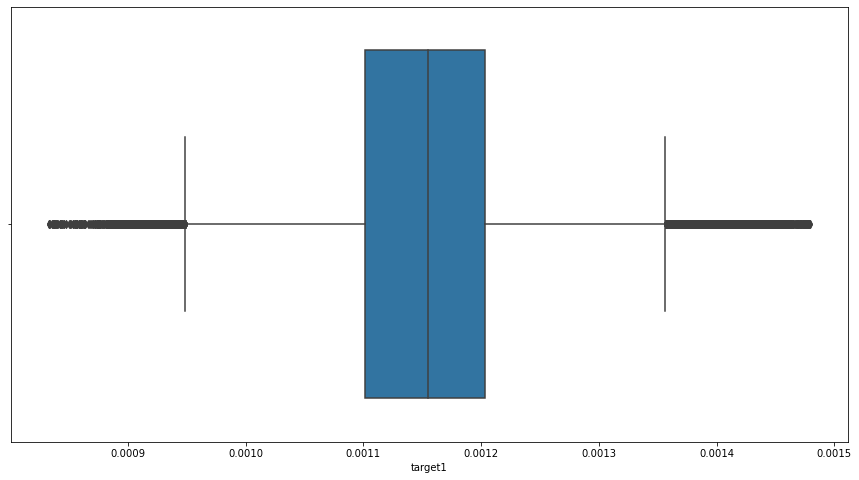

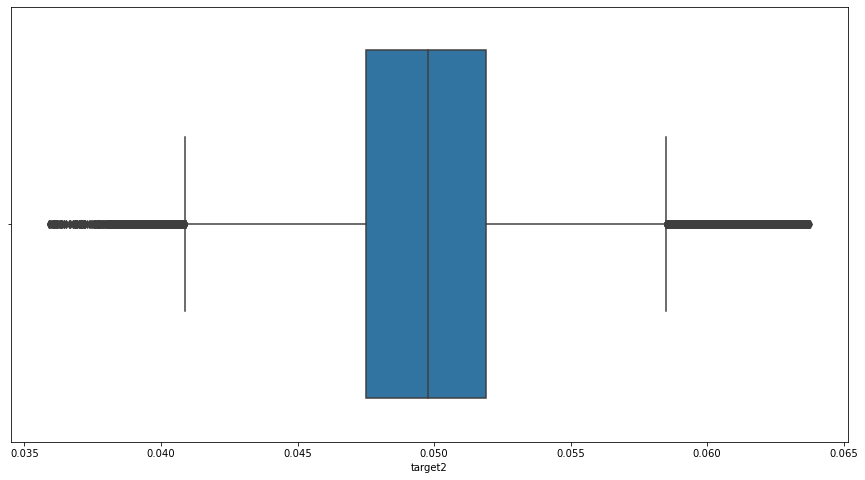

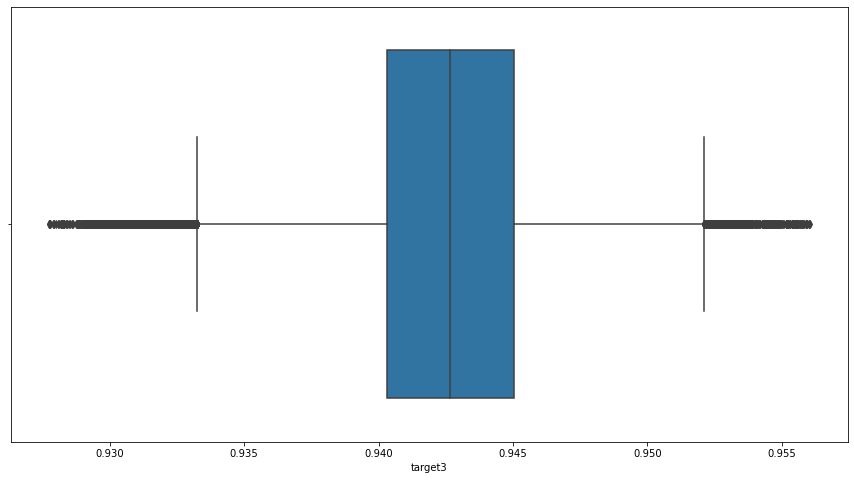

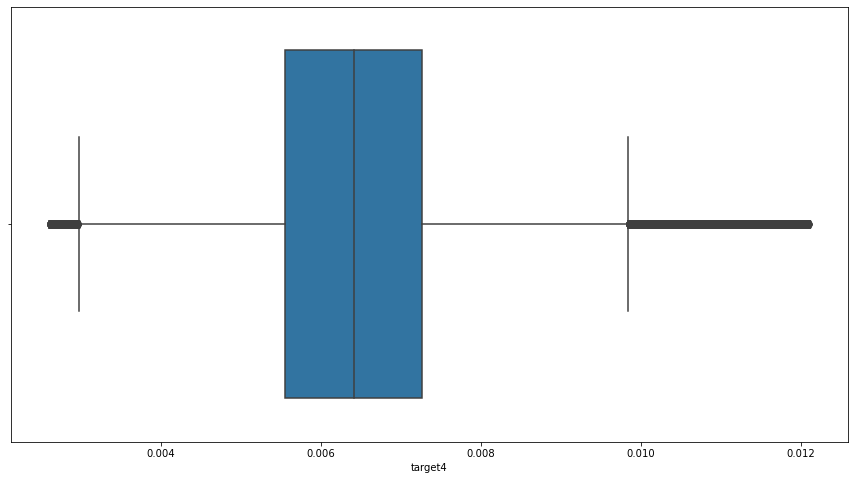

In [16]:
# займёмся выбросами. для этого построим boxplot'ы
for col in list(df)[1:]:
    plt.figure()
    sns.boxplot(x=col, data=df, orient="h")

In [17]:
# составим список со средними признаков
mean = list(df.mean())[:-4]
# заполним пропуски средними
for col in list(df):
    df[col] = df[col].fillna(df[col].mean())

# Поиск топ-10 значимых тэгов и дальнейший анализ

In [18]:
# будем считать, что даже если таргеты являются свойствами какого-либо производимого продукта,
# время релаксации меньше интервала измерения, и мы будем строить модель по фактическим данным
# тэгов в текущий момент, без использования их сглаженных значений (предыстория не влияет
# текущее значение таргета). Поэтому дропнем столбец со временем, оставив только
# количественные характеристики
df = df.drop(['tag0'], axis = 1)

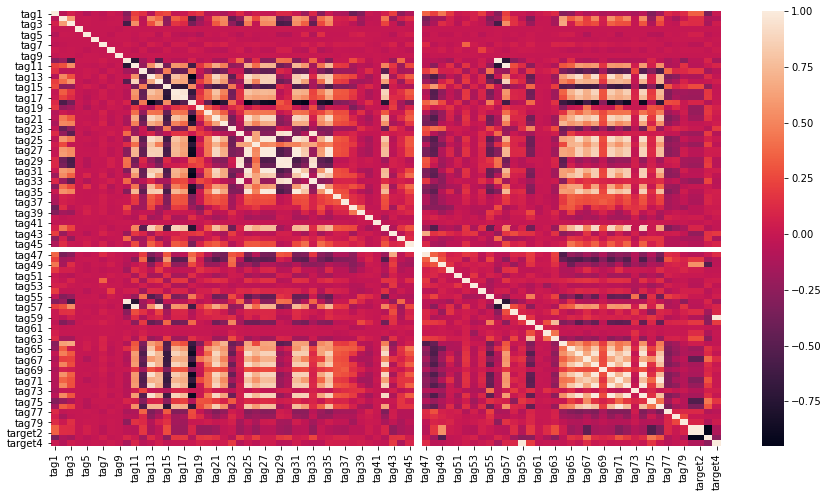

In [19]:
# посмотрим, есть ли среди признаков скореллированные
sns.heatmap(df.corr())

In [20]:
# видно, что некоторые фичи сильно скоррелированы. Пока не будем углубляться (удалять 
# "повторные" сильно скоррелированные, но после машинного нахождения топовых тэгов
# посмотрим на них отдельно в этом ключе

### Первый таргет

In [21]:
# в качестве модели возьмём XGBoost
# воспользуемся SequentialFeatureSelector без валидации для поиска 10 топовых тэгов
# на основе этих тэгов построим модель
# в качестве метрики возьмём MSE
model = XGBRegressor()
sfs1 = SFS(model, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           n_jobs=-1,
           cv=0
          )
X = df[[col for col in list(df.columns)[:-4]]]
y = df['target1']
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:    8.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:    9.2s finished

[2021-04-08 02:56:08] Features: 1/10 -- score: -4.497258038092096e-09[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:    9.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   10.5s finished

[2021-04-08 02:56:19] Features: 2/10 -- score: -2.8443751781052742e-09[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 out of  77 | elapsed:   10.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   12.4s finished

[2021-04-08 02:56:32] Features: 3/10 -- score: -2.1981025209263626e-09[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: D

In [22]:
# составим список тэгов для первого таргета, посмотрим на их характеристики
# все тэги фактически не имели пропусков
feat1 = list(sfs1.subsets_[10]['feature_names'])
df[[col for col in feat1]].describe()

,tag32,tag42,tag43,tag49,tag58,tag63,tag66,tag67,tag75,tag76
count,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000
mean,5.205066,12.905683,156.868850,69.627860,2.406186,2.793256,28.389022,43.807164,66.526244,53.993038
std,14.146727,3.663727,6.337284,4.228227,0.145197,0.006940,7.805092,1.053227,0.378370,1.479687
min,-37.930990,0.000002,131.009900,52.480950,1.947665,2.765161,-2.881436,39.345940,65.006830,49.594650
25%,-4.310777,9.835812,153.242100,67.049100,2.308388,2.788616,21.541120,43.151620,66.255300,52.860790
50%,7.028215,11.971650,157.229300,69.883040,2.410390,2.793363,26.630250,43.848180,66.505090,53.690610
75%,16.954560,15.911490,161.081700,72.487220,2.508675,2.797657,36.287070,44.551400,66.789730,55.272630
max,31.384460,25.000000,182.476800,86.616280,3.133413,2.821628,43.680400,46.988530,68.025420,58.624550


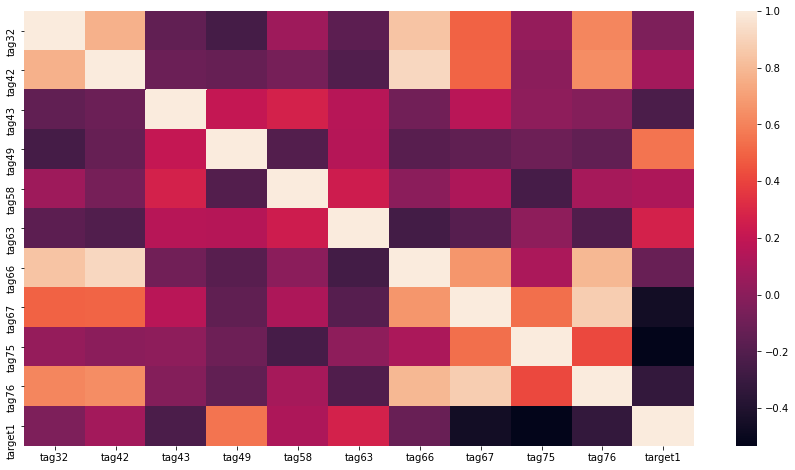

In [23]:
sns.heatmap(df[[col for col in feat1]+['target1']].corr())

In [24]:
df[[col for col in feat1]+['target1']].corr()

,tag32,tag42,tag43,tag49,tag58,tag63,tag66,tag67,tag75,tag76,target1
tag32,1.000000,0.768341,-0.148622,-0.253862,0.066170,-0.161613,0.842081,0.496138,0.041613,0.615483,-0.045492
tag42,0.768341,1.000000,-0.111496,-0.127393,-0.066653,-0.205517,0.916707,0.499473,0.004141,0.636959,0.087389
tag43,-0.148622,-0.111496,1.000000,0.208475,0.274158,0.159553,-0.086860,0.165827,0.015704,-0.018972,-0.232727
tag49,-0.253862,-0.127393,0.208475,1.000000,-0.199639,0.152516,-0.184546,-0.155379,-0.102877,-0.147740,0.554493
tag58,0.066170,-0.066653,0.274158,-0.199639,1.000000,0.240803,0.003035,0.121217,-0.249489,0.101882,0.125647
tag63,-0.161613,-0.205517,0.159553,0.152516,0.240803,1.000000,-0.262532,-0.186570,0.015453,-0.210531,0.271674
tag66,0.842081,0.916707,-0.086860,-0.184546,0.003035,-0.262532,1.000000,0.666967,0.115759,0.793746,-0.120324
tag67,0.496138,0.499473,0.165827,-0.155379,0.121217,-0.186570,0.666967,1.000000,0.534859,0.876389,-0.459001
tag75,0.041613,0.004141,0.015704,-0.102877,-0.249489,0.015453,0.115759,0.534859,1.000000,0.417937,-0.532781
tag76,0.615483,0.636959,-0.018972,-0.147740,0.101882,-0.210531,0.793746,0.876389,0.417937,1.000000,-0.327018


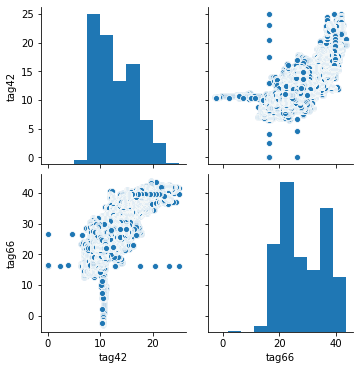

In [25]:
# тэги 42 и 66 достаточно сильно скоррелированы
sns.pairplot(df[['tag42', 'tag66']])

### Второй таргет

In [26]:
# найдём топ тэгов для второго таргета
sfs2 = SFS(model, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           n_jobs=-1,
           cv=0
          )
y = df['target2']
sfs2 = sfs2.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   17.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   18.1s finished

[2021-04-08 02:59:27] Features: 1/10 -- score: -8.055623718140236e-06[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   26.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   29.7s finished

[2021-04-08 02:59:57] Features: 2/10 -- score: -4.358731253466589e-06[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 out of  77 | elapsed:   36.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   40.5s finished

[2021-04-08 03:00:37] Features: 3/10 -- score: -1.6367845657168048e-06[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Do

In [27]:
# составим список тэгов для второго таргета, посмотрим на их характеристики
# все тэги фактически не имели пропусков
feat2 = list(sfs2.subsets_[10]['feature_names'])
df[[col for col in feat2]].describe()

,tag10,tag24,tag31,tag42,tag47,tag49,tag58,tag64,tag66,tag67
count,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000
mean,23.742303,19.396001,20.213735,12.905683,184.768307,69.627860,2.406186,20.652706,28.389022,43.807164
std,4.862516,13.361422,25.149136,3.663727,6.450304,4.228227,0.145197,11.143733,7.805092,1.053227
min,11.294800,-7.698016,-29.993390,0.000002,157.918200,52.480950,1.947665,0.000000,-2.881436,39.345940
25%,19.683450,8.663482,-4.045327,9.835812,180.745600,67.049100,2.308388,20.960700,21.541120,43.151620
50%,25.199200,19.302840,34.478030,11.971650,184.638000,69.883040,2.410390,25.001610,26.630250,43.848180
75%,27.560820,27.289330,44.615070,15.911490,188.926100,72.487220,2.508675,27.732700,36.287070,44.551400
max,33.632790,60.291590,55.926560,25.000000,202.949900,86.616280,3.133413,36.599860,43.680400,46.988530


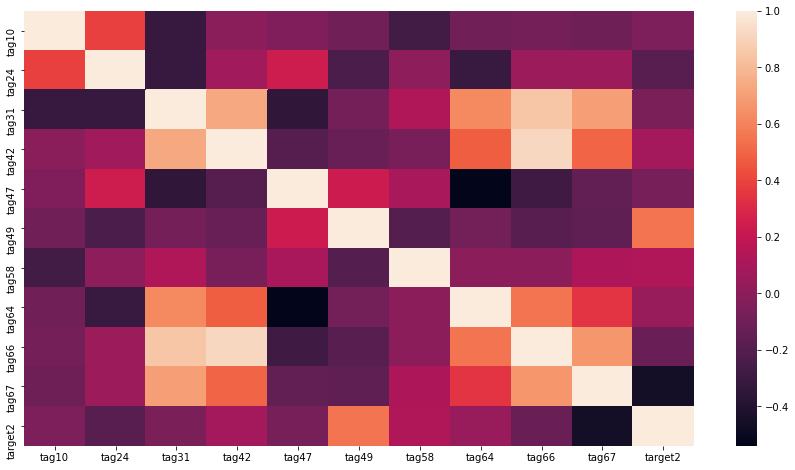

In [28]:
sns.heatmap(df[[col for col in feat2]+['target2']].corr())

### Третий таргет

In [29]:
# найдём топ тэгов для третьего таргета
sfs3 = SFS(model, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           n_jobs=-1,
           cv=0
          )
y = df['target3']
sfs3 = sfs3.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   17.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   18.8s finished

[2021-04-08 03:09:06] Features: 1/10 -- score: -9.438821439356631e-06[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   27.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   30.2s finished

[2021-04-08 03:09:36] Features: 2/10 -- score: -5.071763935409432e-06[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 out of  77 | elapsed:   35.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   40.2s finished

[2021-04-08 03:10:16] Features: 3/10 -- score: -1.9580109300542404e-06[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Do

In [30]:
# составим список тэгов для третьего таргета, посмотрим на их характеристики
# тэг 8 имел мало заполненных значений (около 8%), поэтому его присутствие в этом списке 
# выглядит подозрительно
feat3 = list(sfs3.subsets_[10]['feature_names'])
df[[col for col in feat3]].describe()

,tag8,tag13,tag24,tag42,tag47,tag49,tag58,tag59,tag66,tag67
count,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000
mean,46.980349,0.009038,19.396001,12.905683,184.768307,69.627860,2.406186,0.705500,28.389022,43.807164
std,0.967329,0.006301,13.361422,3.663727,6.450304,4.228227,0.145197,0.148895,7.805092,1.053227
min,31.310870,-0.003327,-7.698016,0.000002,157.918200,52.480950,1.947665,0.236252,-2.881436,39.345940
25%,46.980349,0.004762,8.663482,9.835812,180.745600,67.049100,2.308388,0.600819,21.541120,43.151620
50%,46.980349,0.008670,19.302840,11.971650,184.638000,69.883040,2.410390,0.691387,26.630250,43.848180
75%,46.980349,0.014571,27.289330,15.911490,188.926100,72.487220,2.508675,0.781927,36.287070,44.551400
max,62.376360,0.022949,60.291590,25.000000,202.949900,86.616280,3.133413,1.411588,43.680400,46.988530


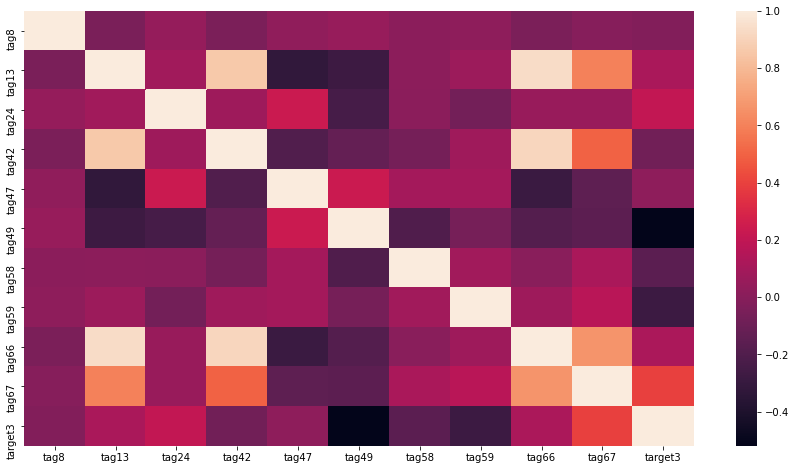

In [31]:
sns.heatmap(df[[col for col in feat3]+['target3']].corr())

In [32]:
df[[col for col in feat3]+['target3']].corr()

,tag8,tag13,tag24,tag42,tag47,tag49,tag58,tag59,tag66,tag67,target3
tag8,1.000000,-0.048071,0.047434,-0.040966,0.031064,0.051073,0.010239,0.026248,-0.039165,-0.006247,-0.016705
tag13,-0.048071,1.000000,0.086210,0.863366,-0.323434,-0.270809,0.015185,0.068779,0.936030,0.599492,0.117719
tag24,0.047434,0.086210,1.000000,0.079263,0.238311,-0.237815,0.013958,-0.073801,0.060437,0.057113,0.207050
tag42,-0.040966,0.863366,0.079263,1.000000,-0.195100,-0.127393,-0.066653,0.081621,0.916707,0.499473,-0.077055
tag47,0.031064,-0.323434,0.238311,-0.195100,1.000000,0.234332,0.101207,0.099690,-0.284554,-0.149525,0.022551
tag49,0.051073,-0.270809,-0.237815,-0.127393,0.234332,1.000000,-0.199639,-0.057388,-0.184546,-0.155379,-0.519808
tag58,0.010239,0.015185,0.013958,-0.066653,0.101207,-0.199639,1.000000,0.088328,0.003035,0.121217,-0.160037
tag59,0.026248,0.068779,-0.073801,0.081621,0.099690,-0.057388,0.088328,1.000000,0.076958,0.173203,-0.277957
tag66,-0.039165,0.936030,0.060437,0.916707,-0.284554,-0.184546,0.003035,0.076958,1.000000,0.666967,0.122309
tag67,-0.006247,0.599492,0.057113,0.499473,-0.149525,-0.155379,0.121217,0.173203,0.666967,1.000000,0.398020


In [33]:
# на самом деле видно, что 8 тэг добавился последним, он ни с чем нескоррелирован, 
# это может означать, что после выделения 9 существенных для третьего таргета 
# фичей, таковых уже не осталось и алгоритм взял фактически константный тэг
# помимо тэга 42, появился сильно скорелированный с тэгом 66 тэг 13
sfs3.subsets_[9]

{'feature_idx': (12, 23, 41, 46, 48, 57, 58, 65, 66),
 'cv_scores': array([-4.30357716e-07]),
 'avg_score': -4.303577164957306e-07,
 'feature_names': ('tag13',
  'tag24',
  'tag42',
  'tag47',
  'tag49',
  'tag58',
  'tag59',
  'tag66',
  'tag67')}

### Четвёртый таргет

In [34]:
# найдём топ тэгов для четвёртого таргета
sfs4 = SFS(model, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           n_jobs=-1,
           cv=0
          )
y = df['target4']
sfs4 = sfs4.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   11.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   11.5s finished

[2021-04-08 03:18:48] Features: 1/10 -- score: -3.787888554016849e-08[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   12.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   14.1s finished

[2021-04-08 03:19:02] Features: 2/10 -- score: -1.3637734632994659e-08[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 out of  77 | elapsed:   15.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   17.7s finished

[2021-04-08 03:19:20] Features: 3/10 -- score: -1.1328057262403515e-08[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: D

In [35]:
# составим список тэгов для четвертого таргета, посмотрим на их характеристики

feat4 = list(sfs4.subsets_[10]['feature_names'])
df[[col for col in feat4]].describe()

,tag1,tag17,tag29,tag33,tag42,tag53,tag55,tag58,tag59,tag63
count,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000,183973.000000
mean,14.694619,0.000589,25.637405,19.564871,12.905683,46.610246,72.662764,2.406186,0.705500,2.793256
std,1.861397,0.000134,15.733411,9.533690,3.663727,1.845278,0.199972,0.145197,0.148895,0.006940
min,7.503639,0.000170,-4.582263,-6.355927,0.000002,34.845440,71.859290,1.947665,0.236252,2.765161
25%,13.584420,0.000487,11.686980,12.690500,9.835812,46.610246,72.550580,2.308388,0.600819,2.788616
50%,14.916570,0.000575,23.045830,20.705730,11.971650,46.610246,72.686840,2.410390,0.691387,2.793363
75%,15.919760,0.000690,39.039990,25.696940,15.911490,46.610246,72.799870,2.508675,0.781927,2.797657
max,22.015910,0.001144,60.530510,44.449840,25.000000,58.331860,73.457050,3.133413,1.411588,2.821628


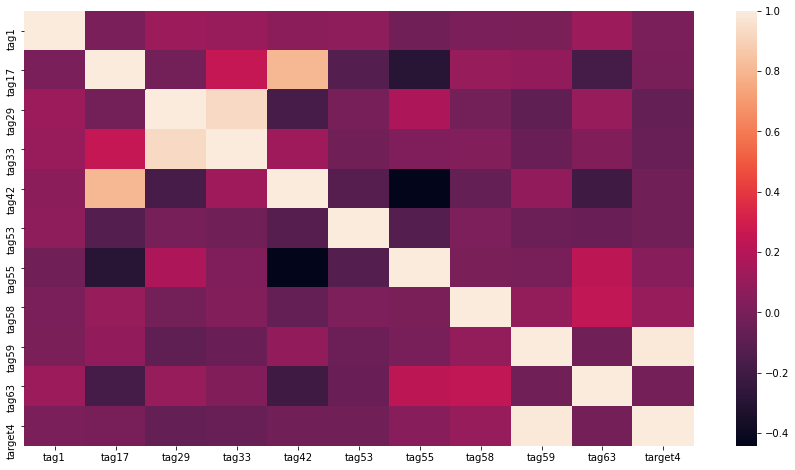

In [36]:
sns.heatmap(df[[col for col in feat4]+['target4']].corr())

In [37]:
df[[col for col in feat4]+['target4']].corr()

,tag1,tag17,tag29,tag33,tag42,tag53,tag55,tag58,tag59,tag63,target4
tag1,1.000000,0.005537,0.116107,0.106748,0.060374,0.074074,-0.029090,0.007090,0.008854,0.119094,0.005920
tag17,0.005537,1.000000,-0.016457,0.254611,0.804275,-0.125908,-0.285031,0.102477,0.081691,-0.179260,0.000589
tag29,0.116107,-0.016457,1.000000,0.929745,-0.169099,-0.003885,0.172866,-0.015472,-0.087298,0.100676,-0.066586
tag33,0.106748,0.254611,0.929745,1.000000,0.129021,-0.022003,0.019427,0.034203,-0.050419,0.027005,-0.059278
tag42,0.060374,0.804275,-0.169099,0.129021,1.000000,-0.119285,-0.442743,-0.066653,0.081621,-0.205517,-0.020667
tag53,0.074074,-0.125908,-0.003885,-0.022003,-0.119285,1.000000,-0.122211,0.017565,-0.044990,-0.048568,-0.029730
tag55,-0.029090,-0.285031,0.172866,0.019427,-0.442743,-0.122211,1.000000,0.012402,0.002408,0.230742,0.048561
tag58,0.007090,0.102477,-0.015472,0.034203,-0.066653,0.017565,0.012402,1.000000,0.088328,0.240803,0.103345
tag59,0.008854,0.081691,-0.087298,-0.050419,0.081621,-0.044990,0.002408,0.088328,1.000000,-0.026738,0.985719
tag63,0.119094,-0.179260,0.100676,0.027005,-0.205517,-0.048568,0.230742,0.240803,-0.026738,1.000000,-0.009590


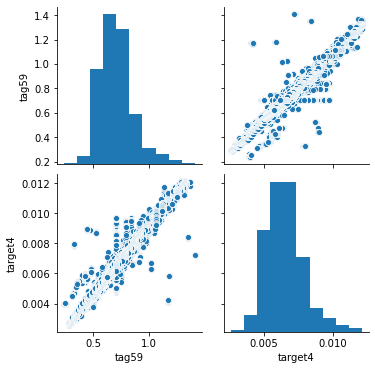

In [38]:
# тэг 59 и таргет 4 очень сильно скоррелированы,
# поэтому тэг 59 был выбран топовым 
sns.pairplot(df[['tag59', 'target4']])

# Построение и оценка модели

Заметим, что при поиске наиболее значимых тэгов 
был использован бустинг на всех данных датасета без кросс-валидации. Для того, чтобы была возможность оценить
эффективность модели в дальнейшем мы будем использовать отложенную выборку. Это вполне может изменить
 некоторые менее значимые тэги из списка топ10, полученных на предыдущем шаге. Однако, это не должно повлиять на тэги, 
    существенные для данного таргета

target1 : 
relative RMSE:  0.02580856211195357
relative std:  0.06030910092297607 

target2 : 
relative RMSE:  0.012234048966857198
relative std:  0.06866043447235547 

target3 : 
relative RMSE:  0.0006747986219168001
relative std:  0.0038424114197981927 

target4 : 
relative RMSE:  0.015074452765887576
relative std:  0.208678670209186 



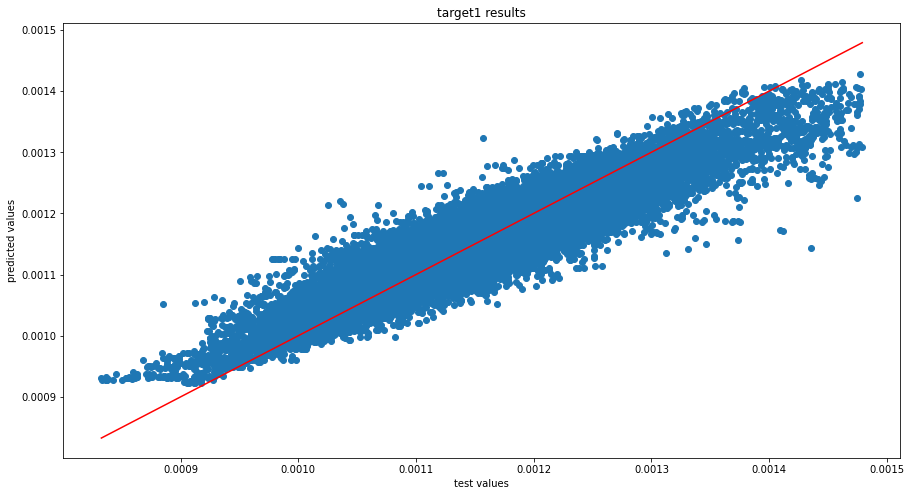

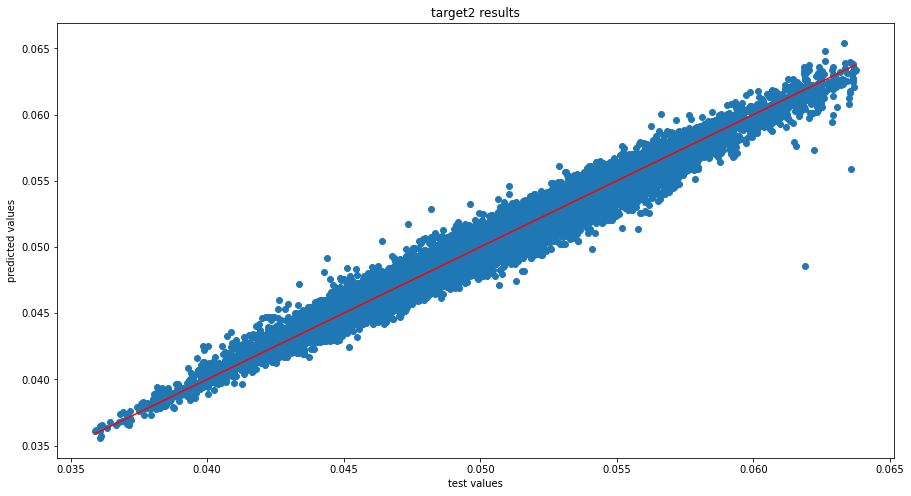

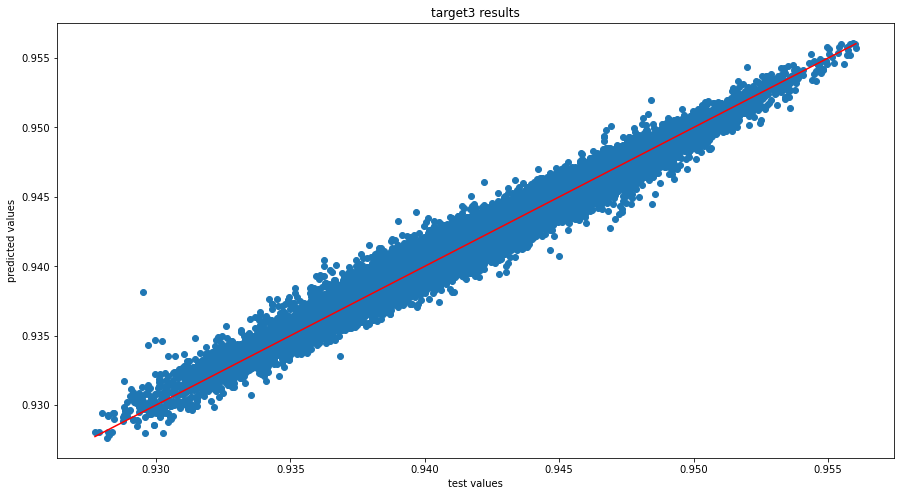

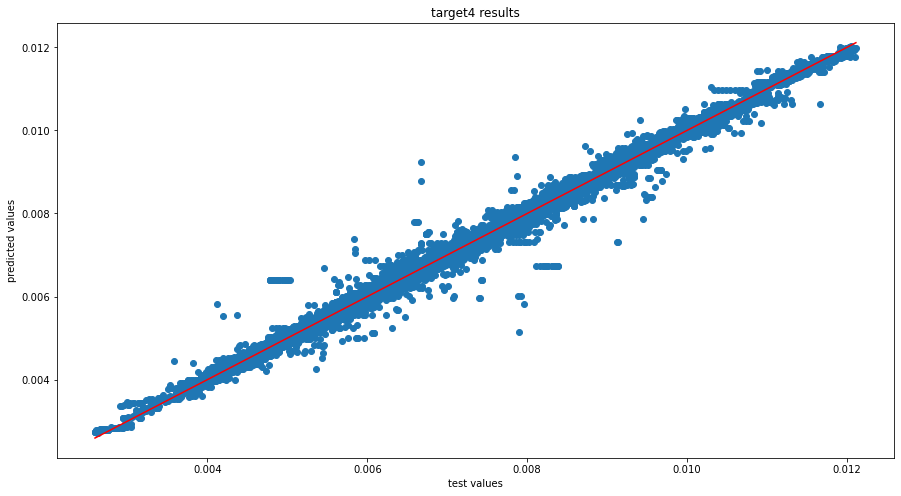

In [39]:
#xgb_models = []
for target in list(df.columns)[-4:]:
    X_train, X_test, y_train, y_test = train_test_split(
        df[[col for col in list(df.columns)[:-4]]], 
        df[target], 
        test_size=0.33, 
        random_state=42)

    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    check = pd.DataFrame({'pred': list(y_pred), 'test': y_test.to_list()})
#    check['diff'] = abs(check['pred'] - check['test'])
#    check['diff_relat'] = check['diff']/check['test']
#    print(check['diff_relat'].mean())
#    check['diff'].mean()

    plt.figure()
    plt.plot(check['test'], check['pred'], 'o')
    plt.plot([df[target].min(),df[target].max()], [df[target].min(),df[target].max()], 'r')
    plt.xlabel('test values')
    plt.ylabel('predicted values')
    plt.title(target+' results')

    # relative RMSE
    print(target, ': ')
    print('relative RMSE: ', metrics.mean_squared_error(check['pred']/check['test'], check['test']/check['test']) ** (1/2))
    print('relative std: ', check['pred'].std()/check['pred'].mean(), '\n')
#    xgb_models.append(model)

In [40]:
# Теперь построим модели на полном тренинговом датасете для дальнейшего предсказания результатов на тестовом
xgb_models = []
X_train = df[[col for col in list(df.columns)[:-4]]]
for target in list(df.columns)[-4:]:
    y_train = df[target]

    model = XGBRegressor()
    model.fit(X_train, y_train)
    xgb_models.append(model)

# Прогнозирование результата

In [41]:
# загрузим и предобработаем данные
df1 = pd.read_csv('test_data_100k.csv', sep=',')

In [42]:
# дропаем столбец со временем
pred = df1.drop(['Unnamed: 0'], axis = 1).copy()
pred

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
0,12.59972,NaN,NaN,NaN,NaN,NaN,45.27993,43.13644,NaN,18.52599,...,37.63644,40.64410,53.44470,NaN,36.59567,64.47523,45.08920,NaN,NaN,NaN
1,12.65850,NaN,NaN,NaN,NaN,NaN,NaN,42.98455,NaN,18.52530,...,37.69201,40.68030,53.43953,NaN,36.60715,64.48697,45.18127,NaN,NaN,NaN
2,12.69538,NaN,NaN,NaN,NaN,NaN,NaN,41.87401,NaN,18.52505,...,37.71147,40.69286,53.42733,NaN,36.60194,64.48034,45.00529,75.84169,NaN,NaN
3,12.84726,NaN,NaN,NaN,NaN,NaN,NaN,41.78006,NaN,18.52450,...,37.70427,40.61716,53.44097,NaN,36.61879,64.50220,45.10987,NaN,93.62097,NaN
4,12.98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.52613,...,37.69343,40.64507,53.51237,NaN,36.59875,64.48300,45.12246,NaN,NaN,56.14647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12.08330,NaN,NaN,NaN,44.63140,NaN,NaN,NaN,NaN,34.48858,...,44.72256,50.06271,55.74286,NaN,42.65038,66.08608,53.43510,75.92390,NaN,55.59630
99996,12.13475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.48915,...,44.78089,50.11175,55.76434,NaN,42.68734,66.09002,53.44431,NaN,NaN,55.64390
99997,12.18710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.49021,...,44.82540,50.18184,55.78387,NaN,42.67019,66.11372,53.40477,NaN,103.04540,55.63939
99998,12.25297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.48940,...,44.86958,50.12084,55.89828,NaN,42.66780,66.10795,53.46239,NaN,NaN,55.59716


In [43]:
# заполняем пропуски средними
for i in range(len(list(pred))):
    pred[list(pred)[i]] = pred[list(pred)[i]].fillna(mean[i])

In [44]:
# создаём столбцы с таргетами
pred['target1'] = 0
pred['target2'] = 0
pred['target3'] = 0
pred['target4'] = 0
pred

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,12.59972,0.003362,12.657291,8.715375,31.575078,69.866035,45.279930,43.136440,71.677306,18.52599,...,36.59567,64.47523,45.08920,75.481532,94.504077,55.88634,0,0,0,0
1,12.65850,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,42.984550,71.677306,18.52530,...,36.60715,64.48697,45.18127,75.481532,94.504077,55.88634,0,0,0,0
2,12.69538,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,41.874010,71.677306,18.52505,...,36.60194,64.48034,45.00529,75.841690,94.504077,55.88634,0,0,0,0
3,12.84726,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,41.780060,71.677306,18.52450,...,36.61879,64.50220,45.10987,75.481532,93.620970,55.88634,0,0,0,0
4,12.98246,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,46.980349,71.677306,18.52613,...,36.59875,64.48300,45.12246,75.481532,94.504077,56.14647,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12.08330,0.003362,12.657291,8.715375,44.631400,69.866035,47.263027,46.980349,71.677306,34.48858,...,42.65038,66.08608,53.43510,75.923900,94.504077,55.59630,0,0,0,0
99996,12.13475,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,46.980349,71.677306,34.48915,...,42.68734,66.09002,53.44431,75.481532,94.504077,55.64390,0,0,0,0
99997,12.18710,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,46.980349,71.677306,34.49021,...,42.67019,66.11372,53.40477,75.481532,103.045400,55.63939,0,0,0,0
99998,12.25297,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,46.980349,71.677306,34.48940,...,42.66780,66.10795,53.46239,75.481532,94.504077,55.59716,0,0,0,0


In [45]:
# получаем значения целевых переменных
for col in list(pred)[-4:]:
    pred[col] = xgb_models[list(pred)[-4:].index(col)].predict(pred[[col for col in list(pred.columns)[:-4]]])

In [46]:
pred

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,12.59972,0.003362,12.657291,8.715375,31.575078,69.866035,45.279930,43.136440,71.677306,18.52599,...,36.59567,64.47523,45.08920,75.481532,94.504077,55.88634,0.001285,0.054855,0.936367,0.004380
1,12.65850,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,42.984550,71.677306,18.52530,...,36.60715,64.48697,45.18127,75.481532,94.504077,55.88634,0.001276,0.054664,0.936637,0.004386
2,12.69538,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,41.874010,71.677306,18.52505,...,36.60194,64.48034,45.00529,75.841690,94.504077,55.88634,0.001271,0.054338,0.937979,0.004386
3,12.84726,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,41.780060,71.677306,18.52450,...,36.61879,64.50220,45.10987,75.481532,93.620970,55.88634,0.001271,0.054338,0.938100,0.004386
4,12.98246,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,46.980349,71.677306,18.52613,...,36.59875,64.48300,45.12246,75.481532,94.504077,56.14647,0.001275,0.054338,0.938188,0.004386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12.08330,0.003362,12.657291,8.715375,44.631400,69.866035,47.263027,46.980349,71.677306,34.48858,...,42.65038,66.08608,53.43510,75.923900,94.504077,55.59630,0.001218,0.051548,0.943966,0.005531
99996,12.13475,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,46.980349,71.677306,34.48915,...,42.68734,66.09002,53.44431,75.481532,94.504077,55.64390,0.001210,0.051435,0.944192,0.005531
99997,12.18710,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,46.980349,71.677306,34.49021,...,42.67019,66.11372,53.40477,75.481532,103.045400,55.63939,0.001223,0.051528,0.944141,0.005528
99998,12.25297,0.003362,12.657291,8.715375,31.575078,69.866035,47.263027,46.980349,71.677306,34.48940,...,42.66780,66.10795,53.46239,75.481532,94.504077,55.59716,0.001217,0.050684,0.944206,0.005531


In [47]:
# посмотрим на то, что у нас было в тренинговом датасете
pred[list(pred)[-4:]].describe()

,target1,target2,target3,target4
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001208,0.052230,0.940612,0.005593
std,0.000048,0.002553,0.002583,0.001101
min,0.000961,0.040063,0.928575,0.003503
25%,0.001179,0.050668,0.938954,0.004606
50%,0.001210,0.052169,0.940612,0.005256
75%,0.001240,0.053817,0.942175,0.006596
max,0.001405,0.064499,0.954218,0.009739


In [48]:
# и в тестовом
df[['target1', 'target2', 'target3', 'target4']].describe()

,target1,target2,target3,target4
count,183973.000000,183973.000000,183973.000000,183973.000000
mean,0.001154,0.049758,0.942566,0.006521
std,0.000081,0.003486,0.003680,0.001363
min,0.000833,0.035892,0.927729,0.002595
25%,0.001102,0.047490,0.940326,0.005549
50%,0.001155,0.049766,0.942657,0.006408
75%,0.001204,0.051886,0.945039,0.007266
max,0.001479,0.063752,0.956039,0.012109


In [49]:
# для четвёртого таргета тэг 59 был ключевым
df['tag59'].describe()

count    183973.000000
mean          0.705500
std           0.148895
min           0.236252
25%           0.600819
50%           0.691387
75%           0.781927
max           1.411588
Name: tag59, dtype: float64

In [50]:
pred['tag59'].describe()

count    100000.000000
mean          0.585544
std           0.146885
min          -0.001478
25%           0.468651
50%           0.532841
75%           0.717586
max           3.172892
Name: tag59, dtype: float64

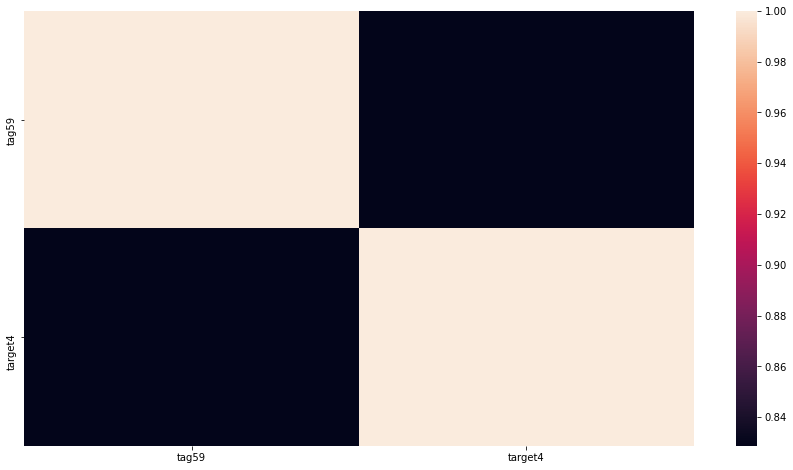

In [51]:
# для предсказанных значений корреляция таргета 4 и тэга 59 упала с 0.98 до 0.83
# возможно это связано с изменением структуры тэга 59 в тестовом датасете по сравнению с тренинговым
# однако, если между ними в действительности была практически функциональная связь, 
# то вполне может оказаться, что модель плохо сработала
sns.heatmap(pred[['tag59']+['target4']].corr())

In [52]:
pred[['tag59']+['target4']].corr()
# корреляция сильно упала (?)

,tag59,target4
tag59,1.000000,0.828671
target4,0.828671,1.000000


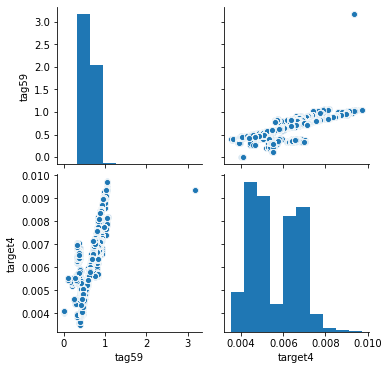

In [53]:
sns.pairplot(pred[['tag59', 'target4']])

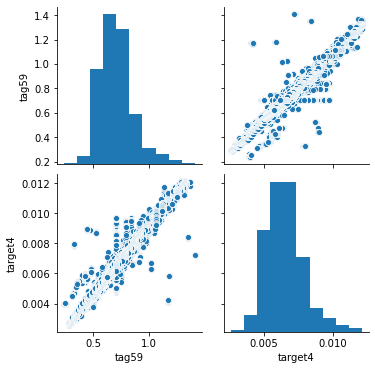

In [54]:
sns.pairplot(df[['tag59', 'target4']])

In [55]:
# сохраним предсказания
df1['target1'] = pred['target1']
df1['target2'] = pred['target2']
df1['target3'] = pred['target3']
df1['target4'] = pred['target4']

In [56]:
# выгрузим их в тренировочный датафрейм без изменения его структуры
df1.rename(columns={'Unnamed: 0': ''}, inplace = True)
df1.to_csv('result.csv', sep=',', index=False)

In [57]:
# выгрузим значения тэгов
with open('tags.txt', 'w') as file:
    file.write('target1: '+str(feat1)+'\n')
    file.write('target2: '+str(feat2)+'\n')
    file.write('target3: '+str(feat3)+'\n')
    file.write('target4: '+str(feat4)+'\n')